In [17]:
from __future__ import print_function, division
import os
import torch
from torch import nn
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import torchvision
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import glob
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import tqdm
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
from tensorflow.python.client import device_lib; device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8817274331101516840, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 18397813862456284398
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13417834228646930996
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14254804173
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17097912474673166463
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [0]:
import tarfile
fname = 'data.tar.gz'
if (fname.endswith("tar.gz")):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()

In [0]:
class DenoisingDataset(Dataset):

    def __init__(self, data_dir, transform=None, train=True):
        self.train= train 
        self.x_path = os.path.join(data_dir, 'distorted')
        self.y_path = os.path.join(data_dir, 'clean')
        self.x_test_path = os.path.join(data_dir, 'test_distorted')
        self.x_files_paths = glob.glob(os.path.join(self.x_path, '*.jpg'))
        self.y_files_paths = glob.glob(os.path.join(self.y_path, '*.jpg'))
        self.x_test_files_paths = glob.glob(os.path.join(self.x_test_path, '*.jpg'))
        self.transform = transform
        self.train_data = []
        self.test_data = []
        self.labels_data = []

    def __len__(self):
        if self.train:
            return len(self.x_files_paths)
        else:
            return len(self.x_test_files_paths)

    def __getitem__(self, idx):
        if self.train: 
            x_img_name, y_img_name =  self.x_files_paths[idx], self.y_files_paths[idx]
            x_image, y_image = io.imread(x_img_name), io.imread(y_img_name)
            x = self.transform(x_image)
            y = self.transform(y_image)
            self.train_data.append(x)
            self.labels_data.append(y)
            return x,y
            
        else:
            x_test_img_name =  self.x_test_files_paths[idx]
            x_test_image = io.imread(x_test_img_name)
            x = self.transform(x_test_image)
            self.test_data.append(x)
            return x
        
    def get_train_data(self, num):
        return torch.stack(self.train_data[:num]), torch.stack(self.labels_data[:num])
    def get_val_data(self, num):
        return torch.stack(self.val_data[:num]), torch.stack(self.val_labels_data[:num])
    
    def get_test_data(self, num):
        return torch.stack(self.test_data[:num])

In [20]:
# Hyper Parameters
epochs = 10
lr = 0.005
n_plots = 1
batch_size = 32
torch.manual_seed(42)

In [0]:
class ConvAutoencoder(nn.Module):
    def __init__(self, ks):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, (ks + 1,ks + 1), padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(16, 8, (ks,ks), padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            nn.Conv2d(8, 3, (ks - 1,ks - 1), padding=1),
            nn.ReLU(inplace=True),
#             nn.MaxPool2d(2),
            
            
            
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=3,out_channels=8, kernel_size=(ks  - 1,ks -1 ), padding=1),
            nn.ReLU(inplace=True),
#             nn.UpsamplingBilinear2d(scale_factor=2),
            
            nn.ConvTranspose2d(in_channels=8,out_channels=16, kernel_size=(ks ,ks), padding=1),
            nn.ReLU(inplace=True),
            nn.UpsamplingBilinear2d(scale_factor=2),
            
            nn.ConvTranspose2d(16, 3, (ks + 1,ks + 1), padding=1),
            nn.ReLU()
            
            
            
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        print('decoded: ', decoded.shape)
        return encoded, decoded

torch.Size([32, 3, 48, 48])
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.1529, 0.1529, 0.1529,  ..., 0.1725, 0.1725, 0.1725],
         [0.7529, 0.7529, 0.7529,  ..., 0.7725, 0.7725, 0.7725],
         ...,
         [0.8392, 0.7686, 0.6824,  ..., 0.7961, 0.7647, 0.7451],
         [0.6549, 0.6000, 0.5451,  ..., 0.5608, 0.5412, 0.5255],
         [0.1333, 0.0941, 0.0863,  ..., 0.1294, 0.1176, 0.1137]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.1804, 0.1804, 0.1804,  ..., 0.2000, 0.2000, 0.2000],
         [0.7804, 0.7804, 0.7804,  ..., 0.8000, 0.8000, 0.8000],
         ...,
         [0.7451, 0.6745, 0.5882,  ..., 0.6941, 0.6627, 0.6431],
         [0.5608, 0.5059, 0.4510,  ..., 0.4549, 0.4353, 0.4196],
         [0.0353, 0.0000, 0.0000,  ..., 0.0196, 0.0078, 0.0039]],

        [[0.0745, 0.0745, 0.0745,  ..., 0.0745, 0.0745, 0.0745],
         [0.2549, 0.2549, 0.2549,  ..., 0.2745, 0.2745, 0.2745],
         [0.8549, 0.8549, 0.85

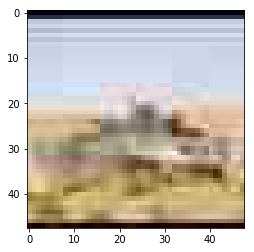

tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         [0.1765, 0.1765, 0.1765,  ..., 0.1804, 0.1804, 0.1804],
         [0.7216, 0.7255, 0.7255,  ..., 0.7412, 0.7412, 0.7412],
         ...,
         [0.8275, 0.7647, 0.6549,  ..., 0.8157, 0.7843, 0.7176],
         [0.6431, 0.6392, 0.5647,  ..., 0.6039, 0.5569, 0.4745],
         [0.0667, 0.0588, 0.0510,  ..., 0.0314, 0.0275, 0.0235]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
         [0.2039, 0.2039, 0.2039,  ..., 0.2039, 0.2039, 0.2039],
         [0.7843, 0.7882, 0.7882,  ..., 0.7843, 0.7843, 0.7843],
         ...,
         [0.6667, 0.6118, 0.5176,  ..., 0.6902, 0.6667, 0.6000],
         [0.5373, 0.5333, 0.4667,  ..., 0.5412, 0.4980, 0.4157],
         [0.0078, 0.0000, 0.0000,  ..., 0.0235, 0.0235, 0.0196]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.2431, 0.2431, 0.2431,  ..., 0.2510, 0.2510, 0.2510],
         [0.8824, 0.8863, 0.8863,  ..., 0.8941, 0.8941, 0.

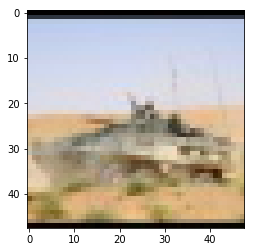

In [22]:
train_dataset = DenoisingDataset('data', 
                                 transform=transforms.Compose([
                                     torchvision.transforms.ToTensor(),
                                ]))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
print(next(iter(train_loader))[0].shape)

def show_img(image):
    print(image)
    plt.imshow(image.permute(1, 2, 0).type(torch.FloatTensor)  )
    plt.pause(0.001)  # pause a bit so that plots are updated
    
show_img(train_dataset.get_train_data(5)[0][3])
show_img(train_dataset.get_train_data(5)[1][3])


0it [00:00, ?it/s]

decoded:  torch.Size([32, 3, 48, 48])
Epoch:  0 | train loss: 0.2064
decoded:  torch.Size([1, 3, 48, 48])
torch.Size([1, 3, 48, 48])
tensor([[[0.4392, 0.4392, 0.4392,  ..., 0.3882, 0.3843, 0.3804],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3608, 0.3569],
         [0.3882, 0.3882, 0.3882,  ..., 0.3255, 0.3176, 0.3176],
         ...,
         [0.2392, 0.2510, 0.2667,  ..., 0.7451, 0.6196, 0.5059],
         [0.2471, 0.2549, 0.2706,  ..., 0.8039, 0.6510, 0.4863],
         [0.2510, 0.2588, 0.2706,  ..., 0.8941, 0.8863, 0.7961]],

        [[0.3490, 0.3490, 0.3490,  ..., 0.2902, 0.2863, 0.2824],
         [0.3373, 0.3373, 0.3373,  ..., 0.2745, 0.2706, 0.2667],
         [0.3216, 0.3216, 0.3216,  ..., 0.2549, 0.2471, 0.2471],
         ...,
         [0.1647, 0.1765, 0.1922,  ..., 0.4784, 0.3529, 0.2392],
         [0.1725, 0.1804, 0.1961,  ..., 0.5412, 0.3765, 0.2118],
         [0.1765, 0.1843, 0.1961,  ..., 0.6314, 0.6118, 0.5216]],

        [[0.2941, 0.2941, 0.2941,  ..., 0.2627, 0.2588,

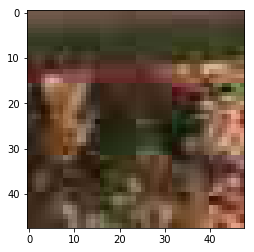

tensor([[[0.3569, 0.3804, 0.3765,  ..., 0.3333, 0.3255, 0.3216],
         [0.3098, 0.3333, 0.3451,  ..., 0.3490, 0.3333, 0.3137],
         [0.3725, 0.3686, 0.3647,  ..., 0.3294, 0.3294, 0.3176],
         ...,
         [0.2392, 0.2431, 0.2118,  ..., 0.6157, 0.4431, 0.3686],
         [0.2275, 0.2314, 0.2039,  ..., 0.7490, 0.6431, 0.6078],
         [0.2667, 0.2157, 0.2627,  ..., 0.8118, 0.7686, 0.6549]],

        [[0.3529, 0.3765, 0.3647,  ..., 0.3098, 0.3216, 0.3216],
         [0.2941, 0.3176, 0.3294,  ..., 0.3020, 0.2941, 0.2863],
         [0.3373, 0.3333, 0.3255,  ..., 0.2667, 0.2706, 0.2588],
         ...,
         [0.1961, 0.2196, 0.2039,  ..., 0.4196, 0.2471, 0.1843],
         [0.1725, 0.2039, 0.1922,  ..., 0.5490, 0.4627, 0.4353],
         [0.2157, 0.1686, 0.2235,  ..., 0.6196, 0.5882, 0.4706]],

        [[0.2824, 0.3059, 0.2980,  ..., 0.2157, 0.2118, 0.2118],
         [0.1961, 0.2196, 0.2314,  ..., 0.2078, 0.1961, 0.1843],
         [0.2235, 0.2196, 0.2196,  ..., 0.1765, 0.1804, 0.

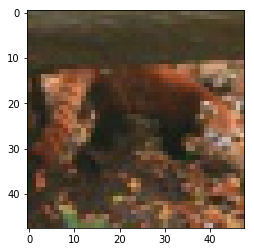

tensor([[[0.0295, 0.0327, 0.0169,  ..., 0.0031, 0.0041, 0.0069],
         [0.0176, 0.0281, 0.0029,  ..., 0.0000, 0.0000, 0.0000],
         [0.0475, 0.0603, 0.0387,  ..., 0.0332, 0.0139, 0.0131],
         ...,
         [0.0584, 0.0513, 0.0363,  ..., 0.0035, 0.0145, 0.0208],
         [0.0423, 0.0384, 0.0384,  ..., 0.0515, 0.0385, 0.0362],
         [0.0470, 0.0309, 0.0319,  ..., 0.0456, 0.0455, 0.0465]],

        [[0.0088, 0.0111, 0.0000,  ..., 0.0111, 0.0000, 0.0000],
         [0.0380, 0.0399, 0.0219,  ..., 0.0168, 0.0000, 0.0000],
         [0.0578, 0.0657, 0.0447,  ..., 0.0466, 0.0000, 0.0000],
         ...,
         [0.0842, 0.0912, 0.1148,  ..., 0.1329, 0.0456, 0.0432],
         [0.0881, 0.1027, 0.1183,  ..., 0.1365, 0.0619, 0.0564],
         [0.0470, 0.0670, 0.0833,  ..., 0.1067, 0.0502, 0.0420]],

        [[0.0000, 0.0000, 0.0271,  ..., 0.0517, 0.0309, 0.0100],
         [0.0000, 0.0102, 0.0523,  ..., 0.0632, 0.0404, 0.0208],
         [0.0005, 0.0282, 0.0852,  ..., 0.0618, 0.0505, 0.

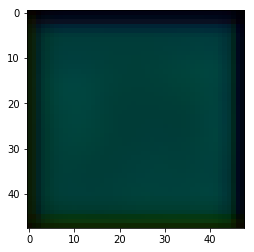


1it [00:00,  1.63it/s]
2it [00:00,  2.10it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



3it [00:00,  2.66it/s]
4it [00:01,  3.26it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



5it [00:01,  3.85it/s]
6it [00:01,  4.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



7it [00:01,  4.97it/s]
8it [00:01,  5.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



9it [00:01,  5.57it/s]
10it [00:01,  5.61it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



11it [00:02,  5.63it/s]
12it [00:02,  5.86it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



13it [00:02,  5.96it/s]
14it [00:02,  5.97it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



15it [00:02,  6.08it/s]
16it [00:02,  6.17it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



17it [00:03,  6.16it/s]
18it [00:03,  6.22it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



19it [00:03,  6.27it/s]
20it [00:03,  6.27it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



21it [00:03,  6.11it/s]
22it [00:03,  6.24it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



23it [00:04,  6.28it/s]
24it [00:04,  6.28it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



25it [00:04,  6.27it/s]
26it [00:04,  6.25it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



27it [00:04,  6.13it/s]
28it [00:04,  6.25it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



29it [00:05,  6.18it/s]
30it [00:05,  6.15it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



31it [00:05,  6.21it/s]
32it [00:05,  6.28it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



33it [00:05,  6.11it/s]
34it [00:05,  6.18it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



35it [00:06,  6.25it/s]
36it [00:06,  6.21it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



37it [00:06,  6.08it/s]
38it [00:06,  6.26it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



39it [00:06,  6.22it/s]
40it [00:06,  6.11it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



41it [00:06,  6.16it/s]
42it [00:07,  6.26it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



43it [00:07,  6.27it/s]
44it [00:07,  6.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



45it [00:07,  6.31it/s]
46it [00:07,  6.12it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



47it [00:07,  6.17it/s]
48it [00:08,  6.23it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



49it [00:08,  6.25it/s]
50it [00:08,  6.35it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



51it [00:08,  6.31it/s]
52it [00:08,  6.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



53it [00:08,  6.22it/s]
54it [00:09,  6.35it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



55it [00:09,  6.35it/s]
56it [00:09,  6.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



57it [00:09,  6.38it/s]
58it [00:09,  6.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



59it [00:09,  6.17it/s]
60it [00:10,  6.26it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



61it [00:10,  6.30it/s]
62it [00:10,  6.25it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



63it [00:10,  6.19it/s]
64it [00:10,  6.24it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



65it [00:10,  6.23it/s]
66it [00:10,  6.23it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



67it [00:11,  6.28it/s]
68it [00:11,  6.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



69it [00:11,  6.40it/s]
70it [00:11,  6.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



71it [00:11,  6.35it/s]
72it [00:11,  6.25it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



73it [00:12,  6.28it/s]
74it [00:12,  6.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



75it [00:12,  6.10it/s]
76it [00:12,  6.20it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



77it [00:12,  6.22it/s]
78it [00:12,  6.18it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



79it [00:13,  6.09it/s]
80it [00:13,  6.23it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



81it [00:13,  6.30it/s]
82it [00:13,  6.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



83it [00:13,  6.33it/s]
84it [00:13,  6.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



85it [00:13,  6.26it/s]
86it [00:14,  6.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



87it [00:14,  6.35it/s]
88it [00:14,  6.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



89it [00:14,  6.33it/s]
90it [00:14,  6.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



91it [00:14,  6.40it/s]
92it [00:15,  6.32it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



93it [00:15,  6.33it/s]
94it [00:15,  6.12it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



95it [00:15,  6.17it/s]
96it [00:15,  6.29it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



97it [00:15,  6.25it/s]
98it [00:16,  6.23it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



99it [00:16,  6.17it/s]
100it [00:16,  6.18it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
Epoch:  0 | train loss: 0.0225
decoded:  torch.Size([1, 3, 48, 48])
torch.Size([1, 3, 48, 48])
tensor([[[0.4392, 0.4392, 0.4392,  ..., 0.3882, 0.3843, 0.3804],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3608, 0.3569],
         [0.3882, 0.3882, 0.3882,  ..., 0.3255, 0.3176, 0.3176],
         ...,
         [0.2392, 0.2510, 0.2667,  ..., 0.7451, 0.6196, 0.5059],
         [0.2471, 0.2549, 0.2706,  ..., 0.8039, 0.6510, 0.4863],
         [0.2510, 0.2588, 0.2706,  ..., 0.8941, 0.8863, 0.7961]],

        [[0.3490, 0.3490, 0.3490,  ..., 0.2902, 0.2863, 0.2824],
         [0.3373, 0.3373, 0.3373,  ..., 0.2745, 0.2706, 0.2667],
         [0.3216, 0.3216, 0.3216,  ..., 0.2549, 0.2471, 0.2471],
         ...,
         [0.1647, 0.1765, 0.1922,  ..., 0.4784, 0.3529, 0.2392],
         [0.1725, 0.1804, 0.1961,  ..., 0.5412, 0.3765, 0.2118],
         [0.1765, 0.1843, 0.1961,  ..., 0.6314, 0.6118, 0.5216]],

        [[0.2941,

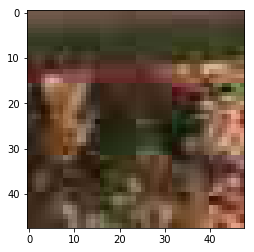

tensor([[[0.3569, 0.3804, 0.3765,  ..., 0.3333, 0.3255, 0.3216],
         [0.3098, 0.3333, 0.3451,  ..., 0.3490, 0.3333, 0.3137],
         [0.3725, 0.3686, 0.3647,  ..., 0.3294, 0.3294, 0.3176],
         ...,
         [0.2392, 0.2431, 0.2118,  ..., 0.6157, 0.4431, 0.3686],
         [0.2275, 0.2314, 0.2039,  ..., 0.7490, 0.6431, 0.6078],
         [0.2667, 0.2157, 0.2627,  ..., 0.8118, 0.7686, 0.6549]],

        [[0.3529, 0.3765, 0.3647,  ..., 0.3098, 0.3216, 0.3216],
         [0.2941, 0.3176, 0.3294,  ..., 0.3020, 0.2941, 0.2863],
         [0.3373, 0.3333, 0.3255,  ..., 0.2667, 0.2706, 0.2588],
         ...,
         [0.1961, 0.2196, 0.2039,  ..., 0.4196, 0.2471, 0.1843],
         [0.1725, 0.2039, 0.1922,  ..., 0.5490, 0.4627, 0.4353],
         [0.2157, 0.1686, 0.2235,  ..., 0.6196, 0.5882, 0.4706]],

        [[0.2824, 0.3059, 0.2980,  ..., 0.2157, 0.2118, 0.2118],
         [0.1961, 0.2196, 0.2314,  ..., 0.2078, 0.1961, 0.1843],
         [0.2235, 0.2196, 0.2196,  ..., 0.1765, 0.1804, 0.

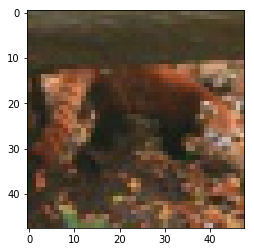

tensor([[[0.1730, 0.2079, 0.2150,  ..., 0.1747, 0.1531, 0.1424],
         [0.1837, 0.2347, 0.2532,  ..., 0.2088, 0.1839, 0.1620],
         [0.2325, 0.2923, 0.3225,  ..., 0.2661, 0.2238, 0.2075],
         ...,
         [0.1940, 0.2220, 0.2550,  ..., 0.4506, 0.4319, 0.3589],
         [0.1693, 0.1875, 0.2216,  ..., 0.4151, 0.3856, 0.3129],
         [0.1503, 0.1553, 0.1794,  ..., 0.3268, 0.3195, 0.2644]],

        [[0.1622, 0.1873, 0.1986,  ..., 0.1797, 0.1571, 0.1418],
         [0.2086, 0.2425, 0.2559,  ..., 0.2022, 0.1682, 0.1546],
         [0.2205, 0.2590, 0.2692,  ..., 0.2308, 0.1914, 0.1712],
         ...,
         [0.1558, 0.1864, 0.2163,  ..., 0.4353, 0.3623, 0.3102],
         [0.1433, 0.1689, 0.1820,  ..., 0.3744, 0.3108, 0.2718],
         [0.1211, 0.1445, 0.1579,  ..., 0.3199, 0.2828, 0.2314]],

        [[0.1062, 0.1385, 0.1828,  ..., 0.1404, 0.1096, 0.0902],
         [0.1315, 0.1680, 0.2290,  ..., 0.1631, 0.1329, 0.1096],
         [0.1573, 0.1953, 0.2598,  ..., 0.1690, 0.1537, 0.

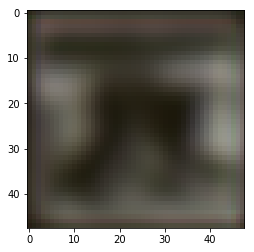


101it [00:17,  3.00it/s]
102it [00:17,  3.52it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



103it [00:17,  4.04it/s]
104it [00:17,  4.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



105it [00:17,  4.99it/s]
106it [00:17,  5.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



107it [00:18,  5.52it/s]
108it [00:18,  5.76it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



109it [00:18,  5.91it/s]
110it [00:18,  6.11it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



111it [00:18,  6.10it/s]
112it [00:18,  6.26it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



113it [00:19,  6.30it/s]
114it [00:19,  6.21it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



115it [00:19,  6.27it/s]
116it [00:19,  6.35it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



117it [00:19,  6.36it/s]
118it [00:19,  6.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



119it [00:19,  6.35it/s]
120it [00:20,  6.29it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



121it [00:20,  6.31it/s]
122it [00:20,  6.25it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



123it [00:20,  6.19it/s]
124it [00:20,  6.28it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



125it [00:20,  6.33it/s]
126it [00:21,  6.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



127it [00:21,  6.27it/s]
128it [00:21,  6.27it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



129it [00:21,  6.30it/s]
130it [00:21,  6.29it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



131it [00:21,  6.35it/s]
132it [00:22,  6.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



133it [00:22,  6.20it/s]
134it [00:22,  6.29it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



135it [00:22,  6.27it/s]
136it [00:22,  6.30it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



137it [00:22,  6.08it/s]
138it [00:23,  6.15it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



139it [00:23,  6.14it/s]
140it [00:23,  6.12it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



141it [00:23,  6.23it/s]
142it [00:23,  6.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



143it [00:23,  6.28it/s]
144it [00:23,  6.32it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



145it [00:24,  6.21it/s]
146it [00:24,  6.23it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



147it [00:24,  6.28it/s]
148it [00:24,  6.27it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



149it [00:24,  6.28it/s]
150it [00:24,  6.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



151it [00:25,  6.44it/s]
152it [00:25,  6.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



153it [00:25,  6.38it/s]
154it [00:25,  6.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



155it [00:25,  6.23it/s]
156it [00:25,  6.35it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



157it [00:26,  6.39it/s]
158it [00:26,  6.35it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



159it [00:26,  6.16it/s]
160it [00:26,  6.26it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



161it [00:26,  6.27it/s]
162it [00:26,  6.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



163it [00:26,  6.33it/s]
164it [00:27,  6.35it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



165it [00:27,  6.39it/s]
166it [00:27,  6.30it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



167it [00:27,  6.24it/s]
168it [00:27,  6.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



169it [00:27,  6.34it/s]
170it [00:28,  6.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



171it [00:28,  6.36it/s]
172it [00:28,  6.30it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



173it [00:28,  6.31it/s]
174it [00:28,  6.26it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



175it [00:28,  6.26it/s]
176it [00:29,  6.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



177it [00:29,  6.32it/s]
178it [00:29,  6.29it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



179it [00:29,  6.21it/s]
180it [00:29,  6.20it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



181it [00:29,  6.12it/s]
182it [00:30,  6.18it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



183it [00:30,  6.15it/s]
184it [00:30,  6.20it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



185it [00:30,  6.15it/s]
186it [00:30,  6.07it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



187it [00:30,  6.10it/s]
188it [00:30,  6.23it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



189it [00:31,  6.22it/s]
190it [00:31,  6.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



191it [00:31,  6.19it/s]
192it [00:31,  6.27it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



193it [00:31,  6.28it/s]
194it [00:31,  6.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



195it [00:32,  6.43it/s]
196it [00:32,  6.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



197it [00:32,  6.35it/s]
198it [00:32,  6.13it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



199it [00:32,  6.12it/s]
200it [00:32,  6.23it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
Epoch:  0 | train loss: 0.0153
decoded:  torch.Size([1, 3, 48, 48])
torch.Size([1, 3, 48, 48])
tensor([[[0.4392, 0.4392, 0.4392,  ..., 0.3882, 0.3843, 0.3804],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3608, 0.3569],
         [0.3882, 0.3882, 0.3882,  ..., 0.3255, 0.3176, 0.3176],
         ...,
         [0.2392, 0.2510, 0.2667,  ..., 0.7451, 0.6196, 0.5059],
         [0.2471, 0.2549, 0.2706,  ..., 0.8039, 0.6510, 0.4863],
         [0.2510, 0.2588, 0.2706,  ..., 0.8941, 0.8863, 0.7961]],

        [[0.3490, 0.3490, 0.3490,  ..., 0.2902, 0.2863, 0.2824],
         [0.3373, 0.3373, 0.3373,  ..., 0.2745, 0.2706, 0.2667],
         [0.3216, 0.3216, 0.3216,  ..., 0.2549, 0.2471, 0.2471],
         ...,
         [0.1647, 0.1765, 0.1922,  ..., 0.4784, 0.3529, 0.2392],
         [0.1725, 0.1804, 0.1961,  ..., 0.5412, 0.3765, 0.2118],
         [0.1765, 0.1843, 0.1961,  ..., 0.6314, 0.6118, 0.5216]],

        [[0.2941,

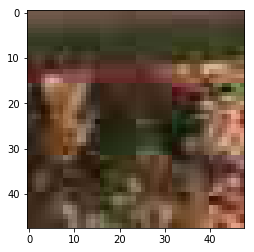

tensor([[[0.3569, 0.3804, 0.3765,  ..., 0.3333, 0.3255, 0.3216],
         [0.3098, 0.3333, 0.3451,  ..., 0.3490, 0.3333, 0.3137],
         [0.3725, 0.3686, 0.3647,  ..., 0.3294, 0.3294, 0.3176],
         ...,
         [0.2392, 0.2431, 0.2118,  ..., 0.6157, 0.4431, 0.3686],
         [0.2275, 0.2314, 0.2039,  ..., 0.7490, 0.6431, 0.6078],
         [0.2667, 0.2157, 0.2627,  ..., 0.8118, 0.7686, 0.6549]],

        [[0.3529, 0.3765, 0.3647,  ..., 0.3098, 0.3216, 0.3216],
         [0.2941, 0.3176, 0.3294,  ..., 0.3020, 0.2941, 0.2863],
         [0.3373, 0.3333, 0.3255,  ..., 0.2667, 0.2706, 0.2588],
         ...,
         [0.1961, 0.2196, 0.2039,  ..., 0.4196, 0.2471, 0.1843],
         [0.1725, 0.2039, 0.1922,  ..., 0.5490, 0.4627, 0.4353],
         [0.2157, 0.1686, 0.2235,  ..., 0.6196, 0.5882, 0.4706]],

        [[0.2824, 0.3059, 0.2980,  ..., 0.2157, 0.2118, 0.2118],
         [0.1961, 0.2196, 0.2314,  ..., 0.2078, 0.1961, 0.1843],
         [0.2235, 0.2196, 0.2196,  ..., 0.1765, 0.1804, 0.

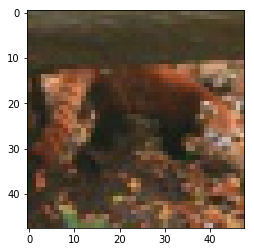

tensor([[[0.1906, 0.2317, 0.2512,  ..., 0.1936, 0.1593, 0.1442],
         [0.2189, 0.2783, 0.3067,  ..., 0.2225, 0.1866, 0.1644],
         [0.2663, 0.3232, 0.3447,  ..., 0.2598, 0.2172, 0.2080],
         ...,
         [0.1580, 0.1680, 0.2009,  ..., 0.3537, 0.3360, 0.3044],
         [0.1467, 0.1578, 0.2013,  ..., 0.3594, 0.3186, 0.2769],
         [0.1342, 0.1492, 0.1910,  ..., 0.3380, 0.3099, 0.2585]],

        [[0.1666, 0.2027, 0.2265,  ..., 0.2010, 0.1710, 0.1456],
         [0.2338, 0.2791, 0.3078,  ..., 0.2312, 0.1920, 0.1746],
         [0.2541, 0.2972, 0.3182,  ..., 0.2599, 0.2197, 0.2040],
         ...,
         [0.1298, 0.1672, 0.1969,  ..., 0.3590, 0.3172, 0.2833],
         [0.1220, 0.1578, 0.1876,  ..., 0.3353, 0.2909, 0.2651],
         [0.1029, 0.1429, 0.1736,  ..., 0.3272, 0.2883, 0.2436]],

        [[0.1329, 0.1687, 0.2231,  ..., 0.1814, 0.1329, 0.1091],
         [0.1805, 0.2208, 0.2955,  ..., 0.2176, 0.1649, 0.1429],
         [0.2124, 0.2464, 0.3094,  ..., 0.2179, 0.1798, 0.

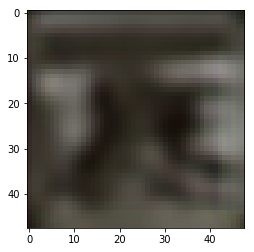


201it [00:33,  2.93it/s]
202it [00:33,  3.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



203it [00:33,  3.98it/s]
204it [00:34,  4.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



205it [00:34,  4.91it/s]
206it [00:34,  5.22it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



207it [00:34,  5.35it/s]
208it [00:34,  5.65it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



209it [00:34,  5.83it/s]
210it [00:35,  5.93it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



211it [00:35,  6.00it/s]
212it [00:35,  6.04it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



213it [00:35,  5.97it/s]
214it [00:35,  5.96it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



215it [00:35,  6.02it/s]
216it [00:36,  6.08it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



217it [00:36,  6.15it/s]
218it [00:36,  6.25it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



219it [00:36,  6.19it/s]
220it [00:36,  6.14it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



221it [00:36,  6.06it/s]
222it [00:37,  5.96it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



223it [00:37,  6.04it/s]
224it [00:37,  6.15it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



225it [00:37,  6.11it/s]
226it [00:37,  6.06it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



227it [00:37,  6.10it/s]
228it [00:38,  6.24it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



229it [00:38,  6.27it/s]
230it [00:38,  6.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



231it [00:38,  6.27it/s]
232it [00:38,  6.13it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



233it [00:38,  6.17it/s]
234it [00:39,  6.24it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



235it [00:39,  6.22it/s]
236it [00:39,  6.27it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



237it [00:39,  6.27it/s]
238it [00:39,  6.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



239it [00:39,  6.15it/s]
240it [00:39,  6.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



241it [00:40,  6.28it/s]
242it [00:40,  6.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



243it [00:40,  6.32it/s]
244it [00:40,  6.27it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



245it [00:40,  6.02it/s]
246it [00:40,  6.17it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



247it [00:41,  6.23it/s]
248it [00:41,  6.32it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



249it [00:41,  6.33it/s]
250it [00:41,  6.35it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



251it [00:41,  6.27it/s]
252it [00:41,  6.26it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



253it [00:42,  6.27it/s]
254it [00:42,  6.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



255it [00:42,  6.17it/s]
256it [00:42,  6.17it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



257it [00:42,  6.24it/s]
258it [00:42,  6.22it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



259it [00:43,  6.26it/s]
260it [00:43,  6.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



261it [00:43,  6.33it/s]
262it [00:43,  6.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



263it [00:43,  6.41it/s]
264it [00:43,  6.18it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



265it [00:43,  6.11it/s]
266it [00:44,  6.17it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



267it [00:44,  6.27it/s]
268it [00:44,  6.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



269it [00:44,  6.35it/s]
270it [00:44,  6.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



271it [00:44,  6.27it/s]
272it [00:45,  6.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



273it [00:45,  6.28it/s]
274it [00:45,  6.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



275it [00:45,  6.42it/s]
276it [00:45,  6.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



277it [00:45,  6.18it/s]
278it [00:46,  6.11it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



279it [00:46,  6.15it/s]
280it [00:46,  6.28it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



281it [00:46,  6.34it/s]
282it [00:46,  6.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



283it [00:46,  6.40it/s]
284it [00:46,  6.27it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



285it [00:47,  6.34it/s]
286it [00:47,  6.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



287it [00:47,  6.42it/s]
288it [00:47,  6.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



289it [00:47,  6.43it/s]
290it [00:47,  6.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



291it [00:48,  6.47it/s]
292it [00:48,  6.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



293it [00:48,  6.47it/s]
294it [00:48,  6.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



295it [00:48,  6.45it/s]
296it [00:48,  6.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



297it [00:48,  6.36it/s]
298it [00:49,  6.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



299it [00:49,  6.40it/s]
300it [00:49,  6.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
Epoch:  0 | train loss: 0.0131
decoded:  torch.Size([1, 3, 48, 48])
torch.Size([1, 3, 48, 48])
tensor([[[0.4392, 0.4392, 0.4392,  ..., 0.3882, 0.3843, 0.3804],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3608, 0.3569],
         [0.3882, 0.3882, 0.3882,  ..., 0.3255, 0.3176, 0.3176],
         ...,
         [0.2392, 0.2510, 0.2667,  ..., 0.7451, 0.6196, 0.5059],
         [0.2471, 0.2549, 0.2706,  ..., 0.8039, 0.6510, 0.4863],
         [0.2510, 0.2588, 0.2706,  ..., 0.8941, 0.8863, 0.7961]],

        [[0.3490, 0.3490, 0.3490,  ..., 0.2902, 0.2863, 0.2824],
         [0.3373, 0.3373, 0.3373,  ..., 0.2745, 0.2706, 0.2667],
         [0.3216, 0.3216, 0.3216,  ..., 0.2549, 0.2471, 0.2471],
         ...,
         [0.1647, 0.1765, 0.1922,  ..., 0.4784, 0.3529, 0.2392],
         [0.1725, 0.1804, 0.1961,  ..., 0.5412, 0.3765, 0.2118],
         [0.1765, 0.1843, 0.1961,  ..., 0.6314, 0.6118, 0.5216]],

        [[0.2941,

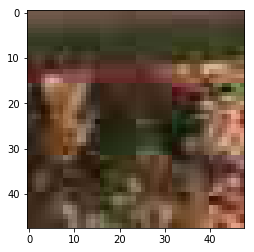

tensor([[[0.3569, 0.3804, 0.3765,  ..., 0.3333, 0.3255, 0.3216],
         [0.3098, 0.3333, 0.3451,  ..., 0.3490, 0.3333, 0.3137],
         [0.3725, 0.3686, 0.3647,  ..., 0.3294, 0.3294, 0.3176],
         ...,
         [0.2392, 0.2431, 0.2118,  ..., 0.6157, 0.4431, 0.3686],
         [0.2275, 0.2314, 0.2039,  ..., 0.7490, 0.6431, 0.6078],
         [0.2667, 0.2157, 0.2627,  ..., 0.8118, 0.7686, 0.6549]],

        [[0.3529, 0.3765, 0.3647,  ..., 0.3098, 0.3216, 0.3216],
         [0.2941, 0.3176, 0.3294,  ..., 0.3020, 0.2941, 0.2863],
         [0.3373, 0.3333, 0.3255,  ..., 0.2667, 0.2706, 0.2588],
         ...,
         [0.1961, 0.2196, 0.2039,  ..., 0.4196, 0.2471, 0.1843],
         [0.1725, 0.2039, 0.1922,  ..., 0.5490, 0.4627, 0.4353],
         [0.2157, 0.1686, 0.2235,  ..., 0.6196, 0.5882, 0.4706]],

        [[0.2824, 0.3059, 0.2980,  ..., 0.2157, 0.2118, 0.2118],
         [0.1961, 0.2196, 0.2314,  ..., 0.2078, 0.1961, 0.1843],
         [0.2235, 0.2196, 0.2196,  ..., 0.1765, 0.1804, 0.

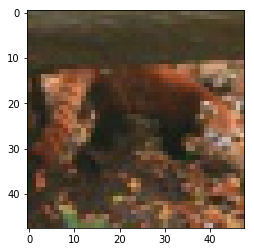

tensor([[[0.1955, 0.2440, 0.2779,  ..., 0.2088, 0.1676, 0.1492],
         [0.2238, 0.2879, 0.3303,  ..., 0.2229, 0.1931, 0.1702],
         [0.2660, 0.3215, 0.3486,  ..., 0.2590, 0.2311, 0.2234],
         ...,
         [0.1466, 0.1670, 0.2245,  ..., 0.3959, 0.3588, 0.3079],
         [0.1426, 0.1711, 0.2380,  ..., 0.3959, 0.3346, 0.2810],
         [0.1282, 0.1593, 0.2155,  ..., 0.3553, 0.3200, 0.2572]],

        [[0.1621, 0.2084, 0.2518,  ..., 0.2248, 0.1885, 0.1512],
         [0.2351, 0.2821, 0.3239,  ..., 0.2382, 0.1997, 0.1814],
         [0.2621, 0.3095, 0.3437,  ..., 0.2699, 0.2328, 0.2179],
         ...,
         [0.1307, 0.1773, 0.2201,  ..., 0.3846, 0.3472, 0.2933],
         [0.1292, 0.1742, 0.2253,  ..., 0.3654, 0.3241, 0.2757],
         [0.1022, 0.1562, 0.2021,  ..., 0.3743, 0.3278, 0.2622]],

        [[0.1243, 0.1580, 0.2213,  ..., 0.2063, 0.1505, 0.1212],
         [0.1760, 0.2088, 0.2883,  ..., 0.2219, 0.1707, 0.1555],
         [0.2068, 0.2363, 0.2943,  ..., 0.2152, 0.1833, 0.

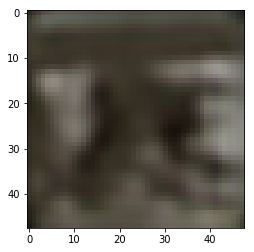


301it [00:50,  3.07it/s]
302it [00:50,  3.59it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



303it [00:50,  4.11it/s]
304it [00:50,  4.63it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



305it [00:50,  5.04it/s]
306it [00:50,  5.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



307it [00:51,  5.53it/s]
308it [00:51,  5.84it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



309it [00:51,  6.03it/s]
310it [00:51,  6.23it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



311it [00:51,  6.26it/s]
312it [00:51,  6.40it/s]
313it [00:51,  6.02it/s]
0it [00:00, ?it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([16, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
Epoch:  1 | train loss: 0.0168
decoded:  torch.Size([1, 3, 48, 48])
torch.Size([1, 3, 48, 48])
tensor([[[0.4392, 0.4392, 0.4392,  ..., 0.3882, 0.3843, 0.3804],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3608, 0.3569],
         [0.3882, 0.3882, 0.3882,  ..., 0.3255, 0.3176, 0.3176],
         ...,
         [0.2392, 0.2510, 0.2667,  ..., 0.7451, 0.6196, 0.5059],
         [0.2471, 0.2549, 0.2706,  ..., 0.8039, 0.6510, 0.4863],
         [0.2510, 0.2588, 0.2706,  ..., 0.8941, 0.8863, 0.7961]],

        [[0.3490, 0.3490, 0.3490,  ..., 0.2902, 0.2863, 0.2824],
         [0.3373, 0.3373, 0.3373,  ..., 0.2745, 0.2706, 0.2667],
         [0.3216, 0.3216, 0.3216,  ..., 0.2549, 0.2471, 0.2471],
         ...,
         [0.1647, 0.1765, 0.1922,  ..., 0.4784, 0.3529, 0.2392],
         [0.1725, 0.1804, 0.1961,  ..., 0.5412, 0.3765, 0.2118],
         [0.1765, 0.1843, 0.1961,  ..., 0.6314

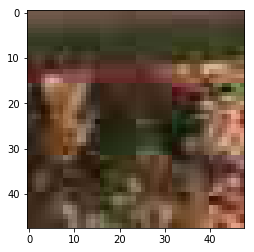

tensor([[[0.3569, 0.3804, 0.3765,  ..., 0.3333, 0.3255, 0.3216],
         [0.3098, 0.3333, 0.3451,  ..., 0.3490, 0.3333, 0.3137],
         [0.3725, 0.3686, 0.3647,  ..., 0.3294, 0.3294, 0.3176],
         ...,
         [0.2392, 0.2431, 0.2118,  ..., 0.6157, 0.4431, 0.3686],
         [0.2275, 0.2314, 0.2039,  ..., 0.7490, 0.6431, 0.6078],
         [0.2667, 0.2157, 0.2627,  ..., 0.8118, 0.7686, 0.6549]],

        [[0.3529, 0.3765, 0.3647,  ..., 0.3098, 0.3216, 0.3216],
         [0.2941, 0.3176, 0.3294,  ..., 0.3020, 0.2941, 0.2863],
         [0.3373, 0.3333, 0.3255,  ..., 0.2667, 0.2706, 0.2588],
         ...,
         [0.1961, 0.2196, 0.2039,  ..., 0.4196, 0.2471, 0.1843],
         [0.1725, 0.2039, 0.1922,  ..., 0.5490, 0.4627, 0.4353],
         [0.2157, 0.1686, 0.2235,  ..., 0.6196, 0.5882, 0.4706]],

        [[0.2824, 0.3059, 0.2980,  ..., 0.2157, 0.2118, 0.2118],
         [0.1961, 0.2196, 0.2314,  ..., 0.2078, 0.1961, 0.1843],
         [0.2235, 0.2196, 0.2196,  ..., 0.1765, 0.1804, 0.

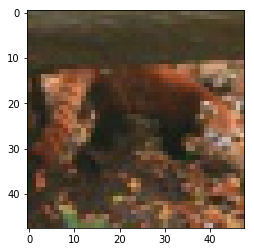

tensor([[[0.1821, 0.2254, 0.2550,  ..., 0.1922, 0.1573, 0.1424],
         [0.2085, 0.2653, 0.3020,  ..., 0.2023, 0.1812, 0.1635],
         [0.2483, 0.2970, 0.3194,  ..., 0.2404, 0.2226, 0.2188],
         ...,
         [0.1445, 0.1679, 0.2296,  ..., 0.4112, 0.3697, 0.3134],
         [0.1424, 0.1743, 0.2450,  ..., 0.4106, 0.3453, 0.2872],
         [0.1279, 0.1624, 0.2217,  ..., 0.3670, 0.3293, 0.2618]],

        [[0.1525, 0.1946, 0.2349,  ..., 0.2119, 0.1810, 0.1462],
         [0.2205, 0.2616, 0.2985,  ..., 0.2210, 0.1905, 0.1758],
         [0.2485, 0.2906, 0.3211,  ..., 0.2555, 0.2262, 0.2142],
         ...,
         [0.1345, 0.1852, 0.2334,  ..., 0.4066, 0.3683, 0.3065],
         [0.1336, 0.1823, 0.2394,  ..., 0.3871, 0.3429, 0.2866],
         [0.1054, 0.1627, 0.2124,  ..., 0.3956, 0.3451, 0.2714]],

        [[0.1155, 0.1438, 0.1995,  ..., 0.1902, 0.1408, 0.1154],
         [0.1630, 0.1884, 0.2566,  ..., 0.1965, 0.1549, 0.1465],
         [0.1922, 0.2144, 0.2620,  ..., 0.1918, 0.1695, 0.

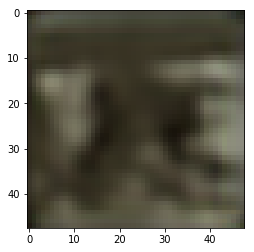


1it [00:00,  1.41it/s]
2it [00:00,  1.84it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



3it [00:01,  2.33it/s]
4it [00:01,  2.86it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



5it [00:01,  3.44it/s]
6it [00:01,  4.06it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



7it [00:01,  4.55it/s]
8it [00:01,  5.03it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



9it [00:01,  5.41it/s]
10it [00:02,  5.76it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



11it [00:02,  5.71it/s]
12it [00:02,  5.84it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



13it [00:02,  6.03it/s]
14it [00:02,  6.18it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



15it [00:02,  6.27it/s]
16it [00:03,  6.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



17it [00:03,  6.31it/s]
18it [00:03,  6.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



19it [00:03,  6.50it/s]
20it [00:03,  6.52it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



21it [00:03,  6.53it/s]
22it [00:03,  6.64it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



23it [00:04,  6.59it/s]
24it [00:04,  6.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



25it [00:04,  6.44it/s]
26it [00:04,  6.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



27it [00:04,  6.43it/s]
28it [00:04,  6.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



29it [00:05,  6.46it/s]
30it [00:05,  6.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



31it [00:05,  6.40it/s]
32it [00:05,  6.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



33it [00:05,  6.45it/s]
34it [00:05,  6.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



35it [00:05,  6.42it/s]
36it [00:06,  6.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



37it [00:06,  6.45it/s]
38it [00:06,  6.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



39it [00:06,  6.46it/s]
40it [00:06,  6.52it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



41it [00:06,  6.51it/s]
42it [00:07,  6.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



43it [00:07,  6.50it/s]
44it [00:07,  6.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



45it [00:07,  6.45it/s]
46it [00:07,  6.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



47it [00:07,  6.46it/s]
48it [00:07,  6.52it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



49it [00:08,  6.49it/s]
50it [00:08,  6.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



51it [00:08,  6.37it/s]
52it [00:08,  6.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



53it [00:08,  6.39it/s]
54it [00:08,  6.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



55it [00:09,  6.46it/s]
56it [00:09,  6.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



57it [00:09,  6.35it/s]
58it [00:09,  6.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



59it [00:09,  6.50it/s]
60it [00:09,  6.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



61it [00:09,  6.54it/s]
62it [00:10,  6.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



63it [00:10,  6.45it/s]
64it [00:10,  6.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



65it [00:10,  6.36it/s]
66it [00:10,  6.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



67it [00:10,  6.36it/s]
68it [00:11,  6.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



69it [00:11,  6.46it/s]
70it [00:11,  6.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



71it [00:11,  6.29it/s]
72it [00:11,  6.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



73it [00:11,  6.32it/s]
74it [00:12,  6.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



75it [00:12,  6.38it/s]
76it [00:12,  6.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



77it [00:12,  6.20it/s]
78it [00:12,  6.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



79it [00:12,  6.11it/s]
80it [00:13,  6.28it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



81it [00:13,  6.22it/s]
82it [00:13,  6.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



83it [00:13,  6.33it/s]
84it [00:13,  6.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



85it [00:13,  6.30it/s]
86it [00:13,  6.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



87it [00:14,  6.40it/s]
88it [00:14,  6.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



89it [00:14,  6.38it/s]
90it [00:14,  6.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



91it [00:14,  6.33it/s]
92it [00:14,  6.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



93it [00:15,  6.44it/s]
94it [00:15,  6.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



95it [00:15,  6.35it/s]
96it [00:15,  6.25it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



97it [00:15,  6.17it/s]
98it [00:15,  6.26it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



99it [00:15,  6.33it/s]
100it [00:16,  6.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
Epoch:  1 | train loss: 0.0107
decoded:  torch.Size([1, 3, 48, 48])
torch.Size([1, 3, 48, 48])
tensor([[[0.4392, 0.4392, 0.4392,  ..., 0.3882, 0.3843, 0.3804],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3608, 0.3569],
         [0.3882, 0.3882, 0.3882,  ..., 0.3255, 0.3176, 0.3176],
         ...,
         [0.2392, 0.2510, 0.2667,  ..., 0.7451, 0.6196, 0.5059],
         [0.2471, 0.2549, 0.2706,  ..., 0.8039, 0.6510, 0.4863],
         [0.2510, 0.2588, 0.2706,  ..., 0.8941, 0.8863, 0.7961]],

        [[0.3490, 0.3490, 0.3490,  ..., 0.2902, 0.2863, 0.2824],
         [0.3373, 0.3373, 0.3373,  ..., 0.2745, 0.2706, 0.2667],
         [0.3216, 0.3216, 0.3216,  ..., 0.2549, 0.2471, 0.2471],
         ...,
         [0.1647, 0.1765, 0.1922,  ..., 0.4784, 0.3529, 0.2392],
         [0.1725, 0.1804, 0.1961,  ..., 0.5412, 0.3765, 0.2118],
         [0.1765, 0.1843, 0.1961,  ..., 0.6314, 0.6118, 0.5216]],

        [[0.2941,

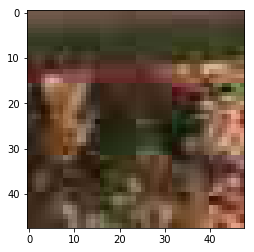

tensor([[[0.3569, 0.3804, 0.3765,  ..., 0.3333, 0.3255, 0.3216],
         [0.3098, 0.3333, 0.3451,  ..., 0.3490, 0.3333, 0.3137],
         [0.3725, 0.3686, 0.3647,  ..., 0.3294, 0.3294, 0.3176],
         ...,
         [0.2392, 0.2431, 0.2118,  ..., 0.6157, 0.4431, 0.3686],
         [0.2275, 0.2314, 0.2039,  ..., 0.7490, 0.6431, 0.6078],
         [0.2667, 0.2157, 0.2627,  ..., 0.8118, 0.7686, 0.6549]],

        [[0.3529, 0.3765, 0.3647,  ..., 0.3098, 0.3216, 0.3216],
         [0.2941, 0.3176, 0.3294,  ..., 0.3020, 0.2941, 0.2863],
         [0.3373, 0.3333, 0.3255,  ..., 0.2667, 0.2706, 0.2588],
         ...,
         [0.1961, 0.2196, 0.2039,  ..., 0.4196, 0.2471, 0.1843],
         [0.1725, 0.2039, 0.1922,  ..., 0.5490, 0.4627, 0.4353],
         [0.2157, 0.1686, 0.2235,  ..., 0.6196, 0.5882, 0.4706]],

        [[0.2824, 0.3059, 0.2980,  ..., 0.2157, 0.2118, 0.2118],
         [0.1961, 0.2196, 0.2314,  ..., 0.2078, 0.1961, 0.1843],
         [0.2235, 0.2196, 0.2196,  ..., 0.1765, 0.1804, 0.

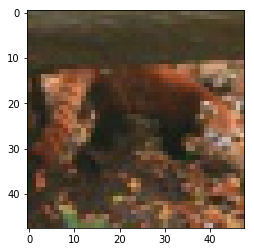

tensor([[[0.1680, 0.2195, 0.2598,  ..., 0.1968, 0.1586, 0.1356],
         [0.1872, 0.2531, 0.3016,  ..., 0.2058, 0.1881, 0.1609],
         [0.2239, 0.2809, 0.3108,  ..., 0.2508, 0.2423, 0.2287],
         ...,
         [0.1386, 0.1749, 0.2514,  ..., 0.4528, 0.4080, 0.3473],
         [0.1420, 0.1849, 0.2670,  ..., 0.4486, 0.3835, 0.3215],
         [0.1227, 0.1649, 0.2349,  ..., 0.4020, 0.3617, 0.2819]],

        [[0.1465, 0.1968, 0.2471,  ..., 0.2349, 0.2034, 0.1563],
         [0.2040, 0.2475, 0.2871,  ..., 0.2324, 0.2055, 0.1900],
         [0.2313, 0.2746, 0.3087,  ..., 0.2648, 0.2466, 0.2400],
         ...,
         [0.1369, 0.1929, 0.2492,  ..., 0.4368, 0.4149, 0.3591],
         [0.1472, 0.1993, 0.2686,  ..., 0.4280, 0.3930, 0.3306],
         [0.1160, 0.1794, 0.2399,  ..., 0.4300, 0.3814, 0.2972]],

        [[0.1205, 0.1514, 0.2138,  ..., 0.2354, 0.1844, 0.1483],
         [0.1626, 0.1841, 0.2505,  ..., 0.2209, 0.1863, 0.1782],
         [0.1948, 0.2160, 0.2605,  ..., 0.2130, 0.1991, 0.

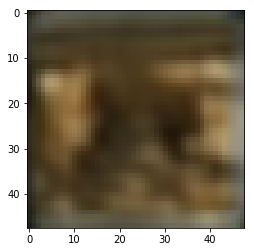


101it [00:16,  3.12it/s]
102it [00:17,  3.63it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



103it [00:17,  4.13it/s]
104it [00:17,  4.65it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



105it [00:17,  5.09it/s]
106it [00:17,  5.32it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



107it [00:17,  5.61it/s]
108it [00:17,  5.92it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



109it [00:18,  6.12it/s]
110it [00:18,  6.24it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



111it [00:18,  6.35it/s]
112it [00:18,  6.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



113it [00:18,  6.19it/s]
114it [00:18,  6.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



115it [00:19,  6.34it/s]
116it [00:19,  6.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



117it [00:19,  6.47it/s]
118it [00:19,  6.57it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



119it [00:19,  6.54it/s]
120it [00:19,  6.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



121it [00:19,  6.42it/s]
122it [00:20,  6.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



123it [00:20,  6.44it/s]
124it [00:20,  6.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



125it [00:20,  6.43it/s]
126it [00:20,  6.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



127it [00:20,  6.34it/s]
128it [00:21,  6.25it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



129it [00:21,  6.30it/s]
130it [00:21,  6.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



131it [00:21,  6.34it/s]
132it [00:21,  6.29it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



133it [00:21,  6.20it/s]
134it [00:22,  6.29it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



135it [00:22,  6.32it/s]
136it [00:22,  6.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



137it [00:22,  6.44it/s]
138it [00:22,  6.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



139it [00:22,  6.20it/s]
140it [00:22,  6.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



141it [00:23,  6.42it/s]
142it [00:23,  6.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



143it [00:23,  6.24it/s]
144it [00:23,  6.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



145it [00:23,  6.38it/s]
146it [00:23,  6.35it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



147it [00:24,  6.32it/s]
148it [00:24,  6.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



149it [00:24,  6.42it/s]
150it [00:24,  6.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



151it [00:24,  6.51it/s]
152it [00:24,  6.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



153it [00:25,  6.45it/s]
154it [00:25,  6.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



155it [00:25,  6.57it/s]
156it [00:25,  6.64it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



157it [00:25,  6.57it/s]
158it [00:25,  6.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



159it [00:25,  6.40it/s]
160it [00:26,  6.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



161it [00:26,  6.44it/s]
162it [00:26,  6.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



163it [00:26,  6.43it/s]
164it [00:26,  6.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



165it [00:26,  6.38it/s]
166it [00:27,  6.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



167it [00:27,  6.35it/s]
168it [00:27,  6.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



169it [00:27,  6.43it/s]
170it [00:27,  6.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



171it [00:27,  6.39it/s]
172it [00:27,  6.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



173it [00:28,  6.41it/s]
174it [00:28,  6.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



175it [00:28,  6.51it/s]
176it [00:28,  6.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



177it [00:28,  6.20it/s]
178it [00:28,  6.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



179it [00:29,  6.15it/s]
180it [00:29,  6.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



181it [00:29,  6.29it/s]
182it [00:29,  6.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



183it [00:29,  6.31it/s]
184it [00:29,  6.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



185it [00:30,  6.21it/s]
186it [00:30,  6.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



187it [00:30,  6.37it/s]
188it [00:30,  6.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



189it [00:30,  6.33it/s]
190it [00:30,  6.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



191it [00:30,  6.31it/s]
192it [00:31,  6.19it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



193it [00:31,  6.15it/s]
194it [00:31,  6.23it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



195it [00:31,  6.17it/s]
196it [00:31,  6.18it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



197it [00:31,  6.19it/s]
198it [00:32,  6.16it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



199it [00:32,  6.16it/s]
200it [00:32,  6.19it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
Epoch:  1 | train loss: 0.0092
decoded:  torch.Size([1, 3, 48, 48])
torch.Size([1, 3, 48, 48])
tensor([[[0.4392, 0.4392, 0.4392,  ..., 0.3882, 0.3843, 0.3804],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3608, 0.3569],
         [0.3882, 0.3882, 0.3882,  ..., 0.3255, 0.3176, 0.3176],
         ...,
         [0.2392, 0.2510, 0.2667,  ..., 0.7451, 0.6196, 0.5059],
         [0.2471, 0.2549, 0.2706,  ..., 0.8039, 0.6510, 0.4863],
         [0.2510, 0.2588, 0.2706,  ..., 0.8941, 0.8863, 0.7961]],

        [[0.3490, 0.3490, 0.3490,  ..., 0.2902, 0.2863, 0.2824],
         [0.3373, 0.3373, 0.3373,  ..., 0.2745, 0.2706, 0.2667],
         [0.3216, 0.3216, 0.3216,  ..., 0.2549, 0.2471, 0.2471],
         ...,
         [0.1647, 0.1765, 0.1922,  ..., 0.4784, 0.3529, 0.2392],
         [0.1725, 0.1804, 0.1961,  ..., 0.5412, 0.3765, 0.2118],
         [0.1765, 0.1843, 0.1961,  ..., 0.6314, 0.6118, 0.5216]],

        [[0.2941,

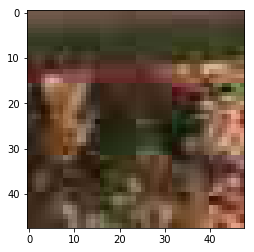

tensor([[[0.3569, 0.3804, 0.3765,  ..., 0.3333, 0.3255, 0.3216],
         [0.3098, 0.3333, 0.3451,  ..., 0.3490, 0.3333, 0.3137],
         [0.3725, 0.3686, 0.3647,  ..., 0.3294, 0.3294, 0.3176],
         ...,
         [0.2392, 0.2431, 0.2118,  ..., 0.6157, 0.4431, 0.3686],
         [0.2275, 0.2314, 0.2039,  ..., 0.7490, 0.6431, 0.6078],
         [0.2667, 0.2157, 0.2627,  ..., 0.8118, 0.7686, 0.6549]],

        [[0.3529, 0.3765, 0.3647,  ..., 0.3098, 0.3216, 0.3216],
         [0.2941, 0.3176, 0.3294,  ..., 0.3020, 0.2941, 0.2863],
         [0.3373, 0.3333, 0.3255,  ..., 0.2667, 0.2706, 0.2588],
         ...,
         [0.1961, 0.2196, 0.2039,  ..., 0.4196, 0.2471, 0.1843],
         [0.1725, 0.2039, 0.1922,  ..., 0.5490, 0.4627, 0.4353],
         [0.2157, 0.1686, 0.2235,  ..., 0.6196, 0.5882, 0.4706]],

        [[0.2824, 0.3059, 0.2980,  ..., 0.2157, 0.2118, 0.2118],
         [0.1961, 0.2196, 0.2314,  ..., 0.2078, 0.1961, 0.1843],
         [0.2235, 0.2196, 0.2196,  ..., 0.1765, 0.1804, 0.

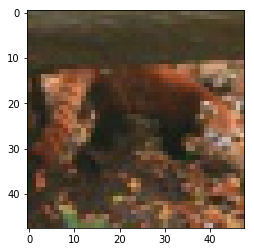

tensor([[[0.1740, 0.2298, 0.2772,  ..., 0.2032, 0.1684, 0.1458],
         [0.1929, 0.2588, 0.3104,  ..., 0.2138, 0.2005, 0.1734],
         [0.2300, 0.2796, 0.3080,  ..., 0.2629, 0.2565, 0.2427],
         ...,
         [0.1389, 0.1784, 0.2539,  ..., 0.4603, 0.4134, 0.3457],
         [0.1465, 0.1901, 0.2686,  ..., 0.4541, 0.3923, 0.3225],
         [0.1252, 0.1682, 0.2361,  ..., 0.3995, 0.3623, 0.2766]],

        [[0.1530, 0.2098, 0.2690,  ..., 0.2381, 0.2144, 0.1624],
         [0.2125, 0.2563, 0.3003,  ..., 0.2304, 0.2100, 0.1946],
         [0.2368, 0.2777, 0.3108,  ..., 0.2601, 0.2484, 0.2434],
         ...,
         [0.1326, 0.1884, 0.2468,  ..., 0.4499, 0.4184, 0.3640],
         [0.1462, 0.1965, 0.2646,  ..., 0.4312, 0.3951, 0.3339],
         [0.1151, 0.1780, 0.2365,  ..., 0.4148, 0.3711, 0.2902]],

        [[0.1333, 0.1664, 0.2366,  ..., 0.2261, 0.1795, 0.1474],
         [0.1777, 0.1940, 0.2674,  ..., 0.2049, 0.1749, 0.1746],
         [0.2115, 0.2263, 0.2746,  ..., 0.2045, 0.1900, 0.

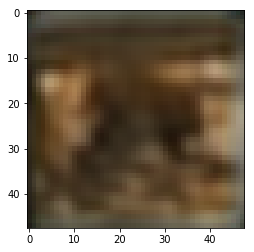


201it [00:33,  3.02it/s]
202it [00:33,  3.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



203it [00:33,  4.10it/s]
204it [00:33,  4.60it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



205it [00:33,  4.85it/s]
206it [00:33,  5.26it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



207it [00:34,  5.38it/s]
208it [00:34,  5.69it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



209it [00:34,  5.90it/s]
210it [00:34,  6.06it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



211it [00:34,  6.15it/s]
212it [00:34,  6.23it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



213it [00:35,  6.31it/s]
214it [00:35,  6.10it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



215it [00:35,  6.15it/s]
216it [00:35,  6.25it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



217it [00:35,  6.16it/s]
218it [00:35,  6.27it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



219it [00:36,  6.30it/s]
220it [00:36,  6.18it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



221it [00:36,  6.19it/s]
222it [00:36,  6.26it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



223it [00:36,  6.22it/s]
224it [00:36,  6.22it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



225it [00:36,  6.28it/s]
226it [00:37,  6.32it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



227it [00:37,  6.15it/s]
228it [00:37,  6.26it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



229it [00:37,  6.20it/s]
230it [00:37,  6.28it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



231it [00:37,  6.22it/s]
232it [00:38,  6.25it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



233it [00:38,  6.14it/s]
234it [00:38,  6.21it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



235it [00:38,  6.25it/s]
236it [00:38,  6.18it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



237it [00:38,  6.24it/s]
238it [00:39,  6.35it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



239it [00:39,  6.39it/s]
240it [00:39,  6.35it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



241it [00:39,  6.34it/s]
242it [00:39,  6.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



243it [00:39,  6.33it/s]
244it [00:40,  6.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



245it [00:40,  6.41it/s]
246it [00:40,  6.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



247it [00:40,  6.46it/s]
248it [00:40,  6.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



249it [00:40,  6.50it/s]
250it [00:40,  6.63it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



251it [00:41,  6.60it/s]
252it [00:41,  6.66it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



253it [00:41,  6.49it/s]
254it [00:41,  6.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



255it [00:41,  6.38it/s]
256it [00:41,  6.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



257it [00:42,  6.47it/s]
258it [00:42,  6.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



259it [00:42,  6.51it/s]
260it [00:42,  6.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



261it [00:42,  6.41it/s]
262it [00:42,  6.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



263it [00:42,  6.53it/s]
264it [00:43,  6.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



265it [00:43,  6.61it/s]
266it [00:43,  6.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



267it [00:43,  6.44it/s]
268it [00:43,  6.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



269it [00:43,  6.51it/s]
270it [00:44,  6.59it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



271it [00:44,  6.47it/s]
272it [00:44,  6.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



273it [00:44,  6.21it/s]
274it [00:44,  6.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



275it [00:44,  6.30it/s]
276it [00:44,  6.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



277it [00:45,  6.43it/s]
278it [00:45,  6.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



279it [00:45,  6.49it/s]
280it [00:45,  6.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



281it [00:45,  6.31it/s]
282it [00:45,  6.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



283it [00:46,  6.26it/s]
284it [00:46,  6.30it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



285it [00:46,  6.35it/s]
286it [00:46,  6.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



287it [00:46,  6.36it/s]
288it [00:46,  6.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



289it [00:46,  6.46it/s]
290it [00:47,  6.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



291it [00:47,  6.43it/s]
292it [00:47,  6.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



293it [00:47,  6.41it/s]
294it [00:47,  6.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



295it [00:47,  6.51it/s]
296it [00:48,  6.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



297it [00:48,  6.54it/s]
298it [00:48,  6.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



299it [00:48,  6.55it/s]
300it [00:48,  6.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
Epoch:  1 | train loss: 0.0080
decoded:  torch.Size([1, 3, 48, 48])
torch.Size([1, 3, 48, 48])
tensor([[[0.4392, 0.4392, 0.4392,  ..., 0.3882, 0.3843, 0.3804],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3608, 0.3569],
         [0.3882, 0.3882, 0.3882,  ..., 0.3255, 0.3176, 0.3176],
         ...,
         [0.2392, 0.2510, 0.2667,  ..., 0.7451, 0.6196, 0.5059],
         [0.2471, 0.2549, 0.2706,  ..., 0.8039, 0.6510, 0.4863],
         [0.2510, 0.2588, 0.2706,  ..., 0.8941, 0.8863, 0.7961]],

        [[0.3490, 0.3490, 0.3490,  ..., 0.2902, 0.2863, 0.2824],
         [0.3373, 0.3373, 0.3373,  ..., 0.2745, 0.2706, 0.2667],
         [0.3216, 0.3216, 0.3216,  ..., 0.2549, 0.2471, 0.2471],
         ...,
         [0.1647, 0.1765, 0.1922,  ..., 0.4784, 0.3529, 0.2392],
         [0.1725, 0.1804, 0.1961,  ..., 0.5412, 0.3765, 0.2118],
         [0.1765, 0.1843, 0.1961,  ..., 0.6314, 0.6118, 0.5216]],

        [[0.2941,

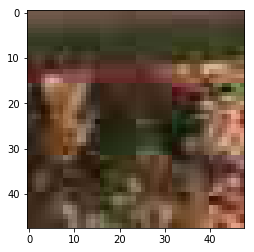

tensor([[[0.3569, 0.3804, 0.3765,  ..., 0.3333, 0.3255, 0.3216],
         [0.3098, 0.3333, 0.3451,  ..., 0.3490, 0.3333, 0.3137],
         [0.3725, 0.3686, 0.3647,  ..., 0.3294, 0.3294, 0.3176],
         ...,
         [0.2392, 0.2431, 0.2118,  ..., 0.6157, 0.4431, 0.3686],
         [0.2275, 0.2314, 0.2039,  ..., 0.7490, 0.6431, 0.6078],
         [0.2667, 0.2157, 0.2627,  ..., 0.8118, 0.7686, 0.6549]],

        [[0.3529, 0.3765, 0.3647,  ..., 0.3098, 0.3216, 0.3216],
         [0.2941, 0.3176, 0.3294,  ..., 0.3020, 0.2941, 0.2863],
         [0.3373, 0.3333, 0.3255,  ..., 0.2667, 0.2706, 0.2588],
         ...,
         [0.1961, 0.2196, 0.2039,  ..., 0.4196, 0.2471, 0.1843],
         [0.1725, 0.2039, 0.1922,  ..., 0.5490, 0.4627, 0.4353],
         [0.2157, 0.1686, 0.2235,  ..., 0.6196, 0.5882, 0.4706]],

        [[0.2824, 0.3059, 0.2980,  ..., 0.2157, 0.2118, 0.2118],
         [0.1961, 0.2196, 0.2314,  ..., 0.2078, 0.1961, 0.1843],
         [0.2235, 0.2196, 0.2196,  ..., 0.1765, 0.1804, 0.

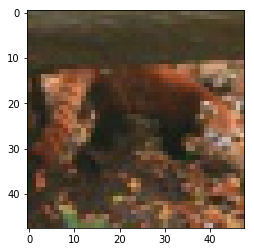

tensor([[[0.1904, 0.2523, 0.3044,  ..., 0.2147, 0.1790, 0.1546],
         [0.2133, 0.2816, 0.3359,  ..., 0.2232, 0.2105, 0.1835],
         [0.2564, 0.3038, 0.3312,  ..., 0.2739, 0.2643, 0.2514],
         ...,
         [0.1544, 0.1946, 0.2740,  ..., 0.4706, 0.4195, 0.3450],
         [0.1631, 0.2067, 0.2862,  ..., 0.4599, 0.4030, 0.3332],
         [0.1397, 0.1828, 0.2545,  ..., 0.4108, 0.3799, 0.2907]],

        [[0.1738, 0.2381, 0.3038,  ..., 0.2567, 0.2349, 0.1770],
         [0.2411, 0.2884, 0.3381,  ..., 0.2466, 0.2261, 0.2086],
         [0.2671, 0.3100, 0.3459,  ..., 0.2805, 0.2633, 0.2600],
         ...,
         [0.1516, 0.2088, 0.2714,  ..., 0.4638, 0.4225, 0.3643],
         [0.1681, 0.2147, 0.2850,  ..., 0.4411, 0.4088, 0.3484],
         [0.1310, 0.1963, 0.2569,  ..., 0.4325, 0.3915, 0.3115]],

        [[0.1537, 0.1908, 0.2670,  ..., 0.2481, 0.1982, 0.1633],
         [0.2019, 0.2131, 0.2910,  ..., 0.2230, 0.1866, 0.1898],
         [0.2380, 0.2450, 0.2941,  ..., 0.2325, 0.2051, 0.

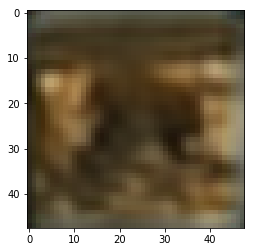


301it [00:49,  3.15it/s]
302it [00:49,  3.68it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



303it [00:49,  4.17it/s]
304it [00:49,  4.71it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



305it [00:50,  5.13it/s]
306it [00:50,  5.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



307it [00:50,  5.79it/s]
308it [00:50,  6.07it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



309it [00:50,  6.02it/s]
310it [00:50,  6.20it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



311it [00:50,  6.34it/s]
312it [00:51,  6.44it/s]
313it [00:51,  6.12it/s]
0it [00:00, ?it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([16, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
Epoch:  2 | train loss: 0.0100
decoded:  torch.Size([1, 3, 48, 48])
torch.Size([1, 3, 48, 48])
tensor([[[0.4392, 0.4392, 0.4392,  ..., 0.3882, 0.3843, 0.3804],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3608, 0.3569],
         [0.3882, 0.3882, 0.3882,  ..., 0.3255, 0.3176, 0.3176],
         ...,
         [0.2392, 0.2510, 0.2667,  ..., 0.7451, 0.6196, 0.5059],
         [0.2471, 0.2549, 0.2706,  ..., 0.8039, 0.6510, 0.4863],
         [0.2510, 0.2588, 0.2706,  ..., 0.8941, 0.8863, 0.7961]],

        [[0.3490, 0.3490, 0.3490,  ..., 0.2902, 0.2863, 0.2824],
         [0.3373, 0.3373, 0.3373,  ..., 0.2745, 0.2706, 0.2667],
         [0.3216, 0.3216, 0.3216,  ..., 0.2549, 0.2471, 0.2471],
         ...,
         [0.1647, 0.1765, 0.1922,  ..., 0.4784, 0.3529, 0.2392],
         [0.1725, 0.1804, 0.1961,  ..., 0.5412, 0.3765, 0.2118],
         [0.1765, 0.1843, 0.1961,  ..., 0.6314

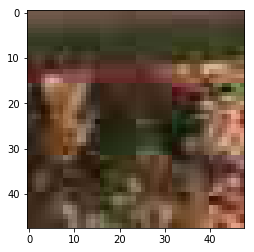

tensor([[[0.3569, 0.3804, 0.3765,  ..., 0.3333, 0.3255, 0.3216],
         [0.3098, 0.3333, 0.3451,  ..., 0.3490, 0.3333, 0.3137],
         [0.3725, 0.3686, 0.3647,  ..., 0.3294, 0.3294, 0.3176],
         ...,
         [0.2392, 0.2431, 0.2118,  ..., 0.6157, 0.4431, 0.3686],
         [0.2275, 0.2314, 0.2039,  ..., 0.7490, 0.6431, 0.6078],
         [0.2667, 0.2157, 0.2627,  ..., 0.8118, 0.7686, 0.6549]],

        [[0.3529, 0.3765, 0.3647,  ..., 0.3098, 0.3216, 0.3216],
         [0.2941, 0.3176, 0.3294,  ..., 0.3020, 0.2941, 0.2863],
         [0.3373, 0.3333, 0.3255,  ..., 0.2667, 0.2706, 0.2588],
         ...,
         [0.1961, 0.2196, 0.2039,  ..., 0.4196, 0.2471, 0.1843],
         [0.1725, 0.2039, 0.1922,  ..., 0.5490, 0.4627, 0.4353],
         [0.2157, 0.1686, 0.2235,  ..., 0.6196, 0.5882, 0.4706]],

        [[0.2824, 0.3059, 0.2980,  ..., 0.2157, 0.2118, 0.2118],
         [0.1961, 0.2196, 0.2314,  ..., 0.2078, 0.1961, 0.1843],
         [0.2235, 0.2196, 0.2196,  ..., 0.1765, 0.1804, 0.

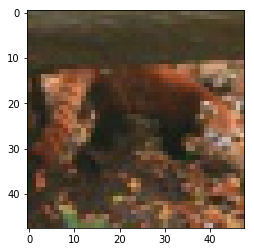

tensor([[[0.1890, 0.2507, 0.3026,  ..., 0.2117, 0.1770, 0.1534],
         [0.2103, 0.2761, 0.3279,  ..., 0.2115, 0.2039, 0.1800],
         [0.2529, 0.2965, 0.3189,  ..., 0.2525, 0.2506, 0.2434],
         ...,
         [0.1460, 0.1821, 0.2542,  ..., 0.4434, 0.4020, 0.3305],
         [0.1541, 0.1935, 0.2665,  ..., 0.4377, 0.3874, 0.3192],
         [0.1327, 0.1724, 0.2392,  ..., 0.3957, 0.3672, 0.2793]],

        [[0.1718, 0.2350, 0.2993,  ..., 0.2504, 0.2291, 0.1730],
         [0.2383, 0.2831, 0.3288,  ..., 0.2310, 0.2144, 0.1995],
         [0.2636, 0.3022, 0.3329,  ..., 0.2558, 0.2452, 0.2463],
         ...,
         [0.1428, 0.1939, 0.2499,  ..., 0.4307, 0.3954, 0.3416],
         [0.1580, 0.1991, 0.2624,  ..., 0.4157, 0.3884, 0.3303],
         [0.1233, 0.1831, 0.2385,  ..., 0.4104, 0.3732, 0.2957]],

        [[0.1568, 0.1969, 0.2758,  ..., 0.2524, 0.2017, 0.1639],
         [0.2066, 0.2201, 0.2991,  ..., 0.2216, 0.1851, 0.1865],
         [0.2429, 0.2522, 0.3019,  ..., 0.2263, 0.1997, 0.

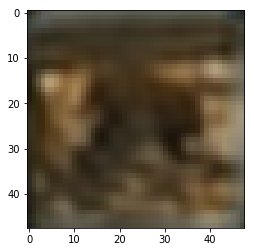


1it [00:00,  1.42it/s]
2it [00:00,  1.85it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



3it [00:01,  2.35it/s]
4it [00:01,  2.93it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



5it [00:01,  3.54it/s]
6it [00:01,  4.11it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



7it [00:01,  4.59it/s]
8it [00:01,  5.08it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



9it [00:01,  5.40it/s]
10it [00:02,  5.67it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



11it [00:02,  5.91it/s]
12it [00:02,  6.13it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



13it [00:02,  6.09it/s]
14it [00:02,  6.28it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



15it [00:02,  6.36it/s]
16it [00:03,  6.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



17it [00:03,  6.27it/s]
18it [00:03,  6.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



19it [00:03,  6.44it/s]
20it [00:03,  6.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



21it [00:03,  6.41it/s]
22it [00:03,  6.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



23it [00:04,  6.40it/s]
24it [00:04,  6.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



25it [00:04,  6.39it/s]
26it [00:04,  6.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



27it [00:04,  6.32it/s]
28it [00:04,  6.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



29it [00:05,  6.43it/s]
30it [00:05,  6.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



31it [00:05,  6.58it/s]
32it [00:05,  6.61it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



33it [00:05,  6.44it/s]
34it [00:05,  6.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



35it [00:05,  6.53it/s]
36it [00:06,  6.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



37it [00:06,  6.52it/s]
38it [00:06,  6.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



39it [00:06,  6.50it/s]
40it [00:06,  6.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



41it [00:06,  6.45it/s]
42it [00:07,  6.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



43it [00:07,  6.49it/s]
44it [00:07,  6.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



45it [00:07,  6.58it/s]
46it [00:07,  6.60it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



47it [00:07,  6.44it/s]
48it [00:07,  6.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



49it [00:08,  6.50it/s]
50it [00:08,  6.52it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



51it [00:08,  6.45it/s]
52it [00:08,  6.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



53it [00:08,  6.32it/s]
54it [00:08,  6.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



55it [00:09,  6.35it/s]
56it [00:09,  6.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



57it [00:09,  6.51it/s]
58it [00:09,  6.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



59it [00:09,  6.51it/s]
60it [00:09,  6.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



61it [00:09,  6.23it/s]
62it [00:10,  6.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



63it [00:10,  6.34it/s]
64it [00:10,  6.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



65it [00:10,  6.37it/s]
66it [00:10,  6.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



67it [00:10,  6.17it/s]
68it [00:11,  6.12it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



69it [00:11,  6.19it/s]
70it [00:11,  6.21it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



71it [00:11,  6.27it/s]
72it [00:11,  6.29it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



73it [00:11,  6.17it/s]
74it [00:12,  6.21it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



75it [00:12,  6.27it/s]
76it [00:12,  6.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



77it [00:12,  6.32it/s]
78it [00:12,  6.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



79it [00:12,  6.31it/s]
80it [00:12,  6.32it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



81it [00:13,  6.28it/s]
82it [00:13,  6.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



83it [00:13,  6.27it/s]
84it [00:13,  6.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



85it [00:13,  6.38it/s]
86it [00:13,  6.24it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



87it [00:14,  6.25it/s]
88it [00:14,  6.35it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



89it [00:14,  6.31it/s]
90it [00:14,  6.13it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



91it [00:14,  6.11it/s]
92it [00:14,  6.11it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



93it [00:15,  6.16it/s]
94it [00:15,  6.26it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



95it [00:15,  6.33it/s]
96it [00:15,  6.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



97it [00:15,  6.30it/s]
98it [00:15,  6.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



99it [00:16,  6.18it/s]
100it [00:16,  6.24it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
Epoch:  2 | train loss: 0.0076
decoded:  torch.Size([1, 3, 48, 48])
torch.Size([1, 3, 48, 48])
tensor([[[0.4392, 0.4392, 0.4392,  ..., 0.3882, 0.3843, 0.3804],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3608, 0.3569],
         [0.3882, 0.3882, 0.3882,  ..., 0.3255, 0.3176, 0.3176],
         ...,
         [0.2392, 0.2510, 0.2667,  ..., 0.7451, 0.6196, 0.5059],
         [0.2471, 0.2549, 0.2706,  ..., 0.8039, 0.6510, 0.4863],
         [0.2510, 0.2588, 0.2706,  ..., 0.8941, 0.8863, 0.7961]],

        [[0.3490, 0.3490, 0.3490,  ..., 0.2902, 0.2863, 0.2824],
         [0.3373, 0.3373, 0.3373,  ..., 0.2745, 0.2706, 0.2667],
         [0.3216, 0.3216, 0.3216,  ..., 0.2549, 0.2471, 0.2471],
         ...,
         [0.1647, 0.1765, 0.1922,  ..., 0.4784, 0.3529, 0.2392],
         [0.1725, 0.1804, 0.1961,  ..., 0.5412, 0.3765, 0.2118],
         [0.1765, 0.1843, 0.1961,  ..., 0.6314, 0.6118, 0.5216]],

        [[0.2941,

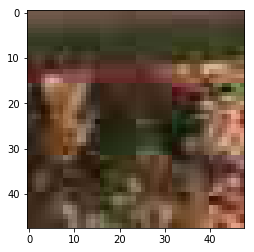

tensor([[[0.3569, 0.3804, 0.3765,  ..., 0.3333, 0.3255, 0.3216],
         [0.3098, 0.3333, 0.3451,  ..., 0.3490, 0.3333, 0.3137],
         [0.3725, 0.3686, 0.3647,  ..., 0.3294, 0.3294, 0.3176],
         ...,
         [0.2392, 0.2431, 0.2118,  ..., 0.6157, 0.4431, 0.3686],
         [0.2275, 0.2314, 0.2039,  ..., 0.7490, 0.6431, 0.6078],
         [0.2667, 0.2157, 0.2627,  ..., 0.8118, 0.7686, 0.6549]],

        [[0.3529, 0.3765, 0.3647,  ..., 0.3098, 0.3216, 0.3216],
         [0.2941, 0.3176, 0.3294,  ..., 0.3020, 0.2941, 0.2863],
         [0.3373, 0.3333, 0.3255,  ..., 0.2667, 0.2706, 0.2588],
         ...,
         [0.1961, 0.2196, 0.2039,  ..., 0.4196, 0.2471, 0.1843],
         [0.1725, 0.2039, 0.1922,  ..., 0.5490, 0.4627, 0.4353],
         [0.2157, 0.1686, 0.2235,  ..., 0.6196, 0.5882, 0.4706]],

        [[0.2824, 0.3059, 0.2980,  ..., 0.2157, 0.2118, 0.2118],
         [0.1961, 0.2196, 0.2314,  ..., 0.2078, 0.1961, 0.1843],
         [0.2235, 0.2196, 0.2196,  ..., 0.1765, 0.1804, 0.

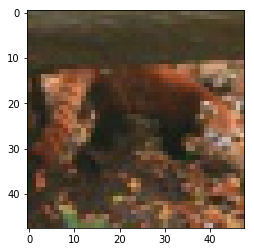

tensor([[[0.2018, 0.2652, 0.3198,  ..., 0.2286, 0.1890, 0.1643],
         [0.2253, 0.2914, 0.3452,  ..., 0.2271, 0.2153, 0.1902],
         [0.2703, 0.3120, 0.3367,  ..., 0.2656, 0.2560, 0.2483],
         ...,
         [0.1682, 0.2079, 0.2878,  ..., 0.4714, 0.4162, 0.3288],
         [0.1821, 0.2263, 0.3071,  ..., 0.4665, 0.4052, 0.3192],
         [0.1545, 0.2000, 0.2760,  ..., 0.4191, 0.3795, 0.2781]],

        [[0.1846, 0.2544, 0.3221,  ..., 0.2729, 0.2484, 0.1842],
         [0.2538, 0.3030, 0.3544,  ..., 0.2533, 0.2296, 0.2093],
         [0.2780, 0.3201, 0.3586,  ..., 0.2799, 0.2599, 0.2553],
         ...,
         [0.1653, 0.2242, 0.2893,  ..., 0.4664, 0.4068, 0.3398],
         [0.1860, 0.2310, 0.3039,  ..., 0.4497, 0.4035, 0.3301],
         [0.1464, 0.2153, 0.2782,  ..., 0.4371, 0.3863, 0.2956]],

        [[0.1689, 0.2110, 0.2920,  ..., 0.2606, 0.2100, 0.1701],
         [0.2186, 0.2274, 0.3055,  ..., 0.2267, 0.1875, 0.1889],
         [0.2531, 0.2561, 0.3019,  ..., 0.2408, 0.2047, 0.

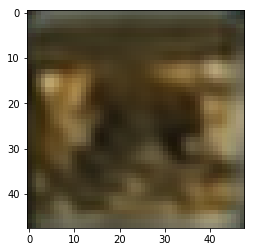


101it [00:17,  2.27it/s]
102it [00:17,  2.79it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



103it [00:17,  3.35it/s]
104it [00:17,  3.95it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



105it [00:17,  4.47it/s]
106it [00:18,  4.90it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



107it [00:18,  5.30it/s]
108it [00:18,  5.65it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



109it [00:18,  5.86it/s]
110it [00:18,  5.98it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



111it [00:18,  6.08it/s]
112it [00:19,  6.06it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



113it [00:19,  6.05it/s]
114it [00:19,  6.19it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



115it [00:19,  6.28it/s]
116it [00:19,  6.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



117it [00:19,  6.35it/s]
118it [00:19,  6.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



119it [00:20,  6.26it/s]
120it [00:20,  6.35it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



121it [00:20,  6.37it/s]
122it [00:20,  6.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



123it [00:20,  6.49it/s]
124it [00:20,  6.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



125it [00:21,  6.53it/s]
126it [00:21,  6.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



127it [00:21,  6.33it/s]
128it [00:21,  6.22it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



129it [00:21,  6.24it/s]
130it [00:21,  6.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



131it [00:21,  6.37it/s]
132it [00:22,  6.32it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



133it [00:22,  6.34it/s]
134it [00:22,  6.30it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



135it [00:22,  6.37it/s]
136it [00:22,  6.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



137it [00:22,  6.48it/s]
138it [00:23,  6.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



139it [00:23,  6.31it/s]
140it [00:23,  6.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



141it [00:23,  6.39it/s]
142it [00:23,  6.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



143it [00:23,  6.49it/s]
144it [00:24,  6.52it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



145it [00:24,  6.52it/s]
146it [00:24,  6.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



147it [00:24,  6.32it/s]
148it [00:24,  6.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



149it [00:24,  6.48it/s]
150it [00:24,  6.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



151it [00:25,  6.22it/s]
152it [00:25,  6.11it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



153it [00:25,  6.16it/s]
154it [00:25,  6.24it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



155it [00:25,  6.38it/s]
156it [00:25,  6.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



157it [00:26,  6.47it/s]
158it [00:26,  6.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



159it [00:26,  6.45it/s]
160it [00:26,  6.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



161it [00:26,  6.47it/s]
162it [00:26,  6.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



163it [00:26,  6.59it/s]
164it [00:27,  6.68it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



165it [00:27,  6.62it/s]
166it [00:27,  6.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



167it [00:27,  6.52it/s]
168it [00:27,  6.61it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



169it [00:27,  6.58it/s]
170it [00:28,  6.64it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



171it [00:28,  6.58it/s]
172it [00:28,  6.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



173it [00:28,  6.47it/s]
174it [00:28,  6.57it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



175it [00:28,  6.55it/s]
176it [00:28,  6.59it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



177it [00:29,  6.58it/s]
178it [00:29,  6.66it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



179it [00:29,  6.47it/s]
180it [00:29,  6.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



181it [00:29,  6.47it/s]
182it [00:29,  6.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



183it [00:30,  6.45it/s]
184it [00:30,  6.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



185it [00:30,  6.47it/s]
186it [00:30,  6.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



187it [00:30,  6.47it/s]
188it [00:30,  6.60it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



189it [00:30,  6.67it/s]
190it [00:31,  6.65it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



191it [00:31,  6.65it/s]
192it [00:31,  6.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



193it [00:31,  6.30it/s]
194it [00:31,  6.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



195it [00:31,  6.52it/s]
196it [00:32,  6.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



197it [00:32,  6.59it/s]
198it [00:32,  6.65it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



199it [00:32,  6.44it/s]
200it [00:32,  6.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
Epoch:  2 | train loss: 0.0082
decoded:  torch.Size([1, 3, 48, 48])
torch.Size([1, 3, 48, 48])
tensor([[[0.4392, 0.4392, 0.4392,  ..., 0.3882, 0.3843, 0.3804],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3608, 0.3569],
         [0.3882, 0.3882, 0.3882,  ..., 0.3255, 0.3176, 0.3176],
         ...,
         [0.2392, 0.2510, 0.2667,  ..., 0.7451, 0.6196, 0.5059],
         [0.2471, 0.2549, 0.2706,  ..., 0.8039, 0.6510, 0.4863],
         [0.2510, 0.2588, 0.2706,  ..., 0.8941, 0.8863, 0.7961]],

        [[0.3490, 0.3490, 0.3490,  ..., 0.2902, 0.2863, 0.2824],
         [0.3373, 0.3373, 0.3373,  ..., 0.2745, 0.2706, 0.2667],
         [0.3216, 0.3216, 0.3216,  ..., 0.2549, 0.2471, 0.2471],
         ...,
         [0.1647, 0.1765, 0.1922,  ..., 0.4784, 0.3529, 0.2392],
         [0.1725, 0.1804, 0.1961,  ..., 0.5412, 0.3765, 0.2118],
         [0.1765, 0.1843, 0.1961,  ..., 0.6314, 0.6118, 0.5216]],

        [[0.2941,

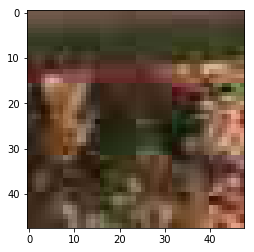

tensor([[[0.3569, 0.3804, 0.3765,  ..., 0.3333, 0.3255, 0.3216],
         [0.3098, 0.3333, 0.3451,  ..., 0.3490, 0.3333, 0.3137],
         [0.3725, 0.3686, 0.3647,  ..., 0.3294, 0.3294, 0.3176],
         ...,
         [0.2392, 0.2431, 0.2118,  ..., 0.6157, 0.4431, 0.3686],
         [0.2275, 0.2314, 0.2039,  ..., 0.7490, 0.6431, 0.6078],
         [0.2667, 0.2157, 0.2627,  ..., 0.8118, 0.7686, 0.6549]],

        [[0.3529, 0.3765, 0.3647,  ..., 0.3098, 0.3216, 0.3216],
         [0.2941, 0.3176, 0.3294,  ..., 0.3020, 0.2941, 0.2863],
         [0.3373, 0.3333, 0.3255,  ..., 0.2667, 0.2706, 0.2588],
         ...,
         [0.1961, 0.2196, 0.2039,  ..., 0.4196, 0.2471, 0.1843],
         [0.1725, 0.2039, 0.1922,  ..., 0.5490, 0.4627, 0.4353],
         [0.2157, 0.1686, 0.2235,  ..., 0.6196, 0.5882, 0.4706]],

        [[0.2824, 0.3059, 0.2980,  ..., 0.2157, 0.2118, 0.2118],
         [0.1961, 0.2196, 0.2314,  ..., 0.2078, 0.1961, 0.1843],
         [0.2235, 0.2196, 0.2196,  ..., 0.1765, 0.1804, 0.

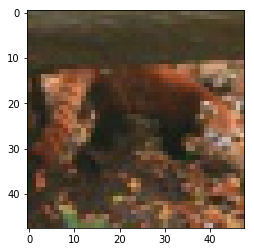

tensor([[[0.2140, 0.2772, 0.3333,  ..., 0.2451, 0.1967, 0.1693],
         [0.2417, 0.3065, 0.3606,  ..., 0.2417, 0.2196, 0.1925],
         [0.2890, 0.3288, 0.3529,  ..., 0.2670, 0.2447, 0.2382],
         ...,
         [0.1835, 0.2165, 0.2836,  ..., 0.4675, 0.4183, 0.3373],
         [0.1872, 0.2196, 0.2840,  ..., 0.4599, 0.4042, 0.3255],
         [0.1526, 0.1865, 0.2491,  ..., 0.4023, 0.3667, 0.2740]],

        [[0.1953, 0.2679, 0.3345,  ..., 0.2899, 0.2566, 0.1887],
         [0.2667, 0.3152, 0.3649,  ..., 0.2673, 0.2312, 0.2087],
         [0.2895, 0.3300, 0.3666,  ..., 0.2853, 0.2522, 0.2463],
         ...,
         [0.1752, 0.2256, 0.2805,  ..., 0.4516, 0.3967, 0.3406],
         [0.1870, 0.2200, 0.2778,  ..., 0.4305, 0.3909, 0.3285],
         [0.1411, 0.1989, 0.2468,  ..., 0.4089, 0.3646, 0.2869]],

        [[0.1780, 0.2220, 0.3030,  ..., 0.2714, 0.2172, 0.1729],
         [0.2269, 0.2325, 0.3056,  ..., 0.2340, 0.1885, 0.1860],
         [0.2585, 0.2586, 0.2968,  ..., 0.2480, 0.2023, 0.

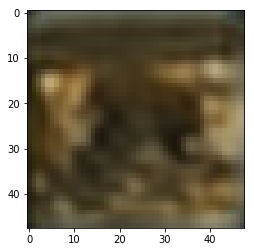


201it [00:33,  3.14it/s]
202it [00:33,  3.60it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



203it [00:33,  4.15it/s]
204it [00:33,  4.68it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



205it [00:33,  5.15it/s]
206it [00:34,  5.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



207it [00:34,  5.75it/s]
208it [00:34,  5.94it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



209it [00:34,  5.97it/s]
210it [00:34,  6.24it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



211it [00:34,  6.17it/s]
212it [00:35,  6.26it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



213it [00:35,  6.32it/s]
214it [00:35,  6.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



215it [00:35,  6.12it/s]
216it [00:35,  6.21it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



217it [00:35,  6.36it/s]
218it [00:35,  6.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



219it [00:36,  6.49it/s]
220it [00:36,  6.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



221it [00:36,  6.51it/s]
222it [00:36,  6.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



223it [00:36,  6.32it/s]
224it [00:36,  6.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



225it [00:37,  6.44it/s]
226it [00:37,  6.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



227it [00:37,  6.49it/s]
228it [00:37,  6.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



229it [00:37,  6.34it/s]
230it [00:37,  6.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



231it [00:38,  6.44it/s]
232it [00:38,  6.57it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



233it [00:38,  6.52it/s]
234it [00:38,  6.57it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



235it [00:38,  6.35it/s]
236it [00:38,  6.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



237it [00:38,  6.44it/s]
238it [00:39,  6.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



239it [00:39,  6.50it/s]
240it [00:39,  6.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



241it [00:39,  6.46it/s]
242it [00:39,  6.35it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



243it [00:39,  6.44it/s]
244it [00:40,  6.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



245it [00:40,  6.47it/s]
246it [00:40,  6.52it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



247it [00:40,  6.47it/s]
248it [00:40,  6.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



249it [00:40,  6.35it/s]
250it [00:40,  6.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



251it [00:41,  6.47it/s]
252it [00:41,  6.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



253it [00:41,  6.49it/s]
254it [00:41,  6.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



255it [00:41,  6.27it/s]
256it [00:41,  6.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



257it [00:42,  6.47it/s]
258it [00:42,  6.59it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



259it [00:42,  6.56it/s]
260it [00:42,  6.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



261it [00:42,  6.50it/s]
262it [00:42,  6.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



263it [00:42,  6.49it/s]
264it [00:43,  6.52it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



265it [00:43,  6.63it/s]
266it [00:43,  6.60it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



267it [00:43,  6.52it/s]
268it [00:43,  6.52it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



269it [00:43,  6.30it/s]
270it [00:44,  6.32it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



271it [00:44,  6.33it/s]
272it [00:44,  6.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



273it [00:44,  6.38it/s]
274it [00:44,  6.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



275it [00:44,  6.41it/s]
276it [00:44,  6.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



277it [00:45,  6.49it/s]
278it [00:45,  6.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



279it [00:45,  6.57it/s]
280it [00:45,  6.61it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



281it [00:45,  6.54it/s]
282it [00:45,  6.25it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



283it [00:46,  6.17it/s]
284it [00:46,  6.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



285it [00:46,  6.39it/s]
286it [00:46,  6.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



287it [00:46,  6.50it/s]
288it [00:46,  6.62it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



289it [00:46,  6.47it/s]
290it [00:47,  6.57it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



291it [00:47,  6.52it/s]
292it [00:47,  6.52it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



293it [00:47,  6.42it/s]
294it [00:47,  6.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



295it [00:47,  6.46it/s]
296it [00:48,  6.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



297it [00:48,  6.49it/s]
298it [00:48,  6.62it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



299it [00:48,  6.57it/s]
300it [00:48,  6.63it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
Epoch:  2 | train loss: 0.0072
decoded:  torch.Size([1, 3, 48, 48])
torch.Size([1, 3, 48, 48])
tensor([[[0.4392, 0.4392, 0.4392,  ..., 0.3882, 0.3843, 0.3804],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3608, 0.3569],
         [0.3882, 0.3882, 0.3882,  ..., 0.3255, 0.3176, 0.3176],
         ...,
         [0.2392, 0.2510, 0.2667,  ..., 0.7451, 0.6196, 0.5059],
         [0.2471, 0.2549, 0.2706,  ..., 0.8039, 0.6510, 0.4863],
         [0.2510, 0.2588, 0.2706,  ..., 0.8941, 0.8863, 0.7961]],

        [[0.3490, 0.3490, 0.3490,  ..., 0.2902, 0.2863, 0.2824],
         [0.3373, 0.3373, 0.3373,  ..., 0.2745, 0.2706, 0.2667],
         [0.3216, 0.3216, 0.3216,  ..., 0.2549, 0.2471, 0.2471],
         ...,
         [0.1647, 0.1765, 0.1922,  ..., 0.4784, 0.3529, 0.2392],
         [0.1725, 0.1804, 0.1961,  ..., 0.5412, 0.3765, 0.2118],
         [0.1765, 0.1843, 0.1961,  ..., 0.6314, 0.6118, 0.5216]],

        [[0.2941,

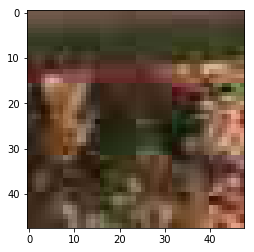

tensor([[[0.3569, 0.3804, 0.3765,  ..., 0.3333, 0.3255, 0.3216],
         [0.3098, 0.3333, 0.3451,  ..., 0.3490, 0.3333, 0.3137],
         [0.3725, 0.3686, 0.3647,  ..., 0.3294, 0.3294, 0.3176],
         ...,
         [0.2392, 0.2431, 0.2118,  ..., 0.6157, 0.4431, 0.3686],
         [0.2275, 0.2314, 0.2039,  ..., 0.7490, 0.6431, 0.6078],
         [0.2667, 0.2157, 0.2627,  ..., 0.8118, 0.7686, 0.6549]],

        [[0.3529, 0.3765, 0.3647,  ..., 0.3098, 0.3216, 0.3216],
         [0.2941, 0.3176, 0.3294,  ..., 0.3020, 0.2941, 0.2863],
         [0.3373, 0.3333, 0.3255,  ..., 0.2667, 0.2706, 0.2588],
         ...,
         [0.1961, 0.2196, 0.2039,  ..., 0.4196, 0.2471, 0.1843],
         [0.1725, 0.2039, 0.1922,  ..., 0.5490, 0.4627, 0.4353],
         [0.2157, 0.1686, 0.2235,  ..., 0.6196, 0.5882, 0.4706]],

        [[0.2824, 0.3059, 0.2980,  ..., 0.2157, 0.2118, 0.2118],
         [0.1961, 0.2196, 0.2314,  ..., 0.2078, 0.1961, 0.1843],
         [0.2235, 0.2196, 0.2196,  ..., 0.1765, 0.1804, 0.

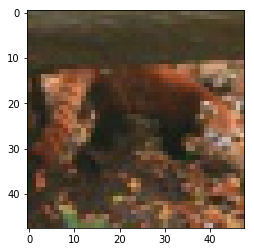

tensor([[[0.2290, 0.2909, 0.3465,  ..., 0.2467, 0.2024, 0.1776],
         [0.2607, 0.3280, 0.3836,  ..., 0.2499, 0.2312, 0.2083],
         [0.3048, 0.3491, 0.3802,  ..., 0.2808, 0.2597, 0.2554],
         ...,
         [0.1962, 0.2282, 0.2893,  ..., 0.4863, 0.4409, 0.3643],
         [0.2013, 0.2296, 0.2839,  ..., 0.4756, 0.4220, 0.3476],
         [0.1664, 0.1938, 0.2493,  ..., 0.4156, 0.3777, 0.2850]],

        [[0.2071, 0.2803, 0.3419,  ..., 0.2834, 0.2574, 0.1917],
         [0.2811, 0.3271, 0.3753,  ..., 0.2632, 0.2346, 0.2169],
         [0.2963, 0.3317, 0.3693,  ..., 0.2918, 0.2615, 0.2589],
         ...,
         [0.1801, 0.2244, 0.2759,  ..., 0.4558, 0.4090, 0.3570],
         [0.1939, 0.2203, 0.2659,  ..., 0.4339, 0.4024, 0.3408],
         [0.1445, 0.1993, 0.2368,  ..., 0.4106, 0.3682, 0.2910]],

        [[0.1931, 0.2404, 0.3149,  ..., 0.2686, 0.2206, 0.1759],
         [0.2430, 0.2527, 0.3184,  ..., 0.2352, 0.1948, 0.1928],
         [0.2725, 0.2777, 0.3086,  ..., 0.2650, 0.2183, 0.

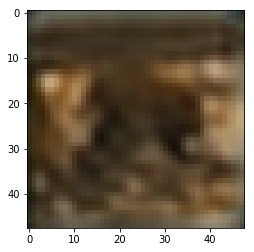


301it [00:49,  3.18it/s]
302it [00:49,  3.72it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



303it [00:49,  4.27it/s]
304it [00:49,  4.81it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



305it [00:49,  5.14it/s]
306it [00:50,  5.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



307it [00:50,  5.85it/s]
308it [00:50,  6.10it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



309it [00:50,  6.21it/s]
310it [00:50,  6.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



311it [00:50,  6.41it/s]
312it [00:51,  6.36it/s]
313it [00:51,  6.12it/s]
0it [00:00, ?it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([16, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
Epoch:  3 | train loss: 0.0080
decoded:  torch.Size([1, 3, 48, 48])
torch.Size([1, 3, 48, 48])
tensor([[[0.4392, 0.4392, 0.4392,  ..., 0.3882, 0.3843, 0.3804],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3608, 0.3569],
         [0.3882, 0.3882, 0.3882,  ..., 0.3255, 0.3176, 0.3176],
         ...,
         [0.2392, 0.2510, 0.2667,  ..., 0.7451, 0.6196, 0.5059],
         [0.2471, 0.2549, 0.2706,  ..., 0.8039, 0.6510, 0.4863],
         [0.2510, 0.2588, 0.2706,  ..., 0.8941, 0.8863, 0.7961]],

        [[0.3490, 0.3490, 0.3490,  ..., 0.2902, 0.2863, 0.2824],
         [0.3373, 0.3373, 0.3373,  ..., 0.2745, 0.2706, 0.2667],
         [0.3216, 0.3216, 0.3216,  ..., 0.2549, 0.2471, 0.2471],
         ...,
         [0.1647, 0.1765, 0.1922,  ..., 0.4784, 0.3529, 0.2392],
         [0.1725, 0.1804, 0.1961,  ..., 0.5412, 0.3765, 0.2118],
         [0.1765, 0.1843, 0.1961,  ..., 0.6314

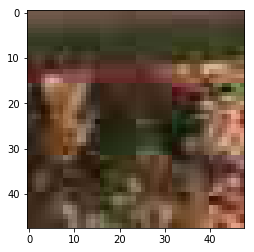

tensor([[[0.3569, 0.3804, 0.3765,  ..., 0.3333, 0.3255, 0.3216],
         [0.3098, 0.3333, 0.3451,  ..., 0.3490, 0.3333, 0.3137],
         [0.3725, 0.3686, 0.3647,  ..., 0.3294, 0.3294, 0.3176],
         ...,
         [0.2392, 0.2431, 0.2118,  ..., 0.6157, 0.4431, 0.3686],
         [0.2275, 0.2314, 0.2039,  ..., 0.7490, 0.6431, 0.6078],
         [0.2667, 0.2157, 0.2627,  ..., 0.8118, 0.7686, 0.6549]],

        [[0.3529, 0.3765, 0.3647,  ..., 0.3098, 0.3216, 0.3216],
         [0.2941, 0.3176, 0.3294,  ..., 0.3020, 0.2941, 0.2863],
         [0.3373, 0.3333, 0.3255,  ..., 0.2667, 0.2706, 0.2588],
         ...,
         [0.1961, 0.2196, 0.2039,  ..., 0.4196, 0.2471, 0.1843],
         [0.1725, 0.2039, 0.1922,  ..., 0.5490, 0.4627, 0.4353],
         [0.2157, 0.1686, 0.2235,  ..., 0.6196, 0.5882, 0.4706]],

        [[0.2824, 0.3059, 0.2980,  ..., 0.2157, 0.2118, 0.2118],
         [0.1961, 0.2196, 0.2314,  ..., 0.2078, 0.1961, 0.1843],
         [0.2235, 0.2196, 0.2196,  ..., 0.1765, 0.1804, 0.

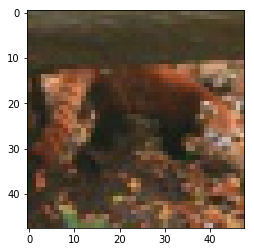

tensor([[[0.2321, 0.2929, 0.3471,  ..., 0.2524, 0.2064, 0.1802],
         [0.2649, 0.3294, 0.3808,  ..., 0.2521, 0.2333, 0.2094],
         [0.3091, 0.3486, 0.3735,  ..., 0.2788, 0.2589, 0.2549],
         ...,
         [0.2036, 0.2344, 0.2946,  ..., 0.4891, 0.4407, 0.3592],
         [0.2102, 0.2395, 0.2946,  ..., 0.4784, 0.4220, 0.3430],
         [0.1742, 0.2047, 0.2623,  ..., 0.4190, 0.3779, 0.2823]],

        [[0.2098, 0.2818, 0.3413,  ..., 0.2888, 0.2619, 0.1947],
         [0.2844, 0.3272, 0.3712,  ..., 0.2658, 0.2375, 0.2194],
         [0.2993, 0.3308, 0.3623,  ..., 0.2922, 0.2637, 0.2609],
         ...,
         [0.1838, 0.2282, 0.2808,  ..., 0.4629, 0.4090, 0.3510],
         [0.2004, 0.2286, 0.2766,  ..., 0.4431, 0.4047, 0.3368],
         [0.1516, 0.2102, 0.2504,  ..., 0.4188, 0.3711, 0.2885]],

        [[0.1937, 0.2392, 0.3113,  ..., 0.2665, 0.2196, 0.1750],
         [0.2432, 0.2486, 0.3096,  ..., 0.2297, 0.1924, 0.1915],
         [0.2722, 0.2719, 0.2972,  ..., 0.2588, 0.2154, 0.

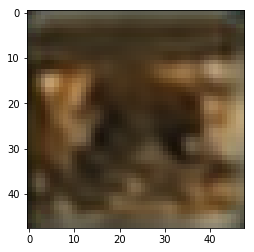


1it [00:00,  1.46it/s]
2it [00:00,  1.90it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



3it [00:01,  2.40it/s]
4it [00:01,  2.95it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



5it [00:01,  3.53it/s]
6it [00:01,  4.12it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



7it [00:01,  4.66it/s]
8it [00:01,  5.18it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



9it [00:01,  5.42it/s]
10it [00:02,  5.75it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



11it [00:02,  6.03it/s]
12it [00:02,  6.25it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



13it [00:02,  6.37it/s]
14it [00:02,  6.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



15it [00:02,  6.52it/s]
16it [00:02,  6.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



17it [00:03,  6.48it/s]
18it [00:03,  6.59it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



19it [00:03,  6.48it/s]
20it [00:03,  6.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



21it [00:03,  6.51it/s]
22it [00:03,  6.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



23it [00:04,  6.48it/s]
24it [00:04,  6.57it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



25it [00:04,  6.57it/s]
26it [00:04,  6.66it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



27it [00:04,  6.63it/s]
28it [00:04,  6.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



29it [00:04,  6.42it/s]
30it [00:05,  6.32it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



31it [00:05,  6.17it/s]
32it [00:05,  6.32it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



33it [00:05,  6.34it/s]
34it [00:05,  6.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



35it [00:05,  6.45it/s]
36it [00:06,  6.35it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



37it [00:06,  6.44it/s]
38it [00:06,  6.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



39it [00:06,  6.56it/s]
40it [00:06,  6.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



41it [00:06,  6.37it/s]
42it [00:06,  6.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



43it [00:07,  6.42it/s]
44it [00:07,  6.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



45it [00:07,  6.44it/s]
46it [00:07,  6.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



47it [00:07,  6.62it/s]
48it [00:07,  6.66it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



49it [00:08,  6.66it/s]
50it [00:08,  6.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



51it [00:08,  6.45it/s]
52it [00:08,  6.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



53it [00:08,  6.53it/s]
54it [00:08,  6.60it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



55it [00:08,  6.62it/s]
56it [00:09,  6.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



57it [00:09,  6.54it/s]
58it [00:09,  6.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



59it [00:09,  6.54it/s]
60it [00:09,  6.62it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



61it [00:09,  6.52it/s]
62it [00:10,  6.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



63it [00:10,  6.39it/s]
64it [00:10,  6.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



65it [00:10,  6.42it/s]
66it [00:10,  6.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



67it [00:10,  6.51it/s]
68it [00:10,  6.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



69it [00:11,  6.51it/s]
70it [00:11,  6.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



71it [00:11,  6.41it/s]
72it [00:11,  6.52it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



73it [00:11,  6.56it/s]
74it [00:11,  6.60it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



75it [00:12,  6.62it/s]
76it [00:12,  6.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



77it [00:12,  6.52it/s]
78it [00:12,  6.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



79it [00:12,  6.48it/s]
80it [00:12,  6.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



81it [00:12,  6.55it/s]
82it [00:13,  6.64it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



83it [00:13,  6.40it/s]
84it [00:13,  6.52it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



85it [00:13,  6.52it/s]
86it [00:13,  6.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



87it [00:13,  6.55it/s]
88it [00:14,  6.68it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



89it [00:14,  6.62it/s]
90it [00:14,  6.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



91it [00:14,  6.47it/s]
92it [00:14,  6.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



93it [00:14,  6.49it/s]
94it [00:14,  6.52it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



95it [00:15,  6.52it/s]
96it [00:15,  6.52it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



97it [00:15,  6.38it/s]
98it [00:15,  6.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



99it [00:15,  6.27it/s]
100it [00:15,  6.28it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
Epoch:  3 | train loss: 0.0070
decoded:  torch.Size([1, 3, 48, 48])
torch.Size([1, 3, 48, 48])
tensor([[[0.4392, 0.4392, 0.4392,  ..., 0.3882, 0.3843, 0.3804],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3608, 0.3569],
         [0.3882, 0.3882, 0.3882,  ..., 0.3255, 0.3176, 0.3176],
         ...,
         [0.2392, 0.2510, 0.2667,  ..., 0.7451, 0.6196, 0.5059],
         [0.2471, 0.2549, 0.2706,  ..., 0.8039, 0.6510, 0.4863],
         [0.2510, 0.2588, 0.2706,  ..., 0.8941, 0.8863, 0.7961]],

        [[0.3490, 0.3490, 0.3490,  ..., 0.2902, 0.2863, 0.2824],
         [0.3373, 0.3373, 0.3373,  ..., 0.2745, 0.2706, 0.2667],
         [0.3216, 0.3216, 0.3216,  ..., 0.2549, 0.2471, 0.2471],
         ...,
         [0.1647, 0.1765, 0.1922,  ..., 0.4784, 0.3529, 0.2392],
         [0.1725, 0.1804, 0.1961,  ..., 0.5412, 0.3765, 0.2118],
         [0.1765, 0.1843, 0.1961,  ..., 0.6314, 0.6118, 0.5216]],

        [[0.2941,

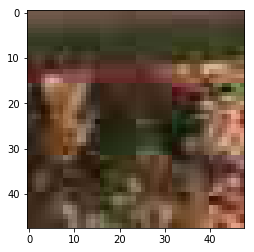

tensor([[[0.3569, 0.3804, 0.3765,  ..., 0.3333, 0.3255, 0.3216],
         [0.3098, 0.3333, 0.3451,  ..., 0.3490, 0.3333, 0.3137],
         [0.3725, 0.3686, 0.3647,  ..., 0.3294, 0.3294, 0.3176],
         ...,
         [0.2392, 0.2431, 0.2118,  ..., 0.6157, 0.4431, 0.3686],
         [0.2275, 0.2314, 0.2039,  ..., 0.7490, 0.6431, 0.6078],
         [0.2667, 0.2157, 0.2627,  ..., 0.8118, 0.7686, 0.6549]],

        [[0.3529, 0.3765, 0.3647,  ..., 0.3098, 0.3216, 0.3216],
         [0.2941, 0.3176, 0.3294,  ..., 0.3020, 0.2941, 0.2863],
         [0.3373, 0.3333, 0.3255,  ..., 0.2667, 0.2706, 0.2588],
         ...,
         [0.1961, 0.2196, 0.2039,  ..., 0.4196, 0.2471, 0.1843],
         [0.1725, 0.2039, 0.1922,  ..., 0.5490, 0.4627, 0.4353],
         [0.2157, 0.1686, 0.2235,  ..., 0.6196, 0.5882, 0.4706]],

        [[0.2824, 0.3059, 0.2980,  ..., 0.2157, 0.2118, 0.2118],
         [0.1961, 0.2196, 0.2314,  ..., 0.2078, 0.1961, 0.1843],
         [0.2235, 0.2196, 0.2196,  ..., 0.1765, 0.1804, 0.

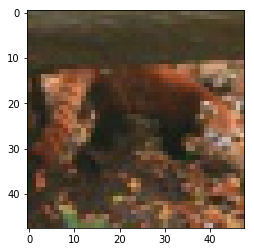

tensor([[[0.2338, 0.2906, 0.3407,  ..., 0.2531, 0.2061, 0.1811],
         [0.2644, 0.3236, 0.3701,  ..., 0.2538, 0.2314, 0.2107],
         [0.3048, 0.3386, 0.3602,  ..., 0.2766, 0.2510, 0.2513],
         ...,
         [0.2153, 0.2376, 0.2877,  ..., 0.4830, 0.4377, 0.3615],
         [0.2149, 0.2315, 0.2753,  ..., 0.4749, 0.4217, 0.3472],
         [0.1771, 0.1947, 0.2414,  ..., 0.4176, 0.3771, 0.2846]],

        [[0.2157, 0.2876, 0.3402,  ..., 0.2863, 0.2580, 0.1946],
         [0.2884, 0.3303, 0.3690,  ..., 0.2652, 0.2324, 0.2181],
         [0.3000, 0.3287, 0.3590,  ..., 0.2937, 0.2570, 0.2561],
         ...,
         [0.1975, 0.2351, 0.2819,  ..., 0.4524, 0.3988, 0.3454],
         [0.2081, 0.2254, 0.2592,  ..., 0.4302, 0.3957, 0.3326],
         [0.1550, 0.2042, 0.2310,  ..., 0.4076, 0.3626, 0.2856]],

        [[0.1954, 0.2450, 0.3103,  ..., 0.2565, 0.2106, 0.1673],
         [0.2424, 0.2552, 0.3094,  ..., 0.2218, 0.1836, 0.1834],
         [0.2669, 0.2736, 0.2939,  ..., 0.2559, 0.2082, 0.

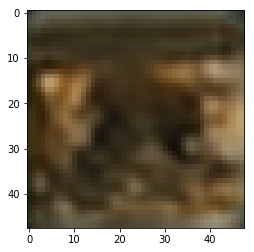


101it [00:16,  3.09it/s]
102it [00:16,  3.65it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



103it [00:16,  4.21it/s]
104it [00:17,  4.76it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



105it [00:17,  5.18it/s]
106it [00:17,  5.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



107it [00:17,  5.69it/s]
108it [00:17,  5.94it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



109it [00:17,  6.11it/s]
110it [00:18,  6.22it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



111it [00:18,  6.30it/s]
112it [00:18,  6.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



113it [00:18,  6.26it/s]
114it [00:18,  6.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



115it [00:18,  6.37it/s]
116it [00:18,  6.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



117it [00:19,  6.45it/s]
118it [00:19,  6.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



119it [00:19,  6.52it/s]
120it [00:19,  6.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



121it [00:19,  6.33it/s]
122it [00:19,  6.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



123it [00:20,  6.43it/s]
124it [00:20,  6.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



125it [00:20,  6.40it/s]
126it [00:20,  6.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



127it [00:20,  6.40it/s]
128it [00:20,  6.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



129it [00:20,  6.52it/s]
130it [00:21,  6.61it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



131it [00:21,  6.59it/s]
132it [00:21,  6.21it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



133it [00:21,  6.19it/s]
134it [00:21,  6.26it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



135it [00:21,  6.31it/s]
136it [00:22,  6.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



137it [00:22,  6.44it/s]
138it [00:22,  6.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



139it [00:22,  6.27it/s]
140it [00:22,  6.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



141it [00:22,  6.42it/s]
142it [00:22,  6.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



143it [00:23,  6.45it/s]
144it [00:23,  6.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



145it [00:23,  6.34it/s]
146it [00:23,  6.26it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



147it [00:23,  6.31it/s]
148it [00:23,  6.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



149it [00:24,  6.35it/s]
150it [00:24,  6.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



151it [00:24,  6.43it/s]
152it [00:24,  6.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



153it [00:24,  6.18it/s]
154it [00:24,  6.19it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



155it [00:25,  6.29it/s]
156it [00:25,  6.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



157it [00:25,  6.35it/s]
158it [00:25,  6.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



159it [00:25,  6.20it/s]
160it [00:25,  6.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



161it [00:25,  6.39it/s]
162it [00:26,  6.17it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



163it [00:26,  6.25it/s]
164it [00:26,  6.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



165it [00:26,  6.29it/s]
166it [00:26,  6.27it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



167it [00:26,  6.31it/s]
168it [00:27,  6.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



169it [00:27,  6.37it/s]
170it [00:27,  6.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



171it [00:27,  6.44it/s]
172it [00:27,  6.13it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



173it [00:27,  6.13it/s]
174it [00:28,  6.24it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



175it [00:28,  6.28it/s]
176it [00:28,  6.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



177it [00:28,  6.39it/s]
178it [00:28,  6.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



179it [00:28,  6.31it/s]
180it [00:29,  6.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



181it [00:29,  6.38it/s]
182it [00:29,  6.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



183it [00:29,  6.39it/s]
184it [00:29,  6.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



185it [00:29,  6.36it/s]
186it [00:29,  6.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



187it [00:30,  6.37it/s]
188it [00:30,  6.52it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



189it [00:30,  6.43it/s]
190it [00:30,  6.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



191it [00:30,  6.41it/s]
192it [00:30,  6.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



193it [00:31,  6.41it/s]
194it [00:31,  6.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



195it [00:31,  6.46it/s]
196it [00:31,  6.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



197it [00:31,  6.38it/s]
198it [00:31,  6.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



199it [00:31,  6.28it/s]
200it [00:32,  6.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
Epoch:  3 | train loss: 0.0062
decoded:  torch.Size([1, 3, 48, 48])
torch.Size([1, 3, 48, 48])
tensor([[[0.4392, 0.4392, 0.4392,  ..., 0.3882, 0.3843, 0.3804],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3608, 0.3569],
         [0.3882, 0.3882, 0.3882,  ..., 0.3255, 0.3176, 0.3176],
         ...,
         [0.2392, 0.2510, 0.2667,  ..., 0.7451, 0.6196, 0.5059],
         [0.2471, 0.2549, 0.2706,  ..., 0.8039, 0.6510, 0.4863],
         [0.2510, 0.2588, 0.2706,  ..., 0.8941, 0.8863, 0.7961]],

        [[0.3490, 0.3490, 0.3490,  ..., 0.2902, 0.2863, 0.2824],
         [0.3373, 0.3373, 0.3373,  ..., 0.2745, 0.2706, 0.2667],
         [0.3216, 0.3216, 0.3216,  ..., 0.2549, 0.2471, 0.2471],
         ...,
         [0.1647, 0.1765, 0.1922,  ..., 0.4784, 0.3529, 0.2392],
         [0.1725, 0.1804, 0.1961,  ..., 0.5412, 0.3765, 0.2118],
         [0.1765, 0.1843, 0.1961,  ..., 0.6314, 0.6118, 0.5216]],

        [[0.2941,

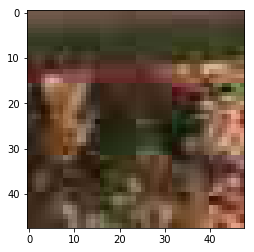

tensor([[[0.3569, 0.3804, 0.3765,  ..., 0.3333, 0.3255, 0.3216],
         [0.3098, 0.3333, 0.3451,  ..., 0.3490, 0.3333, 0.3137],
         [0.3725, 0.3686, 0.3647,  ..., 0.3294, 0.3294, 0.3176],
         ...,
         [0.2392, 0.2431, 0.2118,  ..., 0.6157, 0.4431, 0.3686],
         [0.2275, 0.2314, 0.2039,  ..., 0.7490, 0.6431, 0.6078],
         [0.2667, 0.2157, 0.2627,  ..., 0.8118, 0.7686, 0.6549]],

        [[0.3529, 0.3765, 0.3647,  ..., 0.3098, 0.3216, 0.3216],
         [0.2941, 0.3176, 0.3294,  ..., 0.3020, 0.2941, 0.2863],
         [0.3373, 0.3333, 0.3255,  ..., 0.2667, 0.2706, 0.2588],
         ...,
         [0.1961, 0.2196, 0.2039,  ..., 0.4196, 0.2471, 0.1843],
         [0.1725, 0.2039, 0.1922,  ..., 0.5490, 0.4627, 0.4353],
         [0.2157, 0.1686, 0.2235,  ..., 0.6196, 0.5882, 0.4706]],

        [[0.2824, 0.3059, 0.2980,  ..., 0.2157, 0.2118, 0.2118],
         [0.1961, 0.2196, 0.2314,  ..., 0.2078, 0.1961, 0.1843],
         [0.2235, 0.2196, 0.2196,  ..., 0.1765, 0.1804, 0.

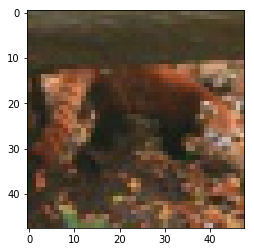

tensor([[[0.2423, 0.3008, 0.3554,  ..., 0.2713, 0.2183, 0.1893],
         [0.2707, 0.3309, 0.3824,  ..., 0.2683, 0.2397, 0.2162],
         [0.3102, 0.3453, 0.3754,  ..., 0.2895, 0.2540, 0.2530],
         ...,
         [0.2272, 0.2455, 0.3007,  ..., 0.4916, 0.4383, 0.3588],
         [0.2269, 0.2389, 0.2856,  ..., 0.4827, 0.4266, 0.3483],
         [0.1882, 0.2047, 0.2530,  ..., 0.4274, 0.3850, 0.2876]],

        [[0.2243, 0.3006, 0.3549,  ..., 0.3020, 0.2694, 0.2047],
         [0.2932, 0.3375, 0.3800,  ..., 0.2783, 0.2407, 0.2280],
         [0.3018, 0.3330, 0.3705,  ..., 0.3102, 0.2645, 0.2638],
         ...,
         [0.2085, 0.2429, 0.2952,  ..., 0.4648, 0.3985, 0.3408],
         [0.2209, 0.2359, 0.2729,  ..., 0.4458, 0.4021, 0.3323],
         [0.1672, 0.2170, 0.2454,  ..., 0.4217, 0.3721, 0.2880]],

        [[0.2085, 0.2651, 0.3316,  ..., 0.2737, 0.2235, 0.1774],
         [0.2512, 0.2688, 0.3230,  ..., 0.2337, 0.1935, 0.1936],
         [0.2719, 0.2825, 0.3037,  ..., 0.2647, 0.2134, 0.

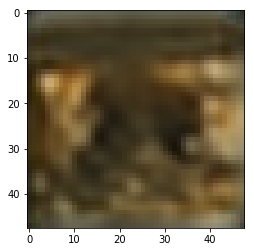


201it [00:32,  3.09it/s]
202it [00:33,  3.57it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



203it [00:33,  4.12it/s]
204it [00:33,  4.66it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



205it [00:33,  5.08it/s]
206it [00:33,  5.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



207it [00:33,  5.67it/s]
208it [00:33,  5.62it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



209it [00:34,  5.78it/s]
210it [00:34,  6.02it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



211it [00:34,  6.07it/s]
212it [00:34,  6.18it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



213it [00:34,  6.22it/s]
214it [00:34,  6.22it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



215it [00:35,  6.18it/s]
216it [00:35,  6.17it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



217it [00:35,  6.15it/s]
218it [00:35,  6.18it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



219it [00:35,  6.23it/s]
220it [00:35,  6.32it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



221it [00:36,  5.96it/s]
222it [00:36,  6.07it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



223it [00:36,  6.12it/s]
224it [00:36,  6.00it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



225it [00:36,  5.97it/s]
226it [00:36,  6.04it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



227it [00:37,  5.95it/s]
228it [00:37,  6.10it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



229it [00:37,  6.14it/s]
230it [00:37,  6.19it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



231it [00:37,  6.25it/s]
232it [00:37,  6.27it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



233it [00:38,  6.30it/s]
234it [00:38,  6.20it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



235it [00:38,  6.15it/s]
236it [00:38,  6.19it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



237it [00:38,  6.07it/s]
238it [00:38,  6.04it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



239it [00:38,  6.12it/s]
240it [00:39,  5.96it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



241it [00:39,  6.01it/s]
242it [00:39,  5.99it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



243it [00:39,  6.05it/s]
244it [00:39,  6.00it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



245it [00:40,  5.89it/s]
246it [00:40,  5.92it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



247it [00:40,  5.96it/s]
248it [00:40,  5.92it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



249it [00:40,  5.90it/s]
250it [00:40,  5.95it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



251it [00:41,  5.91it/s]
252it [00:41,  5.88it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



253it [00:41,  5.85it/s]
254it [00:41,  5.95it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



255it [00:41,  5.97it/s]
256it [00:41,  6.04it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



257it [00:42,  5.84it/s]
258it [00:42,  5.80it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



259it [00:42,  5.89it/s]
260it [00:42,  5.89it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



261it [00:42,  5.97it/s]
262it [00:42,  5.96it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



263it [00:43,  5.92it/s]
264it [00:43,  5.83it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



265it [00:43,  5.88it/s]
266it [00:43,  5.97it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



267it [00:43,  5.94it/s]
268it [00:43,  6.06it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



269it [00:44,  5.93it/s]
270it [00:44,  5.70it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



271it [00:44,  5.70it/s]
272it [00:44,  5.84it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



273it [00:44,  5.85it/s]
274it [00:44,  5.80it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



275it [00:45,  5.80it/s]
276it [00:45,  5.70it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



277it [00:45,  5.81it/s]
278it [00:45,  5.85it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



279it [00:45,  5.84it/s]
280it [00:45,  5.89it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



281it [00:46,  5.80it/s]
282it [00:46,  5.65it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



283it [00:46,  5.70it/s]
284it [00:46,  5.80it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



285it [00:46,  5.74it/s]
286it [00:47,  5.59it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



287it [00:47,  5.50it/s]
288it [00:47,  5.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



289it [00:47,  5.41it/s]
290it [00:47,  5.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



291it [00:47,  5.49it/s]
292it [00:48,  5.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



293it [00:48,  5.53it/s]
294it [00:48,  5.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



295it [00:48,  5.33it/s]
296it [00:48,  5.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



297it [00:49,  5.29it/s]
298it [00:49,  5.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



299it [00:49,  5.28it/s]
300it [00:49,  5.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
Epoch:  3 | train loss: 0.0086
decoded:  torch.Size([1, 3, 48, 48])
torch.Size([1, 3, 48, 48])
tensor([[[0.4392, 0.4392, 0.4392,  ..., 0.3882, 0.3843, 0.3804],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3608, 0.3569],
         [0.3882, 0.3882, 0.3882,  ..., 0.3255, 0.3176, 0.3176],
         ...,
         [0.2392, 0.2510, 0.2667,  ..., 0.7451, 0.6196, 0.5059],
         [0.2471, 0.2549, 0.2706,  ..., 0.8039, 0.6510, 0.4863],
         [0.2510, 0.2588, 0.2706,  ..., 0.8941, 0.8863, 0.7961]],

        [[0.3490, 0.3490, 0.3490,  ..., 0.2902, 0.2863, 0.2824],
         [0.3373, 0.3373, 0.3373,  ..., 0.2745, 0.2706, 0.2667],
         [0.3216, 0.3216, 0.3216,  ..., 0.2549, 0.2471, 0.2471],
         ...,
         [0.1647, 0.1765, 0.1922,  ..., 0.4784, 0.3529, 0.2392],
         [0.1725, 0.1804, 0.1961,  ..., 0.5412, 0.3765, 0.2118],
         [0.1765, 0.1843, 0.1961,  ..., 0.6314, 0.6118, 0.5216]],

        [[0.2941,

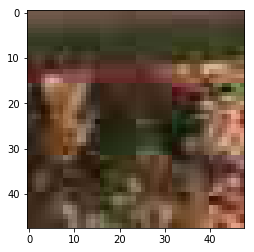

tensor([[[0.3569, 0.3804, 0.3765,  ..., 0.3333, 0.3255, 0.3216],
         [0.3098, 0.3333, 0.3451,  ..., 0.3490, 0.3333, 0.3137],
         [0.3725, 0.3686, 0.3647,  ..., 0.3294, 0.3294, 0.3176],
         ...,
         [0.2392, 0.2431, 0.2118,  ..., 0.6157, 0.4431, 0.3686],
         [0.2275, 0.2314, 0.2039,  ..., 0.7490, 0.6431, 0.6078],
         [0.2667, 0.2157, 0.2627,  ..., 0.8118, 0.7686, 0.6549]],

        [[0.3529, 0.3765, 0.3647,  ..., 0.3098, 0.3216, 0.3216],
         [0.2941, 0.3176, 0.3294,  ..., 0.3020, 0.2941, 0.2863],
         [0.3373, 0.3333, 0.3255,  ..., 0.2667, 0.2706, 0.2588],
         ...,
         [0.1961, 0.2196, 0.2039,  ..., 0.4196, 0.2471, 0.1843],
         [0.1725, 0.2039, 0.1922,  ..., 0.5490, 0.4627, 0.4353],
         [0.2157, 0.1686, 0.2235,  ..., 0.6196, 0.5882, 0.4706]],

        [[0.2824, 0.3059, 0.2980,  ..., 0.2157, 0.2118, 0.2118],
         [0.1961, 0.2196, 0.2314,  ..., 0.2078, 0.1961, 0.1843],
         [0.2235, 0.2196, 0.2196,  ..., 0.1765, 0.1804, 0.

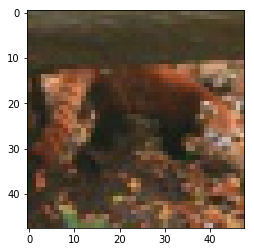

tensor([[[0.2526, 0.3102, 0.3618,  ..., 0.2909, 0.2334, 0.2014],
         [0.2832, 0.3377, 0.3818,  ..., 0.2846, 0.2553, 0.2327],
         [0.3215, 0.3470, 0.3694,  ..., 0.3012, 0.2679, 0.2716],
         ...,
         [0.2382, 0.2529, 0.3008,  ..., 0.4998, 0.4487, 0.3675],
         [0.2355, 0.2434, 0.2831,  ..., 0.4928, 0.4350, 0.3525],
         [0.1956, 0.2085, 0.2503,  ..., 0.4326, 0.3847, 0.2850]],

        [[0.2315, 0.3073, 0.3573,  ..., 0.3155, 0.2795, 0.2138],
         [0.2996, 0.3365, 0.3704,  ..., 0.2881, 0.2506, 0.2424],
         [0.3045, 0.3250, 0.3525,  ..., 0.3168, 0.2724, 0.2768],
         ...,
         [0.2092, 0.2370, 0.2844,  ..., 0.4614, 0.3918, 0.3300],
         [0.2205, 0.2303, 0.2582,  ..., 0.4446, 0.3959, 0.3204],
         [0.1674, 0.2126, 0.2318,  ..., 0.4111, 0.3604, 0.2753]],

        [[0.2084, 0.2648, 0.3223,  ..., 0.2686, 0.2206, 0.1759],
         [0.2476, 0.2594, 0.2992,  ..., 0.2234, 0.1899, 0.1972],
         [0.2633, 0.2653, 0.2727,  ..., 0.2563, 0.2102, 0.

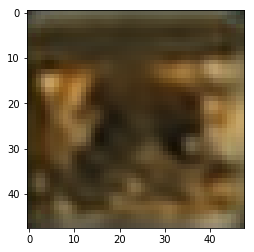


301it [00:50,  2.86it/s]
302it [00:50,  3.26it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



303it [00:50,  3.71it/s]
304it [00:50,  4.10it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



305it [00:51,  4.41it/s]
306it [00:51,  4.70it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



307it [00:51,  4.74it/s]
308it [00:51,  4.94it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



309it [00:51,  4.93it/s]
310it [00:52,  5.04it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



311it [00:52,  5.04it/s]
312it [00:52,  5.04it/s]
313it [00:52,  5.85it/s]

0it [00:00, ?it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([16, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
Epoch:  4 | train loss: 0.0068
decoded:  torch.Size([1, 3, 48, 48])
torch.Size([1, 3, 48, 48])
tensor([[[0.4392, 0.4392, 0.4392,  ..., 0.3882, 0.3843, 0.3804],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3608, 0.3569],
         [0.3882, 0.3882, 0.3882,  ..., 0.3255, 0.3176, 0.3176],
         ...,
         [0.2392, 0.2510, 0.2667,  ..., 0.7451, 0.6196, 0.5059],
         [0.2471, 0.2549, 0.2706,  ..., 0.8039, 0.6510, 0.4863],
         [0.2510, 0.2588, 0.2706,  ..., 0.8941, 0.8863, 0.7961]],

        [[0.3490, 0.3490, 0.3490,  ..., 0.2902, 0.2863, 0.2824],
         [0.3373, 0.3373, 0.3373,  ..., 0.2745, 0.2706, 0.2667],
         [0.3216, 0.3216, 0.3216,  ..., 0.2549, 0.2471, 0.2471],
         ...,
         [0.1647, 0.1765, 0.1922,  ..., 0.4784, 0.3529, 0.2392],
         [0.1725, 0.1804, 0.1961,  ..., 0.5412, 0.3765, 0.2118],
         [0.1765, 0.1843, 0.1961,  ..., 0.6314

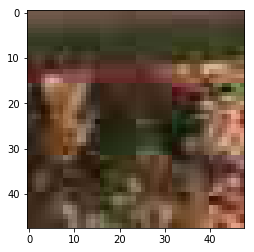

tensor([[[0.3569, 0.3804, 0.3765,  ..., 0.3333, 0.3255, 0.3216],
         [0.3098, 0.3333, 0.3451,  ..., 0.3490, 0.3333, 0.3137],
         [0.3725, 0.3686, 0.3647,  ..., 0.3294, 0.3294, 0.3176],
         ...,
         [0.2392, 0.2431, 0.2118,  ..., 0.6157, 0.4431, 0.3686],
         [0.2275, 0.2314, 0.2039,  ..., 0.7490, 0.6431, 0.6078],
         [0.2667, 0.2157, 0.2627,  ..., 0.8118, 0.7686, 0.6549]],

        [[0.3529, 0.3765, 0.3647,  ..., 0.3098, 0.3216, 0.3216],
         [0.2941, 0.3176, 0.3294,  ..., 0.3020, 0.2941, 0.2863],
         [0.3373, 0.3333, 0.3255,  ..., 0.2667, 0.2706, 0.2588],
         ...,
         [0.1961, 0.2196, 0.2039,  ..., 0.4196, 0.2471, 0.1843],
         [0.1725, 0.2039, 0.1922,  ..., 0.5490, 0.4627, 0.4353],
         [0.2157, 0.1686, 0.2235,  ..., 0.6196, 0.5882, 0.4706]],

        [[0.2824, 0.3059, 0.2980,  ..., 0.2157, 0.2118, 0.2118],
         [0.1961, 0.2196, 0.2314,  ..., 0.2078, 0.1961, 0.1843],
         [0.2235, 0.2196, 0.2196,  ..., 0.1765, 0.1804, 0.

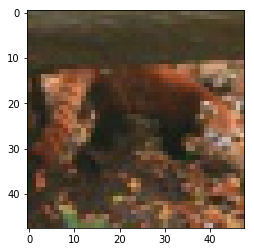

tensor([[[0.2458, 0.3013, 0.3511,  ..., 0.2928, 0.2357, 0.2028],
         [0.2728, 0.3294, 0.3747,  ..., 0.2929, 0.2601, 0.2337],
         [0.3146, 0.3457, 0.3705,  ..., 0.3139, 0.2732, 0.2711],
         ...,
         [0.2365, 0.2545, 0.3054,  ..., 0.5081, 0.4569, 0.3755],
         [0.2317, 0.2416, 0.2827,  ..., 0.5012, 0.4451, 0.3645],
         [0.1920, 0.2045, 0.2467,  ..., 0.4396, 0.3953, 0.2963]],

        [[0.2302, 0.3066, 0.3561,  ..., 0.3222, 0.2840, 0.2169],
         [0.2992, 0.3409, 0.3769,  ..., 0.3025, 0.2596, 0.2466],
         [0.3095, 0.3358, 0.3666,  ..., 0.3346, 0.2816, 0.2808],
         ...,
         [0.2111, 0.2412, 0.2907,  ..., 0.4685, 0.4044, 0.3432],
         [0.2222, 0.2330, 0.2624,  ..., 0.4545, 0.4127, 0.3367],
         [0.1675, 0.2122, 0.2316,  ..., 0.4227, 0.3758, 0.2907]],

        [[0.2133, 0.2743, 0.3361,  ..., 0.2867, 0.2314, 0.1832],
         [0.2570, 0.2791, 0.3271,  ..., 0.2559, 0.2102, 0.2099],
         [0.2802, 0.2955, 0.3118,  ..., 0.2911, 0.2318, 0.

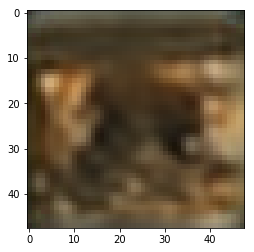


1it [00:00,  1.42it/s]
2it [00:00,  1.82it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



3it [00:01,  2.27it/s]
4it [00:01,  2.76it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



5it [00:01,  3.24it/s]
6it [00:01,  3.71it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



7it [00:01,  4.11it/s]
8it [00:02,  4.30it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



9it [00:02,  4.64it/s]
10it [00:02,  4.84it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



11it [00:02,  5.05it/s]
12it [00:02,  5.16it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



13it [00:02,  5.31it/s]
14it [00:03,  5.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



15it [00:03,  5.37it/s]
16it [00:03,  5.25it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



17it [00:03,  5.34it/s]
18it [00:03,  5.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



19it [00:04,  5.31it/s]
20it [00:04,  5.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



21it [00:04,  5.56it/s]
22it [00:04,  5.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



23it [00:04,  5.36it/s]
24it [00:04,  5.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



25it [00:05,  5.35it/s]
26it [00:05,  5.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



27it [00:05,  5.46it/s]
28it [00:05,  5.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



29it [00:05,  5.42it/s]
30it [00:06,  5.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



31it [00:06,  5.44it/s]
32it [00:06,  5.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



33it [00:06,  5.52it/s]
34it [00:06,  5.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



35it [00:06,  5.48it/s]
36it [00:07,  5.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



37it [00:07,  5.48it/s]
38it [00:07,  5.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



39it [00:07,  5.48it/s]
40it [00:07,  5.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



41it [00:08,  5.45it/s]
42it [00:08,  5.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



43it [00:08,  5.39it/s]
44it [00:08,  5.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



45it [00:08,  5.33it/s]
46it [00:08,  5.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



47it [00:09,  5.25it/s]
48it [00:09,  5.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



49it [00:09,  5.38it/s]
50it [00:09,  5.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



51it [00:09,  5.39it/s]
52it [00:10,  5.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



53it [00:10,  5.46it/s]
54it [00:10,  5.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



55it [00:10,  5.49it/s]
56it [00:10,  5.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



57it [00:11,  5.50it/s]
58it [00:11,  5.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



59it [00:11,  5.40it/s]
60it [00:11,  5.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



61it [00:11,  5.35it/s]
62it [00:11,  5.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



63it [00:12,  5.42it/s]
64it [00:12,  5.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



65it [00:12,  5.42it/s]
66it [00:12,  5.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



67it [00:12,  5.41it/s]
68it [00:13,  5.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



69it [00:13,  5.30it/s]
70it [00:13,  5.27it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



71it [00:13,  5.35it/s]
72it [00:13,  5.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



73it [00:13,  5.39it/s]
74it [00:14,  5.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



75it [00:14,  5.26it/s]
76it [00:14,  5.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



77it [00:14,  5.38it/s]
78it [00:14,  5.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



79it [00:15,  5.39it/s]
80it [00:15,  5.26it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



81it [00:15,  5.23it/s]
82it [00:15,  5.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



83it [00:15,  5.30it/s]
84it [00:16,  5.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



85it [00:16,  5.39it/s]
86it [00:16,  5.30it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



87it [00:16,  5.38it/s]
88it [00:16,  5.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



89it [00:16,  5.44it/s]
90it [00:17,  5.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



91it [00:17,  5.42it/s]
92it [00:17,  5.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



93it [00:17,  5.42it/s]
94it [00:17,  5.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



95it [00:18,  5.45it/s]
96it [00:18,  5.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



97it [00:18,  5.29it/s]
98it [00:18,  5.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



99it [00:18,  5.45it/s]
100it [00:18,  5.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
Epoch:  4 | train loss: 0.0072
decoded:  torch.Size([1, 3, 48, 48])
torch.Size([1, 3, 48, 48])
tensor([[[0.4392, 0.4392, 0.4392,  ..., 0.3882, 0.3843, 0.3804],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3608, 0.3569],
         [0.3882, 0.3882, 0.3882,  ..., 0.3255, 0.3176, 0.3176],
         ...,
         [0.2392, 0.2510, 0.2667,  ..., 0.7451, 0.6196, 0.5059],
         [0.2471, 0.2549, 0.2706,  ..., 0.8039, 0.6510, 0.4863],
         [0.2510, 0.2588, 0.2706,  ..., 0.8941, 0.8863, 0.7961]],

        [[0.3490, 0.3490, 0.3490,  ..., 0.2902, 0.2863, 0.2824],
         [0.3373, 0.3373, 0.3373,  ..., 0.2745, 0.2706, 0.2667],
         [0.3216, 0.3216, 0.3216,  ..., 0.2549, 0.2471, 0.2471],
         ...,
         [0.1647, 0.1765, 0.1922,  ..., 0.4784, 0.3529, 0.2392],
         [0.1725, 0.1804, 0.1961,  ..., 0.5412, 0.3765, 0.2118],
         [0.1765, 0.1843, 0.1961,  ..., 0.6314, 0.6118, 0.5216]],

        [[0.2941,

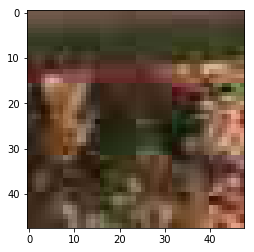

tensor([[[0.3569, 0.3804, 0.3765,  ..., 0.3333, 0.3255, 0.3216],
         [0.3098, 0.3333, 0.3451,  ..., 0.3490, 0.3333, 0.3137],
         [0.3725, 0.3686, 0.3647,  ..., 0.3294, 0.3294, 0.3176],
         ...,
         [0.2392, 0.2431, 0.2118,  ..., 0.6157, 0.4431, 0.3686],
         [0.2275, 0.2314, 0.2039,  ..., 0.7490, 0.6431, 0.6078],
         [0.2667, 0.2157, 0.2627,  ..., 0.8118, 0.7686, 0.6549]],

        [[0.3529, 0.3765, 0.3647,  ..., 0.3098, 0.3216, 0.3216],
         [0.2941, 0.3176, 0.3294,  ..., 0.3020, 0.2941, 0.2863],
         [0.3373, 0.3333, 0.3255,  ..., 0.2667, 0.2706, 0.2588],
         ...,
         [0.1961, 0.2196, 0.2039,  ..., 0.4196, 0.2471, 0.1843],
         [0.1725, 0.2039, 0.1922,  ..., 0.5490, 0.4627, 0.4353],
         [0.2157, 0.1686, 0.2235,  ..., 0.6196, 0.5882, 0.4706]],

        [[0.2824, 0.3059, 0.2980,  ..., 0.2157, 0.2118, 0.2118],
         [0.1961, 0.2196, 0.2314,  ..., 0.2078, 0.1961, 0.1843],
         [0.2235, 0.2196, 0.2196,  ..., 0.1765, 0.1804, 0.

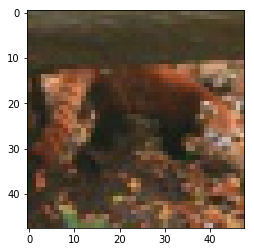

tensor([[[0.2563, 0.3158, 0.3682,  ..., 0.2962, 0.2391, 0.2072],
         [0.2820, 0.3382, 0.3838,  ..., 0.2903, 0.2614, 0.2399],
         [0.3194, 0.3450, 0.3691,  ..., 0.3094, 0.2750, 0.2803],
         ...,
         [0.2324, 0.2495, 0.3019,  ..., 0.4977, 0.4509, 0.3684],
         [0.2239, 0.2325, 0.2743,  ..., 0.4861, 0.4357, 0.3544],
         [0.1883, 0.2008, 0.2407,  ..., 0.4308, 0.3879, 0.2893]],

        [[0.2418, 0.3212, 0.3747,  ..., 0.3262, 0.2885, 0.2235],
         [0.3099, 0.3495, 0.3865,  ..., 0.3064, 0.2661, 0.2601],
         [0.3151, 0.3389, 0.3695,  ..., 0.3397, 0.2898, 0.2952],
         ...,
         [0.2129, 0.2441, 0.2976,  ..., 0.4775, 0.4068, 0.3384],
         [0.2203, 0.2339, 0.2633,  ..., 0.4568, 0.4058, 0.3278],
         [0.1683, 0.2135, 0.2323,  ..., 0.4199, 0.3712, 0.2855]],

        [[0.2248, 0.2879, 0.3483,  ..., 0.2851, 0.2341, 0.1880],
         [0.2648, 0.2825, 0.3253,  ..., 0.2496, 0.2149, 0.2216],
         [0.2806, 0.2863, 0.2967,  ..., 0.2845, 0.2352, 0.

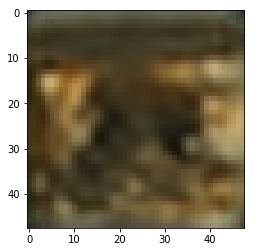


101it [00:19,  2.91it/s]
102it [00:19,  3.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



103it [00:20,  3.80it/s]
104it [00:20,  4.24it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



105it [00:20,  4.52it/s]
106it [00:20,  4.70it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



107it [00:20,  4.83it/s]
108it [00:21,  5.09it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



109it [00:21,  5.23it/s]
110it [00:21,  5.29it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



111it [00:21,  5.26it/s]
112it [00:21,  5.29it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



113it [00:21,  5.28it/s]
114it [00:22,  5.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



115it [00:22,  5.44it/s]
116it [00:22,  5.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



117it [00:22,  5.33it/s]
118it [00:22,  5.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



119it [00:23,  5.34it/s]
120it [00:23,  5.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



121it [00:23,  5.47it/s]
122it [00:23,  5.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



123it [00:23,  5.44it/s]
124it [00:23,  5.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



125it [00:24,  5.48it/s]
126it [00:24,  5.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



127it [00:24,  5.56it/s]
128it [00:24,  5.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



129it [00:24,  5.49it/s]
130it [00:25,  5.57it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



131it [00:25,  5.60it/s]
132it [00:25,  5.63it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



133it [00:25,  5.50it/s]
134it [00:25,  5.35it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



135it [00:25,  5.30it/s]
136it [00:26,  5.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



137it [00:26,  5.43it/s]
138it [00:26,  5.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



139it [00:26,  5.46it/s]
140it [00:26,  5.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



141it [00:27,  5.51it/s]
142it [00:27,  5.52it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



143it [00:27,  5.39it/s]
144it [00:27,  5.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



145it [00:27,  5.42it/s]
146it [00:27,  5.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



147it [00:28,  5.50it/s]
148it [00:28,  5.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



149it [00:28,  5.54it/s]
150it [00:28,  5.65it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



151it [00:28,  5.49it/s]
152it [00:29,  5.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



153it [00:29,  5.55it/s]
154it [00:29,  5.52it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



155it [00:29,  5.55it/s]
156it [00:29,  5.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  


157it [00:29,  5.44it/s]

torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



158it [00:30,  5.50it/s]
159it [00:30,  5.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



160it [00:30,  5.50it/s]
161it [00:30,  5.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



162it [00:30,  5.47it/s]
163it [00:31,  5.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



164it [00:31,  5.52it/s]
165it [00:31,  5.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



166it [00:31,  5.58it/s]
167it [00:31,  5.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



168it [00:31,  5.47it/s]
169it [00:32,  5.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



170it [00:32,  5.36it/s]
171it [00:32,  5.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



172it [00:32,  5.53it/s]
173it [00:32,  5.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



174it [00:33,  5.48it/s]
175it [00:33,  5.61it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



176it [00:33,  5.60it/s]
177it [00:33,  5.66it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



178it [00:33,  5.59it/s]
179it [00:33,  5.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



180it [00:34,  5.54it/s]
181it [00:34,  5.64it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



182it [00:34,  5.62it/s]
183it [00:34,  5.68it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



184it [00:34,  5.66it/s]
185it [00:35,  5.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



186it [00:35,  5.58it/s]
187it [00:35,  5.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



188it [00:35,  5.53it/s]
189it [00:35,  5.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



190it [00:35,  5.56it/s]
191it [00:36,  5.29it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



192it [00:36,  5.29it/s]
193it [00:36,  5.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



194it [00:36,  5.55it/s]
195it [00:36,  5.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



196it [00:37,  5.50it/s]
197it [00:37,  5.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



198it [00:37,  5.44it/s]
199it [00:37,  5.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



200it [00:37,  5.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
Epoch:  4 | train loss: 0.0063
decoded:  torch.Size([1, 3, 48, 48])
torch.Size([1, 3, 48, 48])
tensor([[[0.4392, 0.4392, 0.4392,  ..., 0.3882, 0.3843, 0.3804],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3608, 0.3569],
         [0.3882, 0.3882, 0.3882,  ..., 0.3255, 0.3176, 0.3176],
         ...,
         [0.2392, 0.2510, 0.2667,  ..., 0.7451, 0.6196, 0.5059],
         [0.2471, 0.2549, 0.2706,  ..., 0.8039, 0.6510, 0.4863],
         [0.2510, 0.2588, 0.2706,  ..., 0.8941, 0.8863, 0.7961]],

        [[0.3490, 0.3490, 0.3490,  ..., 0.2902, 0.2863, 0.2824],
         [0.3373, 0.3373, 0.3373,  ..., 0.2745, 0.2706, 0.2667],
         [0.3216, 0.3216, 0.3216,  ..., 0.2549, 0.2471, 0.2471],
         ...,
         [0.1647, 0.1765, 0.1922,  ..., 0.4784, 0.3529, 0.2392],
         [0.1725, 0.1804, 0.1961,  ..., 0.5412, 0.3765, 0.2118],
         [0.1765, 0.1843, 0.1961,  ..., 0.6314, 0.6118, 0.5216]],

        [[0.2941, 0.2941, 0.2941,  ..., 0.2627, 0.2588,

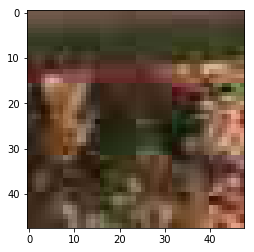

tensor([[[0.3569, 0.3804, 0.3765,  ..., 0.3333, 0.3255, 0.3216],
         [0.3098, 0.3333, 0.3451,  ..., 0.3490, 0.3333, 0.3137],
         [0.3725, 0.3686, 0.3647,  ..., 0.3294, 0.3294, 0.3176],
         ...,
         [0.2392, 0.2431, 0.2118,  ..., 0.6157, 0.4431, 0.3686],
         [0.2275, 0.2314, 0.2039,  ..., 0.7490, 0.6431, 0.6078],
         [0.2667, 0.2157, 0.2627,  ..., 0.8118, 0.7686, 0.6549]],

        [[0.3529, 0.3765, 0.3647,  ..., 0.3098, 0.3216, 0.3216],
         [0.2941, 0.3176, 0.3294,  ..., 0.3020, 0.2941, 0.2863],
         [0.3373, 0.3333, 0.3255,  ..., 0.2667, 0.2706, 0.2588],
         ...,
         [0.1961, 0.2196, 0.2039,  ..., 0.4196, 0.2471, 0.1843],
         [0.1725, 0.2039, 0.1922,  ..., 0.5490, 0.4627, 0.4353],
         [0.2157, 0.1686, 0.2235,  ..., 0.6196, 0.5882, 0.4706]],

        [[0.2824, 0.3059, 0.2980,  ..., 0.2157, 0.2118, 0.2118],
         [0.1961, 0.2196, 0.2314,  ..., 0.2078, 0.1961, 0.1843],
         [0.2235, 0.2196, 0.2196,  ..., 0.1765, 0.1804, 0.

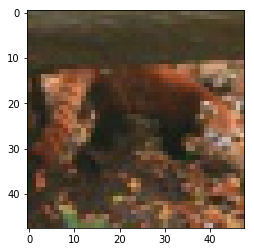

tensor([[[0.2691, 0.3266, 0.3736,  ..., 0.3046, 0.2442, 0.2104],
         [0.2923, 0.3435, 0.3828,  ..., 0.2904, 0.2607, 0.2379],
         [0.3263, 0.3439, 0.3629,  ..., 0.3012, 0.2645, 0.2704],
         ...,
         [0.2371, 0.2521, 0.3030,  ..., 0.4869, 0.4470, 0.3664],
         [0.2284, 0.2345, 0.2715,  ..., 0.4781, 0.4327, 0.3566],
         [0.1940, 0.2039, 0.2380,  ..., 0.4258, 0.3846, 0.2918]],

        [[0.2476, 0.3254, 0.3722,  ..., 0.3252, 0.2851, 0.2198],
         [0.3112, 0.3439, 0.3722,  ..., 0.2942, 0.2551, 0.2514],
         [0.3123, 0.3276, 0.3498,  ..., 0.3187, 0.2694, 0.2765],
         ...,
         [0.2099, 0.2369, 0.2893,  ..., 0.4569, 0.3929, 0.3276],
         [0.2190, 0.2284, 0.2506,  ..., 0.4381, 0.3942, 0.3214],
         [0.1682, 0.2108, 0.2222,  ..., 0.4069, 0.3617, 0.2847]],

        [[0.2236, 0.2858, 0.3383,  ..., 0.2815, 0.2304, 0.1851],
         [0.2589, 0.2735, 0.3048,  ..., 0.2362, 0.2047, 0.2154],
         [0.2708, 0.2727, 0.2723,  ..., 0.2648, 0.2166, 0.

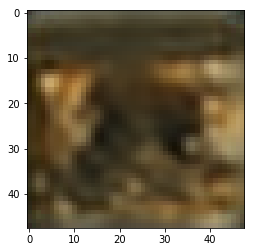


201it [00:38,  2.90it/s]
202it [00:38,  3.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



203it [00:38,  3.83it/s]
204it [00:39,  4.26it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



205it [00:39,  4.46it/s]
206it [00:39,  4.82it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



207it [00:39,  4.96it/s]
208it [00:39,  5.10it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



209it [00:39,  5.25it/s]
210it [00:40,  5.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



211it [00:40,  5.36it/s]
212it [00:40,  5.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



213it [00:40,  5.50it/s]
214it [00:40,  5.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



215it [00:40,  5.64it/s]
216it [00:41,  5.78it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



217it [00:41,  5.68it/s]
218it [00:41,  5.71it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



219it [00:41,  5.64it/s]
220it [00:41,  5.65it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



221it [00:42,  5.73it/s]
222it [00:42,  5.65it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



223it [00:42,  5.65it/s]
224it [00:42,  5.74it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



225it [00:42,  5.72it/s]
226it [00:42,  5.69it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



227it [00:43,  5.75it/s]
228it [00:43,  5.72it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



229it [00:43,  5.64it/s]
230it [00:43,  5.76it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



231it [00:43,  5.70it/s]
232it [00:43,  5.62it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



233it [00:44,  5.65it/s]
234it [00:44,  5.66it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



235it [00:44,  5.72it/s]
236it [00:44,  5.86it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



237it [00:44,  5.84it/s]
238it [00:45,  5.93it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



239it [00:45,  5.96it/s]
240it [00:45,  5.94it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



241it [00:45,  5.87it/s]
242it [00:45,  5.89it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



243it [00:45,  5.86it/s]
244it [00:46,  5.76it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



245it [00:46,  5.76it/s]
246it [00:46,  5.76it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



247it [00:46,  5.62it/s]
248it [00:46,  5.70it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



249it [00:46,  5.76it/s]
250it [00:47,  5.88it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



251it [00:47,  5.96it/s]
252it [00:47,  5.85it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



253it [00:47,  5.84it/s]
254it [00:47,  5.70it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



255it [00:47,  5.77it/s]
256it [00:48,  5.82it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



257it [00:48,  5.89it/s]
258it [00:48,  5.76it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



259it [00:48,  5.81it/s]
260it [00:48,  5.92it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



261it [00:48,  5.87it/s]
262it [00:49,  5.91it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



263it [00:49,  5.95it/s]
264it [00:49,  5.85it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



265it [00:49,  5.92it/s]
266it [00:49,  5.91it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



267it [00:49,  5.90it/s]
268it [00:50,  5.89it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



269it [00:50,  5.89it/s]
270it [00:50,  5.89it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



271it [00:50,  5.96it/s]
272it [00:50,  5.96it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



273it [00:50,  5.94it/s]
274it [00:51,  6.05it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



275it [00:51,  5.98it/s]
276it [00:51,  5.97it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



277it [00:51,  5.78it/s]
278it [00:51,  5.85it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



279it [00:52,  5.84it/s]
280it [00:52,  5.92it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



281it [00:52,  5.93it/s]
282it [00:52,  6.00it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



283it [00:52,  5.99it/s]
284it [00:52,  5.96it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



285it [00:52,  5.97it/s]
286it [00:53,  5.98it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



287it [00:53,  6.09it/s]
288it [00:53,  6.07it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



289it [00:53,  5.99it/s]
290it [00:53,  5.89it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



291it [00:54,  5.93it/s]
292it [00:54,  6.07it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



293it [00:54,  6.04it/s]
294it [00:54,  6.07it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



295it [00:54,  5.96it/s]
296it [00:54,  5.95it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



297it [00:54,  5.99it/s]
298it [00:55,  6.07it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



299it [00:55,  6.04it/s]
300it [00:55,  6.11it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
Epoch:  4 | train loss: 0.0068
decoded:  torch.Size([1, 3, 48, 48])
torch.Size([1, 3, 48, 48])
tensor([[[0.4392, 0.4392, 0.4392,  ..., 0.3882, 0.3843, 0.3804],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3608, 0.3569],
         [0.3882, 0.3882, 0.3882,  ..., 0.3255, 0.3176, 0.3176],
         ...,
         [0.2392, 0.2510, 0.2667,  ..., 0.7451, 0.6196, 0.5059],
         [0.2471, 0.2549, 0.2706,  ..., 0.8039, 0.6510, 0.4863],
         [0.2510, 0.2588, 0.2706,  ..., 0.8941, 0.8863, 0.7961]],

        [[0.3490, 0.3490, 0.3490,  ..., 0.2902, 0.2863, 0.2824],
         [0.3373, 0.3373, 0.3373,  ..., 0.2745, 0.2706, 0.2667],
         [0.3216, 0.3216, 0.3216,  ..., 0.2549, 0.2471, 0.2471],
         ...,
         [0.1647, 0.1765, 0.1922,  ..., 0.4784, 0.3529, 0.2392],
         [0.1725, 0.1804, 0.1961,  ..., 0.5412, 0.3765, 0.2118],
         [0.1765, 0.1843, 0.1961,  ..., 0.6314, 0.6118, 0.5216]],

        [[0.2941,

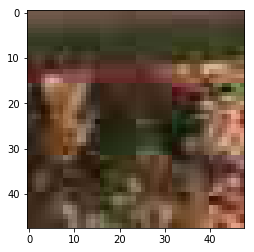

tensor([[[0.3569, 0.3804, 0.3765,  ..., 0.3333, 0.3255, 0.3216],
         [0.3098, 0.3333, 0.3451,  ..., 0.3490, 0.3333, 0.3137],
         [0.3725, 0.3686, 0.3647,  ..., 0.3294, 0.3294, 0.3176],
         ...,
         [0.2392, 0.2431, 0.2118,  ..., 0.6157, 0.4431, 0.3686],
         [0.2275, 0.2314, 0.2039,  ..., 0.7490, 0.6431, 0.6078],
         [0.2667, 0.2157, 0.2627,  ..., 0.8118, 0.7686, 0.6549]],

        [[0.3529, 0.3765, 0.3647,  ..., 0.3098, 0.3216, 0.3216],
         [0.2941, 0.3176, 0.3294,  ..., 0.3020, 0.2941, 0.2863],
         [0.3373, 0.3333, 0.3255,  ..., 0.2667, 0.2706, 0.2588],
         ...,
         [0.1961, 0.2196, 0.2039,  ..., 0.4196, 0.2471, 0.1843],
         [0.1725, 0.2039, 0.1922,  ..., 0.5490, 0.4627, 0.4353],
         [0.2157, 0.1686, 0.2235,  ..., 0.6196, 0.5882, 0.4706]],

        [[0.2824, 0.3059, 0.2980,  ..., 0.2157, 0.2118, 0.2118],
         [0.1961, 0.2196, 0.2314,  ..., 0.2078, 0.1961, 0.1843],
         [0.2235, 0.2196, 0.2196,  ..., 0.1765, 0.1804, 0.

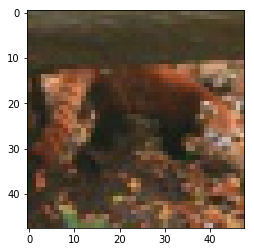

tensor([[[0.2756, 0.3280, 0.3695,  ..., 0.3059, 0.2503, 0.2178],
         [0.3038, 0.3528, 0.3895,  ..., 0.2959, 0.2705, 0.2478],
         [0.3419, 0.3584, 0.3807,  ..., 0.3113, 0.2760, 0.2793],
         ...,
         [0.2459, 0.2626, 0.3130,  ..., 0.4974, 0.4618, 0.3816],
         [0.2297, 0.2368, 0.2722,  ..., 0.4779, 0.4348, 0.3646],
         [0.1967, 0.2061, 0.2378,  ..., 0.4263, 0.3832, 0.2964]],

        [[0.2481, 0.3216, 0.3602,  ..., 0.3077, 0.2750, 0.2162],
         [0.3168, 0.3437, 0.3643,  ..., 0.2745, 0.2455, 0.2493],
         [0.3189, 0.3292, 0.3451,  ..., 0.2963, 0.2565, 0.2690],
         ...,
         [0.2045, 0.2249, 0.2732,  ..., 0.4253, 0.3744, 0.3157],
         [0.2108, 0.2157, 0.2305,  ..., 0.4081, 0.3736, 0.3101],
         [0.1608, 0.2001, 0.2066,  ..., 0.3836, 0.3418, 0.2770]],

        [[0.2260, 0.2863, 0.3320,  ..., 0.2715, 0.2242, 0.1848],
         [0.2671, 0.2825, 0.3090,  ..., 0.2308, 0.2045, 0.2206],
         [0.2804, 0.2836, 0.2803,  ..., 0.2563, 0.2126, 0.

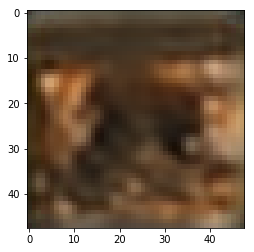


301it [00:56,  2.98it/s]
302it [00:56,  3.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



303it [00:56,  3.97it/s]
304it [00:56,  4.30it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



305it [00:56,  4.56it/s]
306it [00:57,  4.89it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



307it [00:57,  5.24it/s]
308it [00:57,  5.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



309it [00:57,  5.65it/s]
310it [00:57,  5.69it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



311it [00:57,  5.85it/s]
312it [00:58,  5.94it/s]
313it [00:58,  5.38it/s]
0it [00:00, ?it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([16, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
Epoch:  5 | train loss: 0.0065
decoded:  torch.Size([1, 3, 48, 48])
torch.Size([1, 3, 48, 48])
tensor([[[0.4392, 0.4392, 0.4392,  ..., 0.3882, 0.3843, 0.3804],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3608, 0.3569],
         [0.3882, 0.3882, 0.3882,  ..., 0.3255, 0.3176, 0.3176],
         ...,
         [0.2392, 0.2510, 0.2667,  ..., 0.7451, 0.6196, 0.5059],
         [0.2471, 0.2549, 0.2706,  ..., 0.8039, 0.6510, 0.4863],
         [0.2510, 0.2588, 0.2706,  ..., 0.8941, 0.8863, 0.7961]],

        [[0.3490, 0.3490, 0.3490,  ..., 0.2902, 0.2863, 0.2824],
         [0.3373, 0.3373, 0.3373,  ..., 0.2745, 0.2706, 0.2667],
         [0.3216, 0.3216, 0.3216,  ..., 0.2549, 0.2471, 0.2471],
         ...,
         [0.1647, 0.1765, 0.1922,  ..., 0.4784, 0.3529, 0.2392],
         [0.1725, 0.1804, 0.1961,  ..., 0.5412, 0.3765, 0.2118],
         [0.1765, 0.1843, 0.1961,  ..., 0.6314

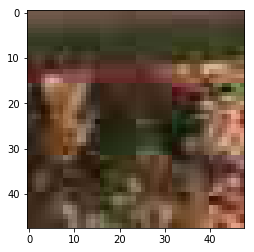

tensor([[[0.3569, 0.3804, 0.3765,  ..., 0.3333, 0.3255, 0.3216],
         [0.3098, 0.3333, 0.3451,  ..., 0.3490, 0.3333, 0.3137],
         [0.3725, 0.3686, 0.3647,  ..., 0.3294, 0.3294, 0.3176],
         ...,
         [0.2392, 0.2431, 0.2118,  ..., 0.6157, 0.4431, 0.3686],
         [0.2275, 0.2314, 0.2039,  ..., 0.7490, 0.6431, 0.6078],
         [0.2667, 0.2157, 0.2627,  ..., 0.8118, 0.7686, 0.6549]],

        [[0.3529, 0.3765, 0.3647,  ..., 0.3098, 0.3216, 0.3216],
         [0.2941, 0.3176, 0.3294,  ..., 0.3020, 0.2941, 0.2863],
         [0.3373, 0.3333, 0.3255,  ..., 0.2667, 0.2706, 0.2588],
         ...,
         [0.1961, 0.2196, 0.2039,  ..., 0.4196, 0.2471, 0.1843],
         [0.1725, 0.2039, 0.1922,  ..., 0.5490, 0.4627, 0.4353],
         [0.2157, 0.1686, 0.2235,  ..., 0.6196, 0.5882, 0.4706]],

        [[0.2824, 0.3059, 0.2980,  ..., 0.2157, 0.2118, 0.2118],
         [0.1961, 0.2196, 0.2314,  ..., 0.2078, 0.1961, 0.1843],
         [0.2235, 0.2196, 0.2196,  ..., 0.1765, 0.1804, 0.

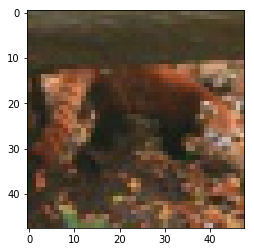

tensor([[[0.2834, 0.3373, 0.3779,  ..., 0.3010, 0.2439, 0.2126],
         [0.3085, 0.3518, 0.3844,  ..., 0.2827, 0.2587, 0.2393],
         [0.3392, 0.3437, 0.3595,  ..., 0.2861, 0.2553, 0.2651],
         ...,
         [0.2328, 0.2423, 0.2784,  ..., 0.4745, 0.4521, 0.3798],
         [0.2125, 0.2119, 0.2348,  ..., 0.4663, 0.4327, 0.3684],
         [0.1831, 0.1840, 0.2064,  ..., 0.4224, 0.3870, 0.3022]],

        [[0.2643, 0.3436, 0.3870,  ..., 0.3211, 0.2819, 0.2210],
         [0.3388, 0.3681, 0.3894,  ..., 0.2882, 0.2532, 0.2546],
         [0.3377, 0.3497, 0.3649,  ..., 0.3049, 0.2604, 0.2715],
         ...,
         [0.2108, 0.2293, 0.2738,  ..., 0.4467, 0.3973, 0.3357],
         [0.2115, 0.2127, 0.2223,  ..., 0.4317, 0.4000, 0.3315],
         [0.1580, 0.1918, 0.1937,  ..., 0.4009, 0.3609, 0.2940]],

        [[0.2398, 0.3083, 0.3578,  ..., 0.2813, 0.2281, 0.1857],
         [0.2843, 0.3066, 0.3350,  ..., 0.2379, 0.2061, 0.2201],
         [0.2961, 0.3052, 0.3046,  ..., 0.2581, 0.2110, 0.

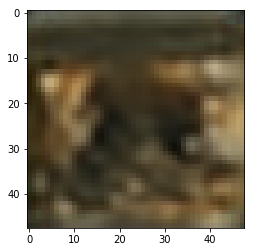


1it [00:01,  1.12s/it]
2it [00:01,  1.20it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



3it [00:01,  1.58it/s]
4it [00:01,  2.03it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



5it [00:01,  2.56it/s]
6it [00:01,  3.15it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



7it [00:02,  3.71it/s]
8it [00:02,  4.26it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



9it [00:02,  4.78it/s]
10it [00:02,  5.11it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



11it [00:02,  5.33it/s]
12it [00:02,  5.68it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



13it [00:03,  5.94it/s]
14it [00:03,  6.11it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



15it [00:03,  6.20it/s]
16it [00:03,  6.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



17it [00:03,  6.18it/s]
18it [00:03,  6.14it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



19it [00:03,  6.30it/s]
20it [00:04,  6.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



21it [00:04,  6.39it/s]
22it [00:04,  6.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



23it [00:04,  6.50it/s]
24it [00:04,  6.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



25it [00:04,  6.45it/s]
26it [00:05,  6.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



27it [00:05,  6.41it/s]
28it [00:05,  6.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



29it [00:05,  6.37it/s]
30it [00:05,  6.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



31it [00:05,  6.38it/s]
32it [00:05,  6.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



33it [00:06,  6.42it/s]
34it [00:06,  6.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



35it [00:06,  6.54it/s]
36it [00:06,  6.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



37it [00:06,  6.27it/s]
38it [00:06,  6.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



39it [00:07,  6.41it/s]
40it [00:07,  6.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



41it [00:07,  6.47it/s]
42it [00:07,  6.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



43it [00:07,  6.52it/s]
44it [00:07,  6.25it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



45it [00:07,  6.34it/s]
46it [00:08,  6.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



47it [00:08,  6.27it/s]
48it [00:08,  6.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



49it [00:08,  6.35it/s]
50it [00:08,  6.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



51it [00:08,  6.23it/s]
52it [00:09,  6.16it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



53it [00:09,  6.13it/s]
54it [00:09,  6.23it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



55it [00:09,  6.27it/s]
56it [00:09,  6.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



57it [00:09,  6.16it/s]
58it [00:10,  6.28it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



59it [00:10,  6.37it/s]
60it [00:10,  6.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



61it [00:10,  6.23it/s]
62it [00:10,  6.26it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



63it [00:10,  6.32it/s]
64it [00:11,  6.22it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



65it [00:11,  6.23it/s]
66it [00:11,  6.26it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



67it [00:11,  6.30it/s]
68it [00:11,  6.30it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



69it [00:11,  6.24it/s]
70it [00:11,  6.15it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



71it [00:12,  6.22it/s]
72it [00:12,  6.27it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



73it [00:12,  6.29it/s]
74it [00:12,  6.27it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



75it [00:12,  6.16it/s]
76it [00:12,  6.26it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



77it [00:13,  6.24it/s]
78it [00:13,  6.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



79it [00:13,  6.32it/s]
80it [00:13,  6.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



81it [00:13,  6.13it/s]
82it [00:13,  6.17it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



83it [00:14,  6.07it/s]
84it [00:14,  6.18it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



85it [00:14,  6.19it/s]
86it [00:14,  6.27it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



87it [00:14,  6.31it/s]
88it [00:14,  6.25it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



89it [00:15,  6.21it/s]
90it [00:15,  6.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



91it [00:15,  6.39it/s]
92it [00:15,  6.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



93it [00:15,  6.34it/s]
94it [00:15,  6.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



95it [00:15,  6.43it/s]
96it [00:16,  6.30it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



97it [00:16,  6.31it/s]
98it [00:16,  6.35it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



99it [00:16,  6.27it/s]
100it [00:16,  6.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
Epoch:  5 | train loss: 0.0081
decoded:  torch.Size([1, 3, 48, 48])
torch.Size([1, 3, 48, 48])
tensor([[[0.4392, 0.4392, 0.4392,  ..., 0.3882, 0.3843, 0.3804],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3608, 0.3569],
         [0.3882, 0.3882, 0.3882,  ..., 0.3255, 0.3176, 0.3176],
         ...,
         [0.2392, 0.2510, 0.2667,  ..., 0.7451, 0.6196, 0.5059],
         [0.2471, 0.2549, 0.2706,  ..., 0.8039, 0.6510, 0.4863],
         [0.2510, 0.2588, 0.2706,  ..., 0.8941, 0.8863, 0.7961]],

        [[0.3490, 0.3490, 0.3490,  ..., 0.2902, 0.2863, 0.2824],
         [0.3373, 0.3373, 0.3373,  ..., 0.2745, 0.2706, 0.2667],
         [0.3216, 0.3216, 0.3216,  ..., 0.2549, 0.2471, 0.2471],
         ...,
         [0.1647, 0.1765, 0.1922,  ..., 0.4784, 0.3529, 0.2392],
         [0.1725, 0.1804, 0.1961,  ..., 0.5412, 0.3765, 0.2118],
         [0.1765, 0.1843, 0.1961,  ..., 0.6314, 0.6118, 0.5216]],

        [[0.2941,

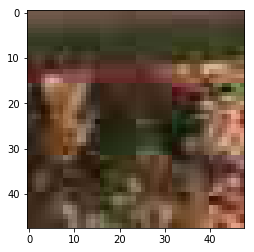

tensor([[[0.3569, 0.3804, 0.3765,  ..., 0.3333, 0.3255, 0.3216],
         [0.3098, 0.3333, 0.3451,  ..., 0.3490, 0.3333, 0.3137],
         [0.3725, 0.3686, 0.3647,  ..., 0.3294, 0.3294, 0.3176],
         ...,
         [0.2392, 0.2431, 0.2118,  ..., 0.6157, 0.4431, 0.3686],
         [0.2275, 0.2314, 0.2039,  ..., 0.7490, 0.6431, 0.6078],
         [0.2667, 0.2157, 0.2627,  ..., 0.8118, 0.7686, 0.6549]],

        [[0.3529, 0.3765, 0.3647,  ..., 0.3098, 0.3216, 0.3216],
         [0.2941, 0.3176, 0.3294,  ..., 0.3020, 0.2941, 0.2863],
         [0.3373, 0.3333, 0.3255,  ..., 0.2667, 0.2706, 0.2588],
         ...,
         [0.1961, 0.2196, 0.2039,  ..., 0.4196, 0.2471, 0.1843],
         [0.1725, 0.2039, 0.1922,  ..., 0.5490, 0.4627, 0.4353],
         [0.2157, 0.1686, 0.2235,  ..., 0.6196, 0.5882, 0.4706]],

        [[0.2824, 0.3059, 0.2980,  ..., 0.2157, 0.2118, 0.2118],
         [0.1961, 0.2196, 0.2314,  ..., 0.2078, 0.1961, 0.1843],
         [0.2235, 0.2196, 0.2196,  ..., 0.1765, 0.1804, 0.

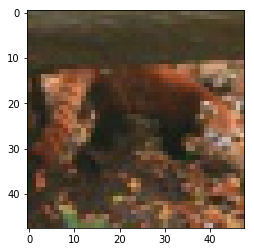

tensor([[[0.2761, 0.3292, 0.3682,  ..., 0.2942, 0.2403, 0.2099],
         [0.3017, 0.3526, 0.3873,  ..., 0.2729, 0.2542, 0.2368],
         [0.3394, 0.3576, 0.3783,  ..., 0.2795, 0.2537, 0.2657],
         ...,
         [0.2407, 0.2511, 0.2876,  ..., 0.4753, 0.4460, 0.3728],
         [0.2181, 0.2211, 0.2449,  ..., 0.4648, 0.4242, 0.3599],
         [0.1905, 0.1942, 0.2173,  ..., 0.4157, 0.3755, 0.2937]],

        [[0.2536, 0.3295, 0.3679,  ..., 0.3084, 0.2743, 0.2171],
         [0.3253, 0.3568, 0.3784,  ..., 0.2722, 0.2448, 0.2526],
         [0.3274, 0.3445, 0.3636,  ..., 0.2927, 0.2550, 0.2705],
         ...,
         [0.2120, 0.2314, 0.2775,  ..., 0.4433, 0.3859, 0.3263],
         [0.2129, 0.2166, 0.2264,  ..., 0.4265, 0.3834, 0.3205],
         [0.1611, 0.1972, 0.2007,  ..., 0.3889, 0.3407, 0.2818]],

        [[0.2274, 0.2908, 0.3336,  ..., 0.2642, 0.2159, 0.1786],
         [0.2707, 0.2932, 0.3169,  ..., 0.2200, 0.1982, 0.2184],
         [0.2831, 0.2938, 0.2893,  ..., 0.2404, 0.2045, 0.

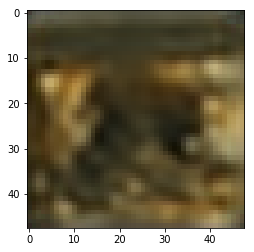


101it [00:17,  3.06it/s]
102it [00:17,  3.59it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



103it [00:17,  4.10it/s]
104it [00:17,  4.63it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



105it [00:18,  5.04it/s]
106it [00:18,  5.29it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



107it [00:18,  5.48it/s]
108it [00:18,  5.69it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



109it [00:18,  5.92it/s]
110it [00:18,  6.09it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



111it [00:19,  6.08it/s]
112it [00:19,  6.13it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



113it [00:19,  6.21it/s]
114it [00:19,  5.99it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



115it [00:19,  5.89it/s]
116it [00:19,  5.88it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



117it [00:20,  6.02it/s]
118it [00:20,  6.01it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



119it [00:20,  6.07it/s]
120it [00:20,  6.16it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



121it [00:20,  6.20it/s]
122it [00:20,  6.21it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



123it [00:21,  6.21it/s]
124it [00:21,  6.04it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



125it [00:21,  5.92it/s]
126it [00:21,  6.05it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



127it [00:21,  6.10it/s]
128it [00:21,  6.23it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



129it [00:22,  6.29it/s]
130it [00:22,  6.35it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



131it [00:22,  6.22it/s]
132it [00:22,  6.27it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



133it [00:22,  6.27it/s]
134it [00:22,  6.30it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



135it [00:22,  6.36it/s]
136it [00:23,  6.35it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



137it [00:23,  6.02it/s]
138it [00:23,  6.17it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



139it [00:23,  6.12it/s]
140it [00:23,  6.19it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



141it [00:23,  6.23it/s]
142it [00:24,  6.32it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



143it [00:24,  6.26it/s]
144it [00:24,  6.15it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



145it [00:24,  6.14it/s]
146it [00:24,  6.17it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



147it [00:24,  6.19it/s]
148it [00:25,  6.24it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



149it [00:25,  6.29it/s]
150it [00:25,  6.12it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



151it [00:25,  6.13it/s]
152it [00:25,  6.24it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



153it [00:25,  6.29it/s]
154it [00:26,  6.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



155it [00:26,  6.32it/s]
156it [00:26,  6.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



157it [00:26,  6.28it/s]
158it [00:26,  6.29it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



159it [00:26,  6.36it/s]
160it [00:26,  6.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



161it [00:27,  6.42it/s]
162it [00:27,  6.52it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



163it [00:27,  6.15it/s]
164it [00:27,  6.30it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



165it [00:27,  6.35it/s]
166it [00:27,  6.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



167it [00:28,  6.30it/s]
168it [00:28,  6.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



169it [00:28,  6.45it/s]
170it [00:28,  6.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



171it [00:28,  6.33it/s]
172it [00:28,  6.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



173it [00:29,  6.40it/s]
174it [00:29,  6.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



175it [00:29,  6.44it/s]
176it [00:29,  6.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



177it [00:29,  6.22it/s]
178it [00:29,  6.27it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



179it [00:29,  6.19it/s]
180it [00:30,  6.22it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



181it [00:30,  6.31it/s]
182it [00:30,  6.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



183it [00:30,  6.28it/s]
184it [00:30,  6.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



185it [00:30,  6.41it/s]
186it [00:31,  6.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



187it [00:31,  6.49it/s]
188it [00:31,  6.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



189it [00:31,  6.53it/s]
190it [00:31,  6.23it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



191it [00:31,  6.29it/s]
192it [00:32,  6.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



193it [00:32,  6.38it/s]
194it [00:32,  6.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



195it [00:32,  6.46it/s]
196it [00:32,  6.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



197it [00:32,  6.29it/s]
198it [00:32,  6.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



199it [00:33,  6.44it/s]
200it [00:33,  6.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
Epoch:  5 | train loss: 0.0218
decoded:  torch.Size([1, 3, 48, 48])
torch.Size([1, 3, 48, 48])
tensor([[[0.4392, 0.4392, 0.4392,  ..., 0.3882, 0.3843, 0.3804],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3608, 0.3569],
         [0.3882, 0.3882, 0.3882,  ..., 0.3255, 0.3176, 0.3176],
         ...,
         [0.2392, 0.2510, 0.2667,  ..., 0.7451, 0.6196, 0.5059],
         [0.2471, 0.2549, 0.2706,  ..., 0.8039, 0.6510, 0.4863],
         [0.2510, 0.2588, 0.2706,  ..., 0.8941, 0.8863, 0.7961]],

        [[0.3490, 0.3490, 0.3490,  ..., 0.2902, 0.2863, 0.2824],
         [0.3373, 0.3373, 0.3373,  ..., 0.2745, 0.2706, 0.2667],
         [0.3216, 0.3216, 0.3216,  ..., 0.2549, 0.2471, 0.2471],
         ...,
         [0.1647, 0.1765, 0.1922,  ..., 0.4784, 0.3529, 0.2392],
         [0.1725, 0.1804, 0.1961,  ..., 0.5412, 0.3765, 0.2118],
         [0.1765, 0.1843, 0.1961,  ..., 0.6314, 0.6118, 0.5216]],

        [[0.2941,

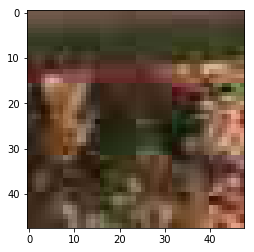

tensor([[[0.3569, 0.3804, 0.3765,  ..., 0.3333, 0.3255, 0.3216],
         [0.3098, 0.3333, 0.3451,  ..., 0.3490, 0.3333, 0.3137],
         [0.3725, 0.3686, 0.3647,  ..., 0.3294, 0.3294, 0.3176],
         ...,
         [0.2392, 0.2431, 0.2118,  ..., 0.6157, 0.4431, 0.3686],
         [0.2275, 0.2314, 0.2039,  ..., 0.7490, 0.6431, 0.6078],
         [0.2667, 0.2157, 0.2627,  ..., 0.8118, 0.7686, 0.6549]],

        [[0.3529, 0.3765, 0.3647,  ..., 0.3098, 0.3216, 0.3216],
         [0.2941, 0.3176, 0.3294,  ..., 0.3020, 0.2941, 0.2863],
         [0.3373, 0.3333, 0.3255,  ..., 0.2667, 0.2706, 0.2588],
         ...,
         [0.1961, 0.2196, 0.2039,  ..., 0.4196, 0.2471, 0.1843],
         [0.1725, 0.2039, 0.1922,  ..., 0.5490, 0.4627, 0.4353],
         [0.2157, 0.1686, 0.2235,  ..., 0.6196, 0.5882, 0.4706]],

        [[0.2824, 0.3059, 0.2980,  ..., 0.2157, 0.2118, 0.2118],
         [0.1961, 0.2196, 0.2314,  ..., 0.2078, 0.1961, 0.1843],
         [0.2235, 0.2196, 0.2196,  ..., 0.1765, 0.1804, 0.

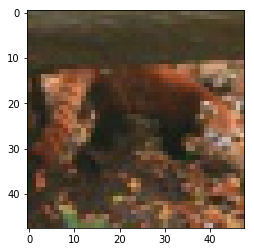

tensor([[[0.2830, 0.3508, 0.4002,  ..., 0.2806, 0.2252, 0.1995],
         [0.3061, 0.3554, 0.4053,  ..., 0.2686, 0.2493, 0.2362],
         [0.3183, 0.3277, 0.3637,  ..., 0.2689, 0.2527, 0.2669],
         ...,
         [0.1882, 0.1860, 0.2424,  ..., 0.5089, 0.4961, 0.4198],
         [0.1832, 0.1802, 0.2094,  ..., 0.4922, 0.4720, 0.4010],
         [0.1650, 0.1680, 0.1873,  ..., 0.4771, 0.4485, 0.3439]],

        [[0.2682, 0.3550, 0.4126,  ..., 0.3199, 0.2781, 0.2232],
         [0.3386, 0.3834, 0.4214,  ..., 0.3085, 0.2797, 0.2813],
         [0.3357, 0.3677, 0.4060,  ..., 0.3446, 0.3098, 0.3101],
         ...,
         [0.1939, 0.2068, 0.2656,  ..., 0.5431, 0.4852, 0.4095],
         [0.2016, 0.2048, 0.2265,  ..., 0.4984, 0.4643, 0.3829],
         [0.1564, 0.1875, 0.1969,  ..., 0.4834, 0.4397, 0.3500]],

        [[0.2572, 0.3466, 0.4053,  ..., 0.3075, 0.2596, 0.2114],
         [0.3043, 0.3631, 0.4082,  ..., 0.3040, 0.2902, 0.2866],
         [0.3119, 0.3637, 0.3857,  ..., 0.3560, 0.3318, 0.

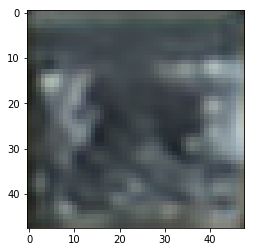


201it [00:33,  3.07it/s]
202it [00:34,  3.60it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



203it [00:34,  4.11it/s]
204it [00:34,  4.64it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



205it [00:34,  5.04it/s]
206it [00:34,  5.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



207it [00:34,  5.62it/s]
208it [00:35,  5.85it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



209it [00:35,  5.96it/s]
210it [00:35,  6.14it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



211it [00:35,  6.12it/s]
212it [00:35,  6.30it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



213it [00:35,  6.23it/s]
214it [00:36,  6.29it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



215it [00:36,  6.37it/s]
216it [00:36,  6.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



217it [00:36,  6.52it/s]
218it [00:36,  6.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



219it [00:36,  6.31it/s]
220it [00:36,  6.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



221it [00:37,  6.44it/s]
222it [00:37,  6.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



223it [00:37,  6.37it/s]
224it [00:37,  6.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



225it [00:37,  6.54it/s]
226it [00:37,  6.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



227it [00:38,  6.47it/s]
228it [00:38,  6.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



229it [00:38,  6.44it/s]
230it [00:38,  6.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



231it [00:38,  6.39it/s]
232it [00:38,  6.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



233it [00:38,  6.14it/s]
234it [00:39,  6.24it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



235it [00:39,  6.27it/s]
236it [00:39,  6.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



237it [00:39,  6.32it/s]
238it [00:39,  6.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



239it [00:39,  6.26it/s]
240it [00:40,  6.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



241it [00:40,  6.45it/s]
242it [00:40,  6.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



243it [00:40,  6.11it/s]
244it [00:40,  6.18it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



245it [00:40,  6.19it/s]
246it [00:41,  6.23it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



247it [00:41,  6.29it/s]
248it [00:41,  6.35it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



249it [00:41,  6.22it/s]
250it [00:41,  6.19it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



251it [00:41,  6.17it/s]
252it [00:42,  6.09it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



253it [00:42,  6.18it/s]
254it [00:42,  6.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



255it [00:42,  6.41it/s]
256it [00:42,  6.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



257it [00:42,  6.42it/s]
258it [00:42,  6.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



259it [00:43,  6.29it/s]
260it [00:43,  6.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



261it [00:43,  6.44it/s]
262it [00:43,  6.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



263it [00:43,  6.36it/s]
264it [00:43,  6.35it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



265it [00:44,  6.31it/s]
266it [00:44,  6.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



267it [00:44,  6.47it/s]
268it [00:44,  6.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



269it [00:44,  6.52it/s]
270it [00:44,  6.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



271it [00:44,  6.48it/s]
272it [00:45,  6.35it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



273it [00:45,  6.33it/s]
274it [00:45,  6.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



275it [00:45,  6.31it/s]
276it [00:45,  6.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



277it [00:45,  6.47it/s]
278it [00:46,  6.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



279it [00:46,  6.44it/s]
280it [00:46,  6.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



281it [00:46,  6.38it/s]
282it [00:46,  6.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



283it [00:46,  6.45it/s]
284it [00:46,  6.57it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



285it [00:47,  6.38it/s]
286it [00:47,  6.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



287it [00:47,  6.50it/s]
288it [00:47,  6.27it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



289it [00:47,  6.41it/s]
290it [00:47,  6.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



291it [00:48,  6.53it/s]
292it [00:48,  6.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



293it [00:48,  6.38it/s]
294it [00:48,  6.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



295it [00:48,  6.35it/s]
296it [00:48,  6.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



297it [00:49,  6.44it/s]
298it [00:49,  6.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



299it [00:49,  6.24it/s]
300it [00:49,  6.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
Epoch:  5 | train loss: 0.0057
decoded:  torch.Size([1, 3, 48, 48])
torch.Size([1, 3, 48, 48])
tensor([[[0.4392, 0.4392, 0.4392,  ..., 0.3882, 0.3843, 0.3804],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3608, 0.3569],
         [0.3882, 0.3882, 0.3882,  ..., 0.3255, 0.3176, 0.3176],
         ...,
         [0.2392, 0.2510, 0.2667,  ..., 0.7451, 0.6196, 0.5059],
         [0.2471, 0.2549, 0.2706,  ..., 0.8039, 0.6510, 0.4863],
         [0.2510, 0.2588, 0.2706,  ..., 0.8941, 0.8863, 0.7961]],

        [[0.3490, 0.3490, 0.3490,  ..., 0.2902, 0.2863, 0.2824],
         [0.3373, 0.3373, 0.3373,  ..., 0.2745, 0.2706, 0.2667],
         [0.3216, 0.3216, 0.3216,  ..., 0.2549, 0.2471, 0.2471],
         ...,
         [0.1647, 0.1765, 0.1922,  ..., 0.4784, 0.3529, 0.2392],
         [0.1725, 0.1804, 0.1961,  ..., 0.5412, 0.3765, 0.2118],
         [0.1765, 0.1843, 0.1961,  ..., 0.6314, 0.6118, 0.5216]],

        [[0.2941,

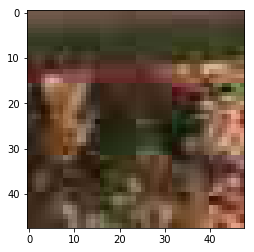

tensor([[[0.3569, 0.3804, 0.3765,  ..., 0.3333, 0.3255, 0.3216],
         [0.3098, 0.3333, 0.3451,  ..., 0.3490, 0.3333, 0.3137],
         [0.3725, 0.3686, 0.3647,  ..., 0.3294, 0.3294, 0.3176],
         ...,
         [0.2392, 0.2431, 0.2118,  ..., 0.6157, 0.4431, 0.3686],
         [0.2275, 0.2314, 0.2039,  ..., 0.7490, 0.6431, 0.6078],
         [0.2667, 0.2157, 0.2627,  ..., 0.8118, 0.7686, 0.6549]],

        [[0.3529, 0.3765, 0.3647,  ..., 0.3098, 0.3216, 0.3216],
         [0.2941, 0.3176, 0.3294,  ..., 0.3020, 0.2941, 0.2863],
         [0.3373, 0.3333, 0.3255,  ..., 0.2667, 0.2706, 0.2588],
         ...,
         [0.1961, 0.2196, 0.2039,  ..., 0.4196, 0.2471, 0.1843],
         [0.1725, 0.2039, 0.1922,  ..., 0.5490, 0.4627, 0.4353],
         [0.2157, 0.1686, 0.2235,  ..., 0.6196, 0.5882, 0.4706]],

        [[0.2824, 0.3059, 0.2980,  ..., 0.2157, 0.2118, 0.2118],
         [0.1961, 0.2196, 0.2314,  ..., 0.2078, 0.1961, 0.1843],
         [0.2235, 0.2196, 0.2196,  ..., 0.1765, 0.1804, 0.

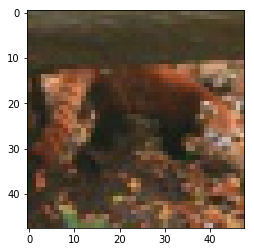

tensor([[[0.2899, 0.3372, 0.3760,  ..., 0.3083, 0.2583, 0.2275],
         [0.3130, 0.3643, 0.3957,  ..., 0.2712, 0.2602, 0.2392],
         [0.3537, 0.3721, 0.3902,  ..., 0.2701, 0.2536, 0.2592],
         ...,
         [0.2391, 0.2557, 0.2947,  ..., 0.4915, 0.4617, 0.3861],
         [0.2141, 0.2213, 0.2452,  ..., 0.4670, 0.4270, 0.3707],
         [0.1967, 0.2011, 0.2211,  ..., 0.4291, 0.3886, 0.3153]],

        [[0.2616, 0.3340, 0.3674,  ..., 0.3152, 0.2814, 0.2261],
         [0.3309, 0.3609, 0.3762,  ..., 0.2635, 0.2469, 0.2564],
         [0.3371, 0.3550, 0.3687,  ..., 0.2675, 0.2446, 0.2569],
         ...,
         [0.2137, 0.2291, 0.2729,  ..., 0.4297, 0.3825, 0.3264],
         [0.2125, 0.2118, 0.2163,  ..., 0.4095, 0.3738, 0.3208],
         [0.1664, 0.1953, 0.1938,  ..., 0.3804, 0.3360, 0.2932]],

        [[0.2342, 0.2940, 0.3377,  ..., 0.2776, 0.2234, 0.1877],
         [0.2766, 0.3019, 0.3241,  ..., 0.2183, 0.2014, 0.2216],
         [0.2926, 0.3114, 0.3046,  ..., 0.2243, 0.1984, 0.

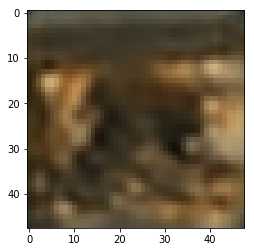


301it [00:50,  3.16it/s]
302it [00:50,  3.65it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



303it [00:50,  4.19it/s]
304it [00:50,  4.65it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



305it [00:50,  5.09it/s]
306it [00:51,  5.29it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



307it [00:51,  5.50it/s]
308it [00:51,  5.60it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



309it [00:51,  5.82it/s]
310it [00:51,  6.04it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



311it [00:51,  6.22it/s]
312it [00:51,  6.37it/s]
313it [00:52,  6.02it/s]
0it [00:00, ?it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([16, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
Epoch:  6 | train loss: 0.0063
decoded:  torch.Size([1, 3, 48, 48])
torch.Size([1, 3, 48, 48])
tensor([[[0.4392, 0.4392, 0.4392,  ..., 0.3882, 0.3843, 0.3804],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3608, 0.3569],
         [0.3882, 0.3882, 0.3882,  ..., 0.3255, 0.3176, 0.3176],
         ...,
         [0.2392, 0.2510, 0.2667,  ..., 0.7451, 0.6196, 0.5059],
         [0.2471, 0.2549, 0.2706,  ..., 0.8039, 0.6510, 0.4863],
         [0.2510, 0.2588, 0.2706,  ..., 0.8941, 0.8863, 0.7961]],

        [[0.3490, 0.3490, 0.3490,  ..., 0.2902, 0.2863, 0.2824],
         [0.3373, 0.3373, 0.3373,  ..., 0.2745, 0.2706, 0.2667],
         [0.3216, 0.3216, 0.3216,  ..., 0.2549, 0.2471, 0.2471],
         ...,
         [0.1647, 0.1765, 0.1922,  ..., 0.4784, 0.3529, 0.2392],
         [0.1725, 0.1804, 0.1961,  ..., 0.5412, 0.3765, 0.2118],
         [0.1765, 0.1843, 0.1961,  ..., 0.6314

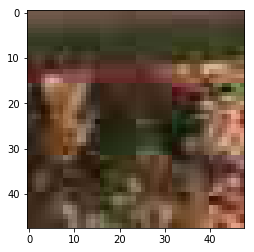

tensor([[[0.3569, 0.3804, 0.3765,  ..., 0.3333, 0.3255, 0.3216],
         [0.3098, 0.3333, 0.3451,  ..., 0.3490, 0.3333, 0.3137],
         [0.3725, 0.3686, 0.3647,  ..., 0.3294, 0.3294, 0.3176],
         ...,
         [0.2392, 0.2431, 0.2118,  ..., 0.6157, 0.4431, 0.3686],
         [0.2275, 0.2314, 0.2039,  ..., 0.7490, 0.6431, 0.6078],
         [0.2667, 0.2157, 0.2627,  ..., 0.8118, 0.7686, 0.6549]],

        [[0.3529, 0.3765, 0.3647,  ..., 0.3098, 0.3216, 0.3216],
         [0.2941, 0.3176, 0.3294,  ..., 0.3020, 0.2941, 0.2863],
         [0.3373, 0.3333, 0.3255,  ..., 0.2667, 0.2706, 0.2588],
         ...,
         [0.1961, 0.2196, 0.2039,  ..., 0.4196, 0.2471, 0.1843],
         [0.1725, 0.2039, 0.1922,  ..., 0.5490, 0.4627, 0.4353],
         [0.2157, 0.1686, 0.2235,  ..., 0.6196, 0.5882, 0.4706]],

        [[0.2824, 0.3059, 0.2980,  ..., 0.2157, 0.2118, 0.2118],
         [0.1961, 0.2196, 0.2314,  ..., 0.2078, 0.1961, 0.1843],
         [0.2235, 0.2196, 0.2196,  ..., 0.1765, 0.1804, 0.

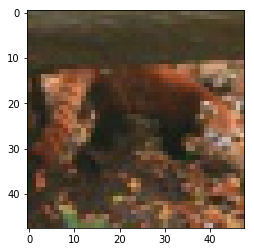

tensor([[[0.2989, 0.3501, 0.3917,  ..., 0.3191, 0.2662, 0.2338],
         [0.3225, 0.3733, 0.4053,  ..., 0.2780, 0.2655, 0.2454],
         [0.3593, 0.3748, 0.3928,  ..., 0.2724, 0.2547, 0.2627],
         ...,
         [0.2369, 0.2523, 0.2881,  ..., 0.4954, 0.4684, 0.3922],
         [0.2091, 0.2131, 0.2337,  ..., 0.4698, 0.4339, 0.3772],
         [0.1924, 0.1925, 0.2094,  ..., 0.4322, 0.3951, 0.3207]],

        [[0.2707, 0.3473, 0.3846,  ..., 0.3270, 0.2901, 0.2331],
         [0.3436, 0.3735, 0.3888,  ..., 0.2724, 0.2539, 0.2647],
         [0.3479, 0.3655, 0.3781,  ..., 0.2743, 0.2493, 0.2639],
         ...,
         [0.2134, 0.2283, 0.2702,  ..., 0.4402, 0.3944, 0.3373],
         [0.2100, 0.2079, 0.2087,  ..., 0.4194, 0.3857, 0.3302],
         [0.1632, 0.1903, 0.1861,  ..., 0.3911, 0.3482, 0.3024]],

        [[0.2417, 0.3044, 0.3486,  ..., 0.2831, 0.2275, 0.1918],
         [0.2864, 0.3119, 0.3326,  ..., 0.2216, 0.2047, 0.2277],
         [0.3017, 0.3197, 0.3116,  ..., 0.2251, 0.1997, 0.

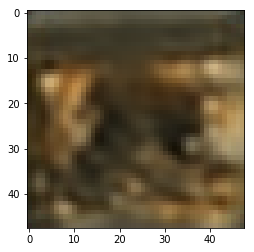


1it [00:00,  1.44it/s]
2it [00:00,  1.87it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



3it [00:01,  2.37it/s]
4it [00:01,  2.93it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



5it [00:01,  3.47it/s]
6it [00:01,  4.07it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



7it [00:01,  4.57it/s]
8it [00:01,  5.09it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



9it [00:01,  5.41it/s]
10it [00:02,  5.70it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



11it [00:02,  5.73it/s]
12it [00:02,  5.89it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



13it [00:02,  6.02it/s]
14it [00:02,  6.23it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



15it [00:02,  6.29it/s]
16it [00:03,  6.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



17it [00:03,  6.51it/s]
18it [00:03,  6.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



19it [00:03,  6.25it/s]
20it [00:03,  6.24it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



21it [00:03,  6.34it/s]
22it [00:03,  6.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



23it [00:04,  6.55it/s]
24it [00:04,  6.57it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



25it [00:04,  6.30it/s]
26it [00:04,  6.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



27it [00:04,  6.43it/s]
28it [00:04,  6.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



29it [00:05,  6.51it/s]
30it [00:05,  6.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



31it [00:05,  6.51it/s]
32it [00:05,  6.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



33it [00:05,  6.41it/s]
34it [00:05,  6.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



35it [00:05,  6.59it/s]
36it [00:06,  6.62it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



37it [00:06,  6.43it/s]
38it [00:06,  6.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



39it [00:06,  6.32it/s]
40it [00:06,  6.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



41it [00:06,  6.42it/s]
42it [00:07,  6.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



43it [00:07,  6.36it/s]
44it [00:07,  6.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



45it [00:07,  6.29it/s]
46it [00:07,  6.32it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



47it [00:07,  6.21it/s]
48it [00:08,  6.35it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



49it [00:08,  6.41it/s]
50it [00:08,  6.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



51it [00:08,  6.50it/s]
52it [00:08,  6.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



53it [00:08,  6.45it/s]
54it [00:08,  6.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



55it [00:09,  6.51it/s]
56it [00:09,  6.57it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



57it [00:09,  6.30it/s]
58it [00:09,  6.32it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



59it [00:09,  6.15it/s]
60it [00:09,  6.30it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



61it [00:10,  6.36it/s]
62it [00:10,  6.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



63it [00:10,  6.51it/s]
64it [00:10,  6.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



65it [00:10,  6.27it/s]
66it [00:10,  6.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



67it [00:10,  6.44it/s]
68it [00:11,  6.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



69it [00:11,  6.41it/s]
70it [00:11,  6.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



71it [00:11,  6.30it/s]
72it [00:11,  6.29it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



73it [00:11,  6.27it/s]
74it [00:12,  6.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



75it [00:12,  6.34it/s]
76it [00:12,  6.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



77it [00:12,  6.32it/s]
78it [00:12,  6.32it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



79it [00:12,  6.41it/s]
80it [00:13,  6.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



81it [00:13,  6.47it/s]
82it [00:13,  6.57it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



83it [00:13,  6.58it/s]
84it [00:13,  6.52it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



85it [00:13,  6.40it/s]
86it [00:13,  6.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



87it [00:14,  6.51it/s]
88it [00:14,  6.60it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



89it [00:14,  6.56it/s]
90it [00:14,  6.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



91it [00:14,  6.51it/s]
92it [00:14,  6.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



93it [00:15,  6.38it/s]
94it [00:15,  6.52it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



95it [00:15,  6.55it/s]
96it [00:15,  6.59it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



97it [00:15,  6.45it/s]
98it [00:15,  6.27it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



99it [00:15,  6.27it/s]
100it [00:16,  6.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
Epoch:  6 | train loss: 0.0060
decoded:  torch.Size([1, 3, 48, 48])
torch.Size([1, 3, 48, 48])
tensor([[[0.4392, 0.4392, 0.4392,  ..., 0.3882, 0.3843, 0.3804],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3608, 0.3569],
         [0.3882, 0.3882, 0.3882,  ..., 0.3255, 0.3176, 0.3176],
         ...,
         [0.2392, 0.2510, 0.2667,  ..., 0.7451, 0.6196, 0.5059],
         [0.2471, 0.2549, 0.2706,  ..., 0.8039, 0.6510, 0.4863],
         [0.2510, 0.2588, 0.2706,  ..., 0.8941, 0.8863, 0.7961]],

        [[0.3490, 0.3490, 0.3490,  ..., 0.2902, 0.2863, 0.2824],
         [0.3373, 0.3373, 0.3373,  ..., 0.2745, 0.2706, 0.2667],
         [0.3216, 0.3216, 0.3216,  ..., 0.2549, 0.2471, 0.2471],
         ...,
         [0.1647, 0.1765, 0.1922,  ..., 0.4784, 0.3529, 0.2392],
         [0.1725, 0.1804, 0.1961,  ..., 0.5412, 0.3765, 0.2118],
         [0.1765, 0.1843, 0.1961,  ..., 0.6314, 0.6118, 0.5216]],

        [[0.2941,

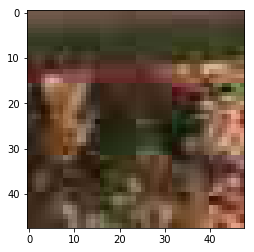

tensor([[[0.3569, 0.3804, 0.3765,  ..., 0.3333, 0.3255, 0.3216],
         [0.3098, 0.3333, 0.3451,  ..., 0.3490, 0.3333, 0.3137],
         [0.3725, 0.3686, 0.3647,  ..., 0.3294, 0.3294, 0.3176],
         ...,
         [0.2392, 0.2431, 0.2118,  ..., 0.6157, 0.4431, 0.3686],
         [0.2275, 0.2314, 0.2039,  ..., 0.7490, 0.6431, 0.6078],
         [0.2667, 0.2157, 0.2627,  ..., 0.8118, 0.7686, 0.6549]],

        [[0.3529, 0.3765, 0.3647,  ..., 0.3098, 0.3216, 0.3216],
         [0.2941, 0.3176, 0.3294,  ..., 0.3020, 0.2941, 0.2863],
         [0.3373, 0.3333, 0.3255,  ..., 0.2667, 0.2706, 0.2588],
         ...,
         [0.1961, 0.2196, 0.2039,  ..., 0.4196, 0.2471, 0.1843],
         [0.1725, 0.2039, 0.1922,  ..., 0.5490, 0.4627, 0.4353],
         [0.2157, 0.1686, 0.2235,  ..., 0.6196, 0.5882, 0.4706]],

        [[0.2824, 0.3059, 0.2980,  ..., 0.2157, 0.2118, 0.2118],
         [0.1961, 0.2196, 0.2314,  ..., 0.2078, 0.1961, 0.1843],
         [0.2235, 0.2196, 0.2196,  ..., 0.1765, 0.1804, 0.

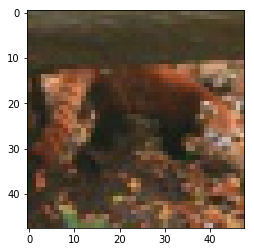

tensor([[[0.2839, 0.3316, 0.3671,  ..., 0.3062, 0.2533, 0.2238],
         [0.3025, 0.3505, 0.3770,  ..., 0.2656, 0.2512, 0.2335],
         [0.3407, 0.3540, 0.3684,  ..., 0.2601, 0.2387, 0.2477],
         ...,
         [0.2391, 0.2477, 0.2824,  ..., 0.4745, 0.4492, 0.3736],
         [0.2116, 0.2148, 0.2351,  ..., 0.4346, 0.4019, 0.3511],
         [0.1930, 0.1920, 0.2104,  ..., 0.3917, 0.3558, 0.2914]],

        [[0.2651, 0.3380, 0.3709,  ..., 0.3210, 0.2847, 0.2309],
         [0.3330, 0.3611, 0.3721,  ..., 0.2686, 0.2481, 0.2619],
         [0.3372, 0.3536, 0.3638,  ..., 0.2688, 0.2422, 0.2580],
         ...,
         [0.2125, 0.2220, 0.2595,  ..., 0.4179, 0.3750, 0.3206],
         [0.2105, 0.2057, 0.2063,  ..., 0.3834, 0.3538, 0.3065],
         [0.1627, 0.1902, 0.1871,  ..., 0.3500, 0.3108, 0.2773]],

        [[0.2301, 0.2866, 0.3235,  ..., 0.2665, 0.2174, 0.1889],
         [0.2730, 0.2949, 0.3081,  ..., 0.2092, 0.1964, 0.2255],
         [0.2862, 0.3014, 0.2865,  ..., 0.2122, 0.1918, 0.

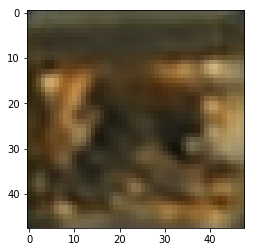


101it [00:16,  3.09it/s]
102it [00:16,  3.60it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



103it [00:17,  4.13it/s]
104it [00:17,  4.60it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



105it [00:17,  5.06it/s]
106it [00:17,  5.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



107it [00:17,  5.69it/s]
108it [00:17,  5.78it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



109it [00:18,  5.82it/s]
110it [00:18,  6.06it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



111it [00:18,  6.19it/s]
112it [00:18,  6.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



113it [00:18,  6.30it/s]
114it [00:18,  6.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



115it [00:19,  6.22it/s]
116it [00:19,  6.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



117it [00:19,  6.39it/s]
118it [00:19,  6.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



119it [00:19,  6.38it/s]
120it [00:19,  6.11it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



121it [00:19,  6.13it/s]
122it [00:20,  6.19it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



123it [00:20,  6.26it/s]
124it [00:20,  6.35it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



125it [00:20,  6.36it/s]
126it [00:20,  6.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



127it [00:20,  6.50it/s]
128it [00:21,  6.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



129it [00:21,  6.25it/s]
130it [00:21,  6.25it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



131it [00:21,  6.31it/s]
132it [00:21,  6.35it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



133it [00:21,  6.44it/s]
134it [00:22,  6.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



135it [00:22,  6.23it/s]
136it [00:22,  6.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



137it [00:22,  6.33it/s]
138it [00:22,  6.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



139it [00:22,  6.41it/s]
140it [00:22,  6.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



141it [00:23,  6.37it/s]
142it [00:23,  6.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



143it [00:23,  6.46it/s]
144it [00:23,  6.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



145it [00:23,  6.53it/s]
146it [00:23,  6.59it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



147it [00:24,  6.53it/s]
148it [00:24,  6.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



149it [00:24,  6.42it/s]
150it [00:24,  6.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



151it [00:24,  6.51it/s]
152it [00:24,  6.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



153it [00:24,  6.53it/s]
154it [00:25,  6.21it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



155it [00:25,  6.21it/s]
156it [00:25,  6.28it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



157it [00:25,  6.28it/s]
158it [00:25,  6.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



159it [00:25,  6.39it/s]
160it [00:26,  6.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



161it [00:26,  6.24it/s]
162it [00:26,  6.32it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



163it [00:26,  6.34it/s]
164it [00:26,  6.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



165it [00:26,  6.44it/s]
166it [00:27,  6.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



167it [00:27,  6.31it/s]
168it [00:27,  6.41it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



169it [00:27,  6.42it/s]
170it [00:27,  6.13it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



171it [00:27,  6.22it/s]
172it [00:27,  6.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



173it [00:28,  6.39it/s]
174it [00:28,  6.30it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



175it [00:28,  6.36it/s]
176it [00:28,  6.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



177it [00:28,  6.47it/s]
178it [00:28,  6.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



179it [00:29,  6.40it/s]
180it [00:29,  6.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



181it [00:29,  6.14it/s]
182it [00:29,  6.26it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



183it [00:29,  6.26it/s]
184it [00:29,  6.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



185it [00:30,  6.46it/s]
186it [00:30,  6.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



187it [00:30,  6.19it/s]
188it [00:30,  6.24it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



189it [00:30,  6.34it/s]
190it [00:30,  6.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



191it [00:30,  6.43it/s]
192it [00:31,  6.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



193it [00:31,  6.34it/s]
194it [00:31,  6.03it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



195it [00:31,  6.10it/s]
196it [00:31,  6.22it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



197it [00:31,  6.28it/s]
198it [00:32,  6.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



199it [00:32,  6.39it/s]
200it [00:32,  6.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
Epoch:  6 | train loss: 0.0065
decoded:  torch.Size([1, 3, 48, 48])
torch.Size([1, 3, 48, 48])
tensor([[[0.4392, 0.4392, 0.4392,  ..., 0.3882, 0.3843, 0.3804],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3608, 0.3569],
         [0.3882, 0.3882, 0.3882,  ..., 0.3255, 0.3176, 0.3176],
         ...,
         [0.2392, 0.2510, 0.2667,  ..., 0.7451, 0.6196, 0.5059],
         [0.2471, 0.2549, 0.2706,  ..., 0.8039, 0.6510, 0.4863],
         [0.2510, 0.2588, 0.2706,  ..., 0.8941, 0.8863, 0.7961]],

        [[0.3490, 0.3490, 0.3490,  ..., 0.2902, 0.2863, 0.2824],
         [0.3373, 0.3373, 0.3373,  ..., 0.2745, 0.2706, 0.2667],
         [0.3216, 0.3216, 0.3216,  ..., 0.2549, 0.2471, 0.2471],
         ...,
         [0.1647, 0.1765, 0.1922,  ..., 0.4784, 0.3529, 0.2392],
         [0.1725, 0.1804, 0.1961,  ..., 0.5412, 0.3765, 0.2118],
         [0.1765, 0.1843, 0.1961,  ..., 0.6314, 0.6118, 0.5216]],

        [[0.2941,

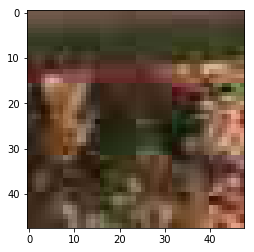

tensor([[[0.3569, 0.3804, 0.3765,  ..., 0.3333, 0.3255, 0.3216],
         [0.3098, 0.3333, 0.3451,  ..., 0.3490, 0.3333, 0.3137],
         [0.3725, 0.3686, 0.3647,  ..., 0.3294, 0.3294, 0.3176],
         ...,
         [0.2392, 0.2431, 0.2118,  ..., 0.6157, 0.4431, 0.3686],
         [0.2275, 0.2314, 0.2039,  ..., 0.7490, 0.6431, 0.6078],
         [0.2667, 0.2157, 0.2627,  ..., 0.8118, 0.7686, 0.6549]],

        [[0.3529, 0.3765, 0.3647,  ..., 0.3098, 0.3216, 0.3216],
         [0.2941, 0.3176, 0.3294,  ..., 0.3020, 0.2941, 0.2863],
         [0.3373, 0.3333, 0.3255,  ..., 0.2667, 0.2706, 0.2588],
         ...,
         [0.1961, 0.2196, 0.2039,  ..., 0.4196, 0.2471, 0.1843],
         [0.1725, 0.2039, 0.1922,  ..., 0.5490, 0.4627, 0.4353],
         [0.2157, 0.1686, 0.2235,  ..., 0.6196, 0.5882, 0.4706]],

        [[0.2824, 0.3059, 0.2980,  ..., 0.2157, 0.2118, 0.2118],
         [0.1961, 0.2196, 0.2314,  ..., 0.2078, 0.1961, 0.1843],
         [0.2235, 0.2196, 0.2196,  ..., 0.1765, 0.1804, 0.

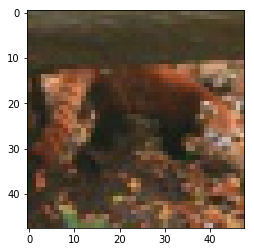

tensor([[[0.3022, 0.3529, 0.3910,  ..., 0.3278, 0.2721, 0.2422],
         [0.3191, 0.3665, 0.3935,  ..., 0.2914, 0.2749, 0.2588],
         [0.3576, 0.3672, 0.3801,  ..., 0.2901, 0.2651, 0.2747],
         ...,
         [0.2450, 0.2514, 0.2813,  ..., 0.4995, 0.4700, 0.3930],
         [0.2171, 0.2183, 0.2333,  ..., 0.4681, 0.4309, 0.3739],
         [0.2017, 0.1972, 0.2147,  ..., 0.4355, 0.3943, 0.3202]],

        [[0.2723, 0.3445, 0.3774,  ..., 0.3190, 0.2855, 0.2356],
         [0.3386, 0.3598, 0.3675,  ..., 0.2670, 0.2506, 0.2721],
         [0.3405, 0.3494, 0.3553,  ..., 0.2681, 0.2443, 0.2667],
         ...,
         [0.2080, 0.2118, 0.2418,  ..., 0.4228, 0.3827, 0.3266],
         [0.2090, 0.1987, 0.1877,  ..., 0.4019, 0.3728, 0.3164],
         [0.1626, 0.1878, 0.1790,  ..., 0.3817, 0.3397, 0.2944]],

        [[0.2363, 0.2914, 0.3293,  ..., 0.2694, 0.2195, 0.1943],
         [0.2800, 0.2963, 0.3102,  ..., 0.2130, 0.2001, 0.2353],
         [0.2941, 0.3032, 0.2873,  ..., 0.2166, 0.1953, 0.

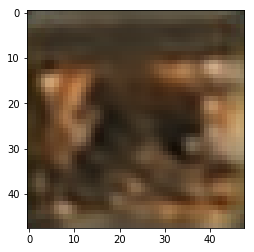


201it [00:33,  3.15it/s]
202it [00:33,  3.66it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



203it [00:33,  4.12it/s]
204it [00:33,  4.65it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



205it [00:33,  5.04it/s]
206it [00:33,  5.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



207it [00:34,  5.72it/s]
208it [00:34,  5.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



209it [00:34,  5.79it/s]
210it [00:34,  5.90it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



211it [00:34,  6.02it/s]
212it [00:34,  6.21it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



213it [00:35,  6.25it/s]
214it [00:35,  6.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



215it [00:35,  6.39it/s]
216it [00:35,  6.25it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



217it [00:35,  6.30it/s]
218it [00:35,  6.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



219it [00:35,  6.43it/s]
220it [00:36,  6.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



221it [00:36,  6.05it/s]
222it [00:36,  6.18it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



223it [00:36,  6.07it/s]
224it [00:36,  6.21it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



225it [00:36,  6.31it/s]
226it [00:37,  6.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



227it [00:37,  6.31it/s]
228it [00:37,  6.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



229it [00:37,  6.19it/s]
230it [00:37,  6.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



231it [00:37,  6.30it/s]
232it [00:38,  6.35it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



233it [00:38,  6.22it/s]
234it [00:38,  6.13it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



235it [00:38,  6.13it/s]
236it [00:38,  6.07it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



237it [00:38,  6.14it/s]
238it [00:39,  6.21it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



239it [00:39,  6.26it/s]
240it [00:39,  6.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



241it [00:39,  6.24it/s]
242it [00:39,  6.11it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



243it [00:39,  5.94it/s]
244it [00:40,  6.14it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



245it [00:40,  6.19it/s]
246it [00:40,  6.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



247it [00:40,  6.30it/s]
248it [00:40,  6.02it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



249it [00:40,  6.06it/s]
250it [00:40,  6.20it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



251it [00:41,  6.21it/s]
252it [00:41,  6.30it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



253it [00:41,  6.33it/s]
254it [00:41,  6.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



255it [00:41,  6.26it/s]
256it [00:41,  6.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



257it [00:42,  6.29it/s]
258it [00:42,  6.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



259it [00:42,  6.08it/s]
260it [00:42,  5.93it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



261it [00:42,  5.92it/s]
262it [00:42,  6.10it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



263it [00:43,  6.18it/s]
264it [00:43,  6.35it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



265it [00:43,  6.34it/s]
266it [00:43,  6.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



267it [00:43,  6.30it/s]
268it [00:43,  6.32it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



269it [00:44,  6.35it/s]
270it [00:44,  6.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



271it [00:44,  6.46it/s]
272it [00:44,  6.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



273it [00:44,  6.36it/s]
274it [00:44,  6.05it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



275it [00:44,  6.15it/s]
276it [00:45,  6.27it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



277it [00:45,  6.18it/s]
278it [00:45,  6.27it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



279it [00:45,  6.23it/s]
280it [00:45,  6.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



281it [00:45,  6.17it/s]
282it [00:46,  6.23it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



283it [00:46,  6.21it/s]
284it [00:46,  6.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



285it [00:46,  6.18it/s]
286it [00:46,  6.08it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



287it [00:46,  6.04it/s]
288it [00:47,  6.08it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



289it [00:47,  6.11it/s]
290it [00:47,  6.22it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



291it [00:47,  6.27it/s]
292it [00:47,  6.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



293it [00:47,  6.35it/s]
294it [00:48,  6.37it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



295it [00:48,  6.33it/s]
296it [00:48,  6.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



297it [00:48,  6.41it/s]
298it [00:48,  6.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



299it [00:48,  6.13it/s]
300it [00:49,  5.77it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
Epoch:  6 | train loss: 0.0054
decoded:  torch.Size([1, 3, 48, 48])
torch.Size([1, 3, 48, 48])
tensor([[[0.4392, 0.4392, 0.4392,  ..., 0.3882, 0.3843, 0.3804],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3608, 0.3569],
         [0.3882, 0.3882, 0.3882,  ..., 0.3255, 0.3176, 0.3176],
         ...,
         [0.2392, 0.2510, 0.2667,  ..., 0.7451, 0.6196, 0.5059],
         [0.2471, 0.2549, 0.2706,  ..., 0.8039, 0.6510, 0.4863],
         [0.2510, 0.2588, 0.2706,  ..., 0.8941, 0.8863, 0.7961]],

        [[0.3490, 0.3490, 0.3490,  ..., 0.2902, 0.2863, 0.2824],
         [0.3373, 0.3373, 0.3373,  ..., 0.2745, 0.2706, 0.2667],
         [0.3216, 0.3216, 0.3216,  ..., 0.2549, 0.2471, 0.2471],
         ...,
         [0.1647, 0.1765, 0.1922,  ..., 0.4784, 0.3529, 0.2392],
         [0.1725, 0.1804, 0.1961,  ..., 0.5412, 0.3765, 0.2118],
         [0.1765, 0.1843, 0.1961,  ..., 0.6314, 0.6118, 0.5216]],

        [[0.2941,

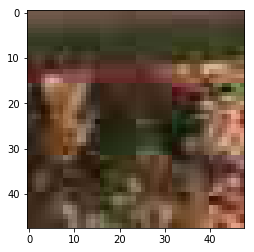

tensor([[[0.3569, 0.3804, 0.3765,  ..., 0.3333, 0.3255, 0.3216],
         [0.3098, 0.3333, 0.3451,  ..., 0.3490, 0.3333, 0.3137],
         [0.3725, 0.3686, 0.3647,  ..., 0.3294, 0.3294, 0.3176],
         ...,
         [0.2392, 0.2431, 0.2118,  ..., 0.6157, 0.4431, 0.3686],
         [0.2275, 0.2314, 0.2039,  ..., 0.7490, 0.6431, 0.6078],
         [0.2667, 0.2157, 0.2627,  ..., 0.8118, 0.7686, 0.6549]],

        [[0.3529, 0.3765, 0.3647,  ..., 0.3098, 0.3216, 0.3216],
         [0.2941, 0.3176, 0.3294,  ..., 0.3020, 0.2941, 0.2863],
         [0.3373, 0.3333, 0.3255,  ..., 0.2667, 0.2706, 0.2588],
         ...,
         [0.1961, 0.2196, 0.2039,  ..., 0.4196, 0.2471, 0.1843],
         [0.1725, 0.2039, 0.1922,  ..., 0.5490, 0.4627, 0.4353],
         [0.2157, 0.1686, 0.2235,  ..., 0.6196, 0.5882, 0.4706]],

        [[0.2824, 0.3059, 0.2980,  ..., 0.2157, 0.2118, 0.2118],
         [0.1961, 0.2196, 0.2314,  ..., 0.2078, 0.1961, 0.1843],
         [0.2235, 0.2196, 0.2196,  ..., 0.1765, 0.1804, 0.

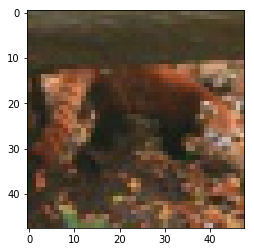

tensor([[[0.3020, 0.3514, 0.3855,  ..., 0.3280, 0.2707, 0.2408],
         [0.3155, 0.3626, 0.3849,  ..., 0.2875, 0.2702, 0.2571],
         [0.3514, 0.3596, 0.3667,  ..., 0.2804, 0.2572, 0.2706],
         ...,
         [0.2368, 0.2399, 0.2678,  ..., 0.5030, 0.4732, 0.3912],
         [0.2119, 0.2125, 0.2267,  ..., 0.4607, 0.4278, 0.3669],
         [0.2005, 0.1944, 0.2098,  ..., 0.4280, 0.3888, 0.3117]],

        [[0.2742, 0.3422, 0.3711,  ..., 0.3160, 0.2817, 0.2333],
         [0.3389, 0.3573, 0.3586,  ..., 0.2617, 0.2458, 0.2718],
         [0.3396, 0.3485, 0.3487,  ..., 0.2615, 0.2383, 0.2645],
         ...,
         [0.2068, 0.2080, 0.2354,  ..., 0.4270, 0.3841, 0.3236],
         [0.2110, 0.1999, 0.1867,  ..., 0.3967, 0.3679, 0.3090],
         [0.1660, 0.1900, 0.1790,  ..., 0.3733, 0.3335, 0.2867]],

        [[0.2403, 0.2929, 0.3281,  ..., 0.2664, 0.2187, 0.1933],
         [0.2861, 0.3011, 0.3099,  ..., 0.2040, 0.1945, 0.2325],
         [0.2993, 0.3069, 0.2837,  ..., 0.2056, 0.1903, 0.

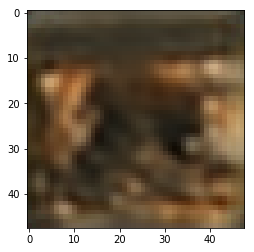


301it [00:49,  3.05it/s]
302it [00:49,  3.59it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



303it [00:50,  4.09it/s]
304it [00:50,  4.60it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



305it [00:50,  5.02it/s]
306it [00:50,  5.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



307it [00:50,  5.56it/s]
308it [00:50,  5.78it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



309it [00:50,  5.92it/s]
310it [00:51,  6.09it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



311it [00:51,  6.21it/s]
312it [00:51,  6.27it/s]
313it [00:51,  6.08it/s]
0it [00:00, ?it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([16, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
Epoch:  7 | train loss: 0.0065
decoded:  torch.Size([1, 3, 48, 48])
torch.Size([1, 3, 48, 48])
tensor([[[0.4392, 0.4392, 0.4392,  ..., 0.3882, 0.3843, 0.3804],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3608, 0.3569],
         [0.3882, 0.3882, 0.3882,  ..., 0.3255, 0.3176, 0.3176],
         ...,
         [0.2392, 0.2510, 0.2667,  ..., 0.7451, 0.6196, 0.5059],
         [0.2471, 0.2549, 0.2706,  ..., 0.8039, 0.6510, 0.4863],
         [0.2510, 0.2588, 0.2706,  ..., 0.8941, 0.8863, 0.7961]],

        [[0.3490, 0.3490, 0.3490,  ..., 0.2902, 0.2863, 0.2824],
         [0.3373, 0.3373, 0.3373,  ..., 0.2745, 0.2706, 0.2667],
         [0.3216, 0.3216, 0.3216,  ..., 0.2549, 0.2471, 0.2471],
         ...,
         [0.1647, 0.1765, 0.1922,  ..., 0.4784, 0.3529, 0.2392],
         [0.1725, 0.1804, 0.1961,  ..., 0.5412, 0.3765, 0.2118],
         [0.1765, 0.1843, 0.1961,  ..., 0.6314

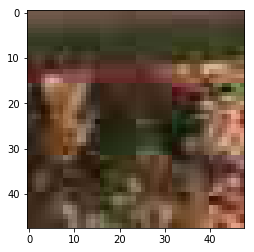

tensor([[[0.3569, 0.3804, 0.3765,  ..., 0.3333, 0.3255, 0.3216],
         [0.3098, 0.3333, 0.3451,  ..., 0.3490, 0.3333, 0.3137],
         [0.3725, 0.3686, 0.3647,  ..., 0.3294, 0.3294, 0.3176],
         ...,
         [0.2392, 0.2431, 0.2118,  ..., 0.6157, 0.4431, 0.3686],
         [0.2275, 0.2314, 0.2039,  ..., 0.7490, 0.6431, 0.6078],
         [0.2667, 0.2157, 0.2627,  ..., 0.8118, 0.7686, 0.6549]],

        [[0.3529, 0.3765, 0.3647,  ..., 0.3098, 0.3216, 0.3216],
         [0.2941, 0.3176, 0.3294,  ..., 0.3020, 0.2941, 0.2863],
         [0.3373, 0.3333, 0.3255,  ..., 0.2667, 0.2706, 0.2588],
         ...,
         [0.1961, 0.2196, 0.2039,  ..., 0.4196, 0.2471, 0.1843],
         [0.1725, 0.2039, 0.1922,  ..., 0.5490, 0.4627, 0.4353],
         [0.2157, 0.1686, 0.2235,  ..., 0.6196, 0.5882, 0.4706]],

        [[0.2824, 0.3059, 0.2980,  ..., 0.2157, 0.2118, 0.2118],
         [0.1961, 0.2196, 0.2314,  ..., 0.2078, 0.1961, 0.1843],
         [0.2235, 0.2196, 0.2196,  ..., 0.1765, 0.1804, 0.

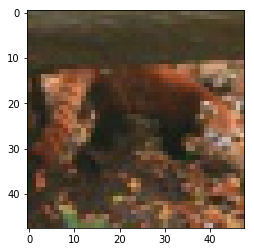

tensor([[[0.3027, 0.3539, 0.3906,  ..., 0.3265, 0.2672, 0.2370],
         [0.3152, 0.3634, 0.3875,  ..., 0.2848, 0.2640, 0.2502],
         [0.3538, 0.3642, 0.3738,  ..., 0.2819, 0.2522, 0.2632],
         ...,
         [0.2431, 0.2481, 0.2776,  ..., 0.5099, 0.4736, 0.3903],
         [0.2190, 0.2220, 0.2386,  ..., 0.4702, 0.4331, 0.3705],
         [0.2073, 0.2034, 0.2218,  ..., 0.4390, 0.3976, 0.3180]],

        [[0.2833, 0.3584, 0.3939,  ..., 0.3331, 0.2928, 0.2410],
         [0.3493, 0.3745, 0.3821,  ..., 0.2789, 0.2558, 0.2778],
         [0.3523, 0.3683, 0.3751,  ..., 0.2818, 0.2494, 0.2710],
         ...,
         [0.2212, 0.2259, 0.2597,  ..., 0.4535, 0.4023, 0.3373],
         [0.2256, 0.2179, 0.2101,  ..., 0.4225, 0.3884, 0.3250],
         [0.1783, 0.2062, 0.1996,  ..., 0.3961, 0.3527, 0.3016]],

        [[0.2427, 0.3001, 0.3399,  ..., 0.2717, 0.2191, 0.1916],
         [0.2872, 0.3061, 0.3186,  ..., 0.2077, 0.1920, 0.2280],
         [0.3011, 0.3135, 0.2945,  ..., 0.2089, 0.1864, 0.

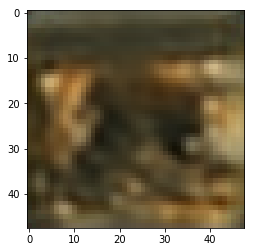


1it [00:00,  1.47it/s]
2it [00:00,  1.90it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



3it [00:01,  2.39it/s]
4it [00:01,  2.85it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



5it [00:01,  3.44it/s]
6it [00:01,  3.96it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



7it [00:01,  4.49it/s]
8it [00:01,  4.99it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



9it [00:01,  5.33it/s]
10it [00:02,  5.65it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



11it [00:02,  5.83it/s]
12it [00:02,  6.05it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



13it [00:02,  6.07it/s]
14it [00:02,  6.02it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



15it [00:02,  5.81it/s]
16it [00:03,  6.00it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



17it [00:03,  6.13it/s]
18it [00:03,  6.35it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



19it [00:03,  6.25it/s]
20it [00:03,  6.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



21it [00:03,  6.35it/s]
22it [00:04,  6.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



23it [00:04,  6.51it/s]
24it [00:04,  6.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



25it [00:04,  6.61it/s]
26it [00:04,  6.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



27it [00:04,  6.49it/s]
28it [00:04,  6.52it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



29it [00:05,  6.42it/s]
30it [00:05,  6.40it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



31it [00:05,  6.43it/s]
32it [00:05,  6.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



33it [00:05,  6.03it/s]
34it [00:05,  6.12it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



35it [00:06,  6.22it/s]
36it [00:06,  6.32it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



37it [00:06,  6.42it/s]
38it [00:06,  6.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



39it [00:06,  6.38it/s]
40it [00:06,  6.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



41it [00:07,  6.45it/s]
42it [00:07,  6.55it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



43it [00:07,  6.36it/s]
44it [00:07,  6.27it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



45it [00:07,  6.25it/s]
46it [00:07,  6.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



47it [00:07,  6.41it/s]
48it [00:08,  6.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



49it [00:08,  6.36it/s]
50it [00:08,  6.52it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



51it [00:08,  6.52it/s]
52it [00:08,  6.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



53it [00:08,  6.44it/s]
54it [00:09,  6.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



55it [00:09,  6.53it/s]
56it [00:09,  6.32it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



57it [00:09,  6.35it/s]
58it [00:09,  6.45it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



59it [00:09,  6.17it/s]
60it [00:09,  6.32it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



61it [00:10,  6.26it/s]
62it [00:10,  6.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



63it [00:10,  6.44it/s]
64it [00:10,  6.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



65it [00:10,  6.50it/s]
66it [00:10,  6.18it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



67it [00:11,  6.23it/s]
68it [00:11,  6.29it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



69it [00:11,  6.39it/s]
70it [00:11,  6.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



71it [00:11,  6.47it/s]
72it [00:11,  6.50it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



73it [00:12,  6.18it/s]
74it [00:12,  6.28it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



75it [00:12,  6.41it/s]
76it [00:12,  6.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



77it [00:12,  6.52it/s]
78it [00:12,  6.48it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



79it [00:12,  6.27it/s]
80it [00:13,  6.30it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



81it [00:13,  6.39it/s]
82it [00:13,  6.47it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



83it [00:13,  6.30it/s]
84it [00:13,  6.33it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



85it [00:13,  6.27it/s]
86it [00:14,  6.23it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



87it [00:14,  6.34it/s]
88it [00:14,  6.49it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



89it [00:14,  6.40it/s]
90it [00:14,  6.27it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



91it [00:14,  6.34it/s]
92it [00:15,  6.24it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



93it [00:15,  6.17it/s]
94it [00:15,  6.10it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



95it [00:15,  6.20it/s]
96it [00:15,  6.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



97it [00:15,  6.46it/s]
98it [00:15,  6.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



99it [00:16,  6.16it/s]
100it [00:16,  6.23it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
Epoch:  7 | train loss: 0.0043
decoded:  torch.Size([1, 3, 48, 48])
torch.Size([1, 3, 48, 48])
tensor([[[0.4392, 0.4392, 0.4392,  ..., 0.3882, 0.3843, 0.3804],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3608, 0.3569],
         [0.3882, 0.3882, 0.3882,  ..., 0.3255, 0.3176, 0.3176],
         ...,
         [0.2392, 0.2510, 0.2667,  ..., 0.7451, 0.6196, 0.5059],
         [0.2471, 0.2549, 0.2706,  ..., 0.8039, 0.6510, 0.4863],
         [0.2510, 0.2588, 0.2706,  ..., 0.8941, 0.8863, 0.7961]],

        [[0.3490, 0.3490, 0.3490,  ..., 0.2902, 0.2863, 0.2824],
         [0.3373, 0.3373, 0.3373,  ..., 0.2745, 0.2706, 0.2667],
         [0.3216, 0.3216, 0.3216,  ..., 0.2549, 0.2471, 0.2471],
         ...,
         [0.1647, 0.1765, 0.1922,  ..., 0.4784, 0.3529, 0.2392],
         [0.1725, 0.1804, 0.1961,  ..., 0.5412, 0.3765, 0.2118],
         [0.1765, 0.1843, 0.1961,  ..., 0.6314, 0.6118, 0.5216]],

        [[0.2941,

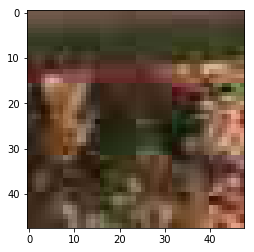

tensor([[[0.3569, 0.3804, 0.3765,  ..., 0.3333, 0.3255, 0.3216],
         [0.3098, 0.3333, 0.3451,  ..., 0.3490, 0.3333, 0.3137],
         [0.3725, 0.3686, 0.3647,  ..., 0.3294, 0.3294, 0.3176],
         ...,
         [0.2392, 0.2431, 0.2118,  ..., 0.6157, 0.4431, 0.3686],
         [0.2275, 0.2314, 0.2039,  ..., 0.7490, 0.6431, 0.6078],
         [0.2667, 0.2157, 0.2627,  ..., 0.8118, 0.7686, 0.6549]],

        [[0.3529, 0.3765, 0.3647,  ..., 0.3098, 0.3216, 0.3216],
         [0.2941, 0.3176, 0.3294,  ..., 0.3020, 0.2941, 0.2863],
         [0.3373, 0.3333, 0.3255,  ..., 0.2667, 0.2706, 0.2588],
         ...,
         [0.1961, 0.2196, 0.2039,  ..., 0.4196, 0.2471, 0.1843],
         [0.1725, 0.2039, 0.1922,  ..., 0.5490, 0.4627, 0.4353],
         [0.2157, 0.1686, 0.2235,  ..., 0.6196, 0.5882, 0.4706]],

        [[0.2824, 0.3059, 0.2980,  ..., 0.2157, 0.2118, 0.2118],
         [0.1961, 0.2196, 0.2314,  ..., 0.2078, 0.1961, 0.1843],
         [0.2235, 0.2196, 0.2196,  ..., 0.1765, 0.1804, 0.

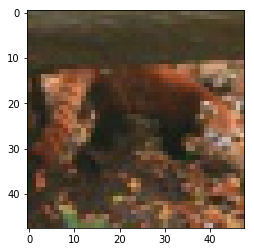

tensor([[[0.2942, 0.3396, 0.3768,  ..., 0.3127, 0.2635, 0.2342],
         [0.3130, 0.3568, 0.3770,  ..., 0.2669, 0.2595, 0.2452],
         [0.3477, 0.3519, 0.3556,  ..., 0.2628, 0.2557, 0.2636],
         ...,
         [0.2355, 0.2439, 0.2750,  ..., 0.4726, 0.4481, 0.3771],
         [0.2130, 0.2190, 0.2361,  ..., 0.4370, 0.4004, 0.3519],
         [0.2065, 0.2059, 0.2215,  ..., 0.4085, 0.3640, 0.3004]],

        [[0.2806, 0.3453, 0.3773,  ..., 0.3131, 0.2814, 0.2375],
         [0.3411, 0.3606, 0.3641,  ..., 0.2493, 0.2446, 0.2659],
         [0.3432, 0.3521, 0.3511,  ..., 0.2485, 0.2453, 0.2642],
         ...,
         [0.2142, 0.2173, 0.2454,  ..., 0.4084, 0.3719, 0.3203],
         [0.2201, 0.2107, 0.2001,  ..., 0.3840, 0.3542, 0.3075],
         [0.1803, 0.2029, 0.1938,  ..., 0.3596, 0.3163, 0.2828]],

        [[0.2473, 0.2989, 0.3397,  ..., 0.2589, 0.2130, 0.1890],
         [0.2903, 0.3079, 0.3246,  ..., 0.1958, 0.1930, 0.2234],
         [0.3019, 0.3141, 0.2985,  ..., 0.2039, 0.2007, 0.

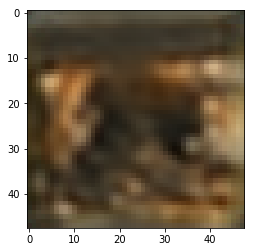


101it [00:16,  3.11it/s]
102it [00:17,  3.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



103it [00:17,  4.10it/s]
104it [00:17,  4.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



105it [00:17,  4.92it/s]
106it [00:17,  5.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



107it [00:17,  5.60it/s]
108it [00:18,  5.74it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



109it [00:18,  5.96it/s]
110it [00:18,  6.04it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



111it [00:18,  6.06it/s]
112it [00:18,  6.24it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



113it [00:18,  6.22it/s]
114it [00:19,  6.31it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



115it [00:19,  6.03it/s]
116it [00:19,  6.17it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



117it [00:19,  5.73it/s]
118it [00:19,  5.90it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



119it [00:19,  5.49it/s]
120it [00:20,  5.73it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



121it [00:20,  5.85it/s]
122it [00:20,  5.58it/s]

decoded:  torch.Size([32, 3, 48, 48])



123it [00:20,  5.72it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



124it [00:20,  5.51it/s]
125it [00:21,  5.20it/s]

decoded:  torch.Size([32, 3, 48, 48])



126it [00:21,  5.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



127it [00:21,  5.25it/s]
128it [00:21,  5.57it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



129it [00:21,  5.70it/s]
130it [00:21,  5.44it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



131it [00:22,  5.65it/s]
132it [00:22,  4.95it/s]

decoded:  torch.Size([32, 3, 48, 48])



133it [00:22,  4.99it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



134it [00:22,  5.25it/s]
135it [00:22,  5.16it/s]

decoded:  torch.Size([32, 3, 48, 48])



136it [00:23,  5.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



137it [00:23,  5.55it/s]
138it [00:23,  5.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



139it [00:23,  5.68it/s]
140it [00:23,  5.47it/s]

decoded:  torch.Size([32, 3, 48, 48])



141it [00:24,  5.63it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



142it [00:24,  5.48it/s]
143it [00:24,  5.60it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



144it [00:24,  5.37it/s]
145it [00:24,  5.61it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



146it [00:24,  5.59it/s]
147it [00:25,  5.73it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



148it [00:25,  5.64it/s]
149it [00:25,  5.68it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



150it [00:25,  5.35it/s]
151it [00:25,  5.28it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



152it [00:26,  5.40it/s]
153it [00:26,  5.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



154it [00:26,  5.57it/s]
155it [00:26,  5.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



156it [00:26,  5.25it/s]
157it [00:26,  5.53it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



158it [00:27,  5.57it/s]
159it [00:27,  5.36it/s]

decoded:  torch.Size([32, 3, 48, 48])



160it [00:27,  5.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



161it [00:27,  5.54it/s]
162it [00:27,  5.42it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



163it [00:28,  5.57it/s]
164it [00:28,  5.70it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



165it [00:28,  5.40it/s]
166it [00:28,  5.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



167it [00:28,  5.21it/s]
168it [00:28,  5.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



169it [00:29,  5.26it/s]
170it [00:29,  5.35it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



171it [00:29,  5.40it/s]
172it [00:29,  5.30it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



173it [00:29,  5.41it/s]
174it [00:30,  5.27it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



175it [00:30,  5.43it/s]
176it [00:30,  5.39it/s]

decoded:  torch.Size([32, 3, 48, 48])



177it [00:30,  5.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



178it [00:30,  5.26it/s]
179it [00:31,  5.38it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



180it [00:31,  5.18it/s]
181it [00:31,  5.39it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



182it [00:31,  5.34it/s]
183it [00:31,  5.32it/s]

decoded:  torch.Size([32, 3, 48, 48])



184it [00:31,  5.29it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



185it [00:32,  5.13it/s]
186it [00:32,  5.00it/s]

decoded:  torch.Size([32, 3, 48, 48])



187it [00:32,  5.00it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



188it [00:32,  5.16it/s]
189it [00:32,  5.09it/s]

decoded:  torch.Size([32, 3, 48, 48])



190it [00:33,  5.01it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



191it [00:33,  5.22it/s]
192it [00:33,  5.34it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



193it [00:33,  5.13it/s]
194it [00:33,  5.12it/s]

decoded:  torch.Size([32, 3, 48, 48])



195it [00:34,  5.26it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



196it [00:34,  5.44it/s]
197it [00:34,  5.21it/s]

decoded:  torch.Size([32, 3, 48, 48])



198it [00:34,  5.07it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



199it [00:34,  5.27it/s]
200it [00:35,  5.36it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
Epoch:  7 | train loss: 0.0049
decoded:  torch.Size([1, 3, 48, 48])
torch.Size([1, 3, 48, 48])
tensor([[[0.4392, 0.4392, 0.4392,  ..., 0.3882, 0.3843, 0.3804],
         [0.4235, 0.4235, 0.4235,  ..., 0.3647, 0.3608, 0.3569],
         [0.3882, 0.3882, 0.3882,  ..., 0.3255, 0.3176, 0.3176],
         ...,
         [0.2392, 0.2510, 0.2667,  ..., 0.7451, 0.6196, 0.5059],
         [0.2471, 0.2549, 0.2706,  ..., 0.8039, 0.6510, 0.4863],
         [0.2510, 0.2588, 0.2706,  ..., 0.8941, 0.8863, 0.7961]],

        [[0.3490, 0.3490, 0.3490,  ..., 0.2902, 0.2863, 0.2824],
         [0.3373, 0.3373, 0.3373,  ..., 0.2745, 0.2706, 0.2667],
         [0.3216, 0.3216, 0.3216,  ..., 0.2549, 0.2471, 0.2471],
         ...,
         [0.1647, 0.1765, 0.1922,  ..., 0.4784, 0.3529, 0.2392],
         [0.1725, 0.1804, 0.1961,  ..., 0.5412, 0.3765, 0.2118],
         [0.1765, 0.1843, 0.1961,  ..., 0.6314, 0.6118, 0.5216]],

        [[0.2941,

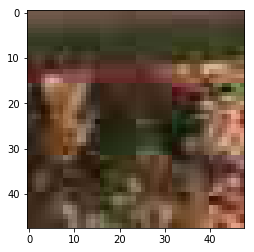

tensor([[[0.3569, 0.3804, 0.3765,  ..., 0.3333, 0.3255, 0.3216],
         [0.3098, 0.3333, 0.3451,  ..., 0.3490, 0.3333, 0.3137],
         [0.3725, 0.3686, 0.3647,  ..., 0.3294, 0.3294, 0.3176],
         ...,
         [0.2392, 0.2431, 0.2118,  ..., 0.6157, 0.4431, 0.3686],
         [0.2275, 0.2314, 0.2039,  ..., 0.7490, 0.6431, 0.6078],
         [0.2667, 0.2157, 0.2627,  ..., 0.8118, 0.7686, 0.6549]],

        [[0.3529, 0.3765, 0.3647,  ..., 0.3098, 0.3216, 0.3216],
         [0.2941, 0.3176, 0.3294,  ..., 0.3020, 0.2941, 0.2863],
         [0.3373, 0.3333, 0.3255,  ..., 0.2667, 0.2706, 0.2588],
         ...,
         [0.1961, 0.2196, 0.2039,  ..., 0.4196, 0.2471, 0.1843],
         [0.1725, 0.2039, 0.1922,  ..., 0.5490, 0.4627, 0.4353],
         [0.2157, 0.1686, 0.2235,  ..., 0.6196, 0.5882, 0.4706]],

        [[0.2824, 0.3059, 0.2980,  ..., 0.2157, 0.2118, 0.2118],
         [0.1961, 0.2196, 0.2314,  ..., 0.2078, 0.1961, 0.1843],
         [0.2235, 0.2196, 0.2196,  ..., 0.1765, 0.1804, 0.

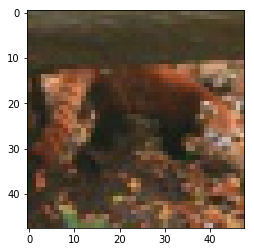

tensor([[[0.3069, 0.3470, 0.3812,  ..., 0.3285, 0.2751, 0.2525],
         [0.3159, 0.3580, 0.3774,  ..., 0.2700, 0.2599, 0.2494],
         [0.3512, 0.3549, 0.3572,  ..., 0.2559, 0.2415, 0.2514],
         ...,
         [0.2340, 0.2382, 0.2647,  ..., 0.4852, 0.4516, 0.3818],
         [0.2099, 0.2135, 0.2285,  ..., 0.4560, 0.4119, 0.3625],
         [0.2066, 0.2009, 0.2177,  ..., 0.4283, 0.3793, 0.3136]],

        [[0.2845, 0.3454, 0.3740,  ..., 0.3229, 0.2840, 0.2408],
         [0.3410, 0.3574, 0.3581,  ..., 0.2433, 0.2301, 0.2577],
         [0.3421, 0.3506, 0.3497,  ..., 0.2334, 0.2192, 0.2437],
         ...,
         [0.2065, 0.2052, 0.2267,  ..., 0.4047, 0.3621, 0.3086],
         [0.2138, 0.2018, 0.1860,  ..., 0.3905, 0.3598, 0.3063],
         [0.1748, 0.1964, 0.1855,  ..., 0.3720, 0.3276, 0.2875]],

        [[0.2471, 0.2924, 0.3298,  ..., 0.2665, 0.2159, 0.1958],
         [0.2891, 0.3011, 0.3137,  ..., 0.1917, 0.1736, 0.2151],
         [0.3010, 0.3095, 0.2865,  ..., 0.1911, 0.1744, 0.

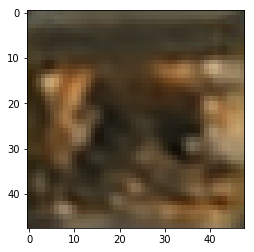


201it [00:35,  2.76it/s]
202it [00:36,  3.18it/s]

decoded:  torch.Size([32, 3, 48, 48])



203it [00:36,  3.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



204it [00:36,  4.01it/s]
205it [00:36,  4.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



206it [00:36,  4.53it/s]
207it [00:36,  4.83it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



208it [00:37,  5.03it/s]
209it [00:37,  5.26it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



210it [00:37,  5.34it/s]
211it [00:37,  5.43it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



212it [00:37,  5.45it/s]
213it [00:38,  5.54it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



214it [00:38,  5.53it/s]
215it [00:38,  5.58it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



216it [00:38,  5.55it/s]
217it [00:38,  5.60it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



218it [00:38,  5.58it/s]
219it [00:39,  5.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



220it [00:39,  5.62it/s]
221it [00:39,  5.74it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



222it [00:39,  5.72it/s]
223it [00:39,  5.71it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



224it [00:39,  5.63it/s]
225it [00:40,  5.65it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



226it [00:40,  5.59it/s]
227it [00:40,  5.62it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



228it [00:40,  5.55it/s]
229it [00:40,  5.51it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



230it [00:41,  5.51it/s]
231it [00:41,  5.67it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



232it [00:41,  5.64it/s]
233it [00:41,  5.62it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



234it [00:41,  5.68it/s]
235it [00:41,  5.57it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



236it [00:42,  5.64it/s]
237it [00:42,  5.67it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



238it [00:42,  5.66it/s]
239it [00:42,  5.66it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



240it [00:42,  5.45it/s]
241it [00:43,  5.46it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



242it [00:43,  5.49it/s]
243it [00:43,  5.65it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



244it [00:43,  5.70it/s]
245it [00:43,  5.73it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



246it [00:43,  5.77it/s]
247it [00:44,  5.70it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



248it [00:44,  5.58it/s]
249it [00:44,  5.71it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



250it [00:44,  5.66it/s]
251it [00:44,  5.70it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



252it [00:44,  5.49it/s]
253it [00:45,  5.59it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



254it [00:45,  5.58it/s]
255it [00:45,  5.66it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



256it [00:45,  5.62it/s]
257it [00:45,  5.65it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



258it [00:46,  5.40it/s]
259it [00:46,  5.57it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



260it [00:46,  5.56it/s]
261it [00:46,  5.71it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



262it [00:46,  5.65it/s]
263it [00:46,  5.80it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



264it [00:47,  5.65it/s]
265it [00:47,  5.76it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



266it [00:47,  5.74it/s]
267it [00:47,  5.79it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



268it [00:47,  5.71it/s]
269it [00:47,  5.56it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



270it [00:48,  5.57it/s]
271it [00:48,  5.67it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



272it [00:48,  5.73it/s]
273it [00:48,  5.73it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



274it [00:48,  5.59it/s]
275it [00:49,  5.74it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



276it [00:49,  5.60it/s]
277it [00:49,  5.70it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



278it [00:49,  5.69it/s]
279it [00:49,  5.76it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



280it [00:49,  5.71it/s]
281it [00:50,  5.66it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



282it [00:50,  5.57it/s]
283it [00:50,  5.69it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



284it [00:50,  5.65it/s]
285it [00:50,  5.73it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



286it [00:50,  5.68it/s]
287it [00:51,  5.57it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



288it [00:51,  5.68it/s]
289it [00:51,  5.73it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



290it [00:51,  5.88it/s]
291it [00:51,  5.84it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



292it [00:51,  5.84it/s]
293it [00:52,  5.72it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



294it [00:52,  5.85it/s]
295it [00:52,  5.90it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



296it [00:52,  5.92it/s]
297it [00:52,  5.90it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])



298it [00:53,  5.96it/s]
299it [00:53,  5.83it/s]

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])


KeyboardInterrupt: ignored

In [24]:
in_data, original_data = train_dataset.get_train_data(n_plots)
autoencoder = ConvAutoencoder(4)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr)
loss_func = loss = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[9,12,13], gamma=0.1)

for epoch in range(epochs):
    autoencoder.train()
    for step, (x, y) in tqdm.tqdm(enumerate(train_loader)):

        encoded, decoded = autoencoder(x) 
        loss = loss_func(decoded, y)
        optimizer.zero_grad()   # clear gradients for this training step
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients

        if step % 100 == 0:# and epoch in [0, 5, epochs - 1]:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.item())
            _, decoded_data = autoencoder(original_data)
            print(in_data.shape)
            show_img(in_data.squeeze(0))
            show_img(original_data.squeeze(0))
            show_img(decoded_data.data.squeeze(0))
          
    scheduler.step()

decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([32, 3, 48, 48])
decoded:  torch.Size([16, 3, 48, 48])
tensor([[[0.1843, 0.2588, 0.2510,  ..., 0.2431, 0.2392, 0.2392],
         [0.1255, 0.2000, 0.2196,  ..., 0.2471, 0.2510, 0.2549],
         [0.1373, 0.1843, 0.1922,  ..., 0.2392, 0.2510, 0.2627],
         ...,
         [0.2941, 0.3216, 0.3529,  ..., 0.5412, 0.5608, 0.5647],
         [0.3490, 0.3647, 0.3725,  ..., 0.5216, 0.5529, 0.5686],
         [0.4078, 0.4000, 0.3765,  ..., 0.5137, 0.5569, 0.5804]],

        [[0.1137, 0.1882, 0.1804,  ..., 0.1882, 0.1843, 0.1843],
         [0.0431, 0.1176, 0.1373,  

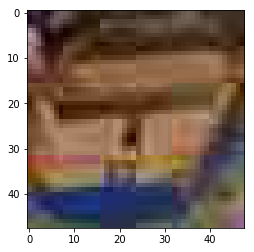

tensor([[[0.1927, 0.1809, 0.1904,  ..., 0.2490, 0.2011, 0.1883],
         [0.2001, 0.1981, 0.1789,  ..., 0.2063, 0.1900, 0.1867],
         [0.2642, 0.2211, 0.1551,  ..., 0.1997, 0.1763, 0.1906],
         ...,
         [0.3212, 0.3123, 0.3396,  ..., 0.4970, 0.5263, 0.5107],
         [0.3247, 0.3205, 0.3299,  ..., 0.4399, 0.4550, 0.4489],
         [0.3257, 0.3058, 0.3177,  ..., 0.4147, 0.4110, 0.3659]],

        [[0.1843, 0.1884, 0.1863,  ..., 0.2402, 0.2043, 0.1751],
         [0.2235, 0.2020, 0.1650,  ..., 0.1801, 0.1605, 0.1890],
         [0.2613, 0.2257, 0.1532,  ..., 0.1721, 0.1519, 0.1808],
         ...,
         [0.3338, 0.3309, 0.3621,  ..., 0.4698, 0.4903, 0.4823],
         [0.3712, 0.3612, 0.3366,  ..., 0.4249, 0.4445, 0.4309],
         [0.3155, 0.3448, 0.3192,  ..., 0.3952, 0.3829, 0.3581]],

        [[0.1601, 0.1534, 0.1704,  ..., 0.1824, 0.1392, 0.1317],
         [0.1975, 0.1637, 0.1438,  ..., 0.1186, 0.0888, 0.1305],
         [0.2370, 0.1882, 0.1136,  ..., 0.1115, 0.0886, 0.

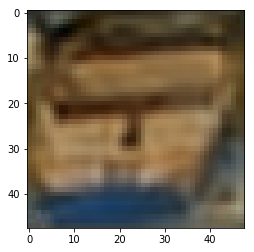

In [26]:
test_dataset = DenoisingDataset('data', 
                                train=False,
                                transform=transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                ]))
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)
decoded_samples = []
autoencoder.eval()
for step, x in enumerate(test_loader): 
    _,de_x = autoencoder(x)
    decoded_samples.append(de_x.detach().numpy())
    
sampled_z = np.concatenate(decoded_samples, axis=0)


def save_result(images: np.ndarray, out_path: str):
    assert images.shape == (400, 3, 48, 48)
    flat_img = images.reshape(400, -1)
    n_rows = np.prod(images.shape)
    
    y_with_id = np.concatenate([np.arange(n_rows).reshape(-1, 1), flat_img.reshape(n_rows, 1)], axis=1)
    np.savetxt(out_path, y_with_id, delimiter=",", fmt=['%d', '%.4f'], header="id,expetced", comments='')
    
save_result(sampled_z, 'solution.csv')
show_img(x[0].squeeze(0))
show_img(de_x[0].data.squeeze(0))
